In [1]:
import os
import numpy as np
import pandas as pd
import atomic_info
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
%matplotlib inline

In [2]:
elec_affinity={'B': 27,'Al':45,'Ga':30,'In':29,'C':123.4,'Si':135.0,'Ge':120,'Sn':122,'Pb':110,'N':-7,'P':72.4,'As':78,'Sb':102,'Bi':110,'O':142.5,'S':202.5,'Se':197.0,'Te':192.1,'F':331.4,'Cl':352.4,'Br':327.9,'I':298.4}
ionization_energy = {'B': 800.6,'Al':577.6,'Ga':578.8,'In':558.3,'C':1086.4,'Si':786.4,'Ge':762.1,'Sn':708.6,'Pb':722.9,'N':1420.3,'P':1011.7,'As':947,'Sb':833.7,'Bi':710.6,'O':1313.9,'S':999.6,'Se':940.9,'Te':869.2,'F':1681.0,'Cl':1251.1,'Br':1139.9,'I':1008.4}

In [3]:
#ionization_energy

___
## Section 0: Data preparation
___

### Section 0.1 Import band gap and band edge information

1. Band-gap information of 2D group III-VI-VII compounds at both PBE and HSE levels

2. Absolute positions of valence band maximum (VBM) and conduction band minimum (CBM) at both PBE and HSE levels
___

In [3]:
ternary_pbe=pd.read_csv('band_gap_info_pbe.dat',sep=' ',names=['Compound','Phase','Band gap (eV)','VBM (eV)','CBM (eV)'])

In [4]:
#ternary_info.columns

In [5]:
ternary_hse=pd.read_csv('band_gap_info_hse.dat',sep=' ',names=['Compound','Phase','HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)'])

In [6]:
#ternary_hse.head()

In [7]:
ternary_hse_part = ternary_hse[['HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)']]

In [8]:
ternary_hse.set_index('Phase',inplace=True)

In [9]:
ternary_hse_part = ternary_hse[['HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)']]

In [10]:
#ternary_hse_part.head()

In [11]:
ternary_pbe.set_index('Phase',inplace=True)

In [12]:
ternary_info = pd.concat([ternary_pbe, ternary_hse_part], axis=1, join='inner')

In [13]:
ternary_info.reset_index(inplace=True)

In [12]:
#ternary_info.head()

In [14]:
def str2float(data_frame,col_name):
    data_frame[col_name]=data_frame[col_name].map(lambda s:float(s))

In [17]:
#for col_name in ternary_info.columns.values.tolist()[2:8]:
#    str2float(ternary_info,col_name)

In [15]:
def read_vac_lev(filename,col_name,data_frame):
    """
    filename: contains your vacuum level information
    col_name: the column name you want to store in the data_frame
    data_frame: the loaded data_frame
    """
    vacuum_level_info = open(filename,'r')
    vacuum_level_cont = vacuum_level_info.readlines()
    vacuum_level_info.close()
    vacuum_level_dic = {}
    for line in vacuum_level_cont:
        vacuum_level_dic[line.split()[0]]=float(line.split()[1])
    data_frame[col_name]=data_frame['Phase'].map(lambda x: float(vacuum_level_dic[x]) 
                                                if x in vacuum_level_dic else 'null')

In [16]:
read_vac_lev('VAC_lev_pbe.dat','Vacuum level (eV)',ternary_info)

In [17]:
ternary_info.dropna(axis=0,how='any',inplace=True)

In [18]:
#ternary_info.info()

In [19]:
def calc_band_edge(edge_name,vacuum,data_frame):
    """
    obtain band edge
    """
    target_name = edge_name.split()[0] + ' Absolute ' + edge_name.split()[1]
    data_frame[target_name]=data_frame[edge_name]-data_frame[vacuum]

In [20]:
calc_band_edge('VBM (eV)','Vacuum level (eV)',ternary_info)

In [21]:
calc_band_edge('CBM (eV)','Vacuum level (eV)',ternary_info)

In [22]:
read_vac_lev('VAC_lev_hse.dat','HSE vacuum level (eV)',ternary_info)

In [23]:
calc_band_edge('HSE-VBM (eV)','HSE vacuum level (eV)',ternary_info)

In [24]:
calc_band_edge('HSE-CBM (eV)','HSE vacuum level (eV)',ternary_info)

### Section 0.2 Import elementary information, such as element mass, element electronegativity, and so on
___

In [25]:
"""
seperate to different elements
"""
elem_dict  = {0:'Cation',1: 'Anion_1',2: 'Anion_2'}
for i in elem_dict:
    ternary_info[elem_dict[i]]=ternary_info['Compound'].map(lambda x:atomic_info.count_elem(x)[i])

In [26]:
"""
write the phase index
"""
ternary_info['Phase_index']=ternary_info['Phase'].map(lambda x:int(x.split('_')[-1]))

In [27]:
#ternary_info.head()

In [28]:
#
# introduce elect_negativity into the table
#
element_label_list = ['Cation','Anion_1','Anion_2']
for element_label in element_label_list:
    ternary_info[element_label+'_negativity']=ternary_info[element_label].map(lambda x: atomic_info.element.atomic_elec_neg[x])

In [29]:
#
# import element mass to the data_frame
#
element_label_list = ['Cation','Anion_1','Anion_2']
for element_label in element_label_list:
    ternary_info[element_label+'_mass']=ternary_info[element_label].map(lambda x: atomic_info.element.atomic_mass[x])

In [30]:
#
# import atomic radius to the data_frame
#
element_label_list = ['Cation','Anion_1','Anion_2']
for element_label in element_label_list:
    ternary_info[element_label+'_atomic_radius']=ternary_info[element_label].map(lambda x: atomic_info.element.atomic_radius[x])

### Section 0.3 Import structural information
___

In [31]:
ternary_struc=pd.read_csv('struc_info.dat',sep='\t',names=['Phase','a1 (A)','a2 (A)','a3 (A)','alpha','beta','gamma'])

In [32]:
ternary_struc.set_index('Phase',inplace=True)

In [33]:
ternary_info.set_index('Phase',inplace=True)

In [34]:
ternary_info = pd.concat([ternary_info, ternary_struc], axis=1, join='inner')

In [35]:
ternary_info.reset_index(inplace=True)

In [36]:
#ternary_info.head()

### Section 0.4 Import the cohesive energy
___

In [37]:
cohesive_energy = open('energy_pbe.dat','r')

In [38]:
energy_cont = cohesive_energy.readlines()

In [39]:
cohesive_energy.close()

In [40]:
energy_dict = {}

In [41]:
for line in energy_cont:
    energy_dict[line.split()[1]] = float(line.split()[2])

In [42]:
#energy_dict

In [43]:
ternary_info['Cohesive energy (eV/atom)']=ternary_info['Phase'].map(lambda x: energy_dict[x] if x in energy_dict else 0)

In [38]:
#ternary_info.info()

In [51]:
# ternary_info dataframe is saved to csv file;
#ternary_info.to_csv('ternary_info.csv')

### Section 0.5: Visulization of the structures
___

### GaTeCl structures
___
**Phase I** | **Phase II**
- | -
![alt](figure/GaTeCl_0_top.png) | ![alt](figure/GaTeCl_1_top.png)
![alt](figure/GaTeCl_0_side.png) | ![alt](figure/GaTeCl_1_side.png)

___
## Section 1: Relation between HSE gap and PBE gap
___

### Section 1.1: Loading data of elementary, binary, ternary_1, and ternary_2 structures
___

In [44]:
def plt_pbe_vs_hse(pbe_label,hse_label,data_frame,plot_redox=False, xrange=[0,12],yrange=[0,12]):
    plt.plot(data_frame[pbe_label],ternary_info[hse_label],'o')
    plt.plot(np.arange(-12,12),np.arange(-12,12),'-.')
    plt.xlabel(pbe_label)
    plt.ylabel(hse_label)
    #plt.xticks([0,2,4,6,8,10])
    plt.xlim(xrange[0],xrange[1])
    plt.ylim(yrange[0],yrange[1])
    if plot_redox is True:
        plt.plot(np.arange(xrange[0],xrange[1]+1),[-4.44]*(xrange[1]-xrange[0]+1),'-r')
        plt.plot(np.arange(xrange[0],xrange[1]+1),[-5.67]*(xrange[1]-xrange[0]+1),'-r')

In [53]:
#plt_pbe_vs_hse('Band gap (eV)','HSE-gap (eV)',ternary_info,xrange=[0,6], yrange=[0,6])

In [54]:
#hse_pbe_lf = lm.LinearRegression()
#sns.lmplot('Band gap (eV)','HSE-gap (eV)',ternary_info)

In [210]:
#ternary_info[['Vacuum level (eV)','HSE vacuum level (eV)']].head(5)

In [56]:
#for compound in ternary_info['Compound']:
#    print(compound)

In [1272]:
#plt_pbe_vs_hse('VBM Absolute (eV)','HSE-VBM Absolute (eV)',ternary_info,xrange=[-10,-2],yrange=[-10,-2])

In [1273]:
#plt_pbe_vs_hse('CBM Absolute (eV)','HSE-CBM Absolute (eV)',ternary_info,xrange=[-6,-2],yrange=[-6,-2])

In [45]:
ternary_2_info = pd.read_csv('ternary_2_info.csv')

In [62]:
binary_info = pd.read_csv('2DSemi_III-VII_IV-VI_V.csv')

In [48]:
# pbe_label = ['Band gap (eV)','VBM Absolute (eV)','CBM Absolute (eV)']
# hse_label = ['HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)']

In [63]:
binary_info.rename(columns={'VBM absolute (eV)':'VBM Absolute (eV)','CBM absolute (eV)':'CBM Absolute (eV)','HSE VBM absolute (eV)':'HSE-VBM Absolute (eV)','HSE CBM absolute (eV)':'HSE-CBM Absolute (eV)'}, inplace=True)

In [76]:
#binary_info.head(5)

In [48]:
#binary_info.dropna(axis=0,inplace=True)

In [52]:
atomic_info.count_elem('GeS')

['Ge', 'S']

In [64]:
binary_info['Type']=binary_info['Compound'].map(lambda x:len(atomic_info.count_elem(x)))

In [65]:
binary_info.drop('Unnamed: 0',axis=1,inplace=True)

___
### Section 1.2: plot PBE vs HSE (band gap, VBM, and CBM)
___

In [1]:
def subplt_pbe_vs_hse(ax,pbe_label,hse_label,xrange,yrange,data_frame=None,data_frame2=None,data_frame3=None):
    """
    """
    ax.plot(data_frame[pbe_label[0]],data_frame[hse_label[0]],'o',color = '#3498db',ms=4)
    if data_frame2 is not None:
        ax.plot(data_frame2[pbe_label[0]],data_frame2[hse_label[0]],'^',color='#2ecc71',ms=4)
    if data_frame3 is not None:
        ax.plot(data_frame3[pbe_label[0]],data_frame3[hse_label[0]],'s',color='#e74c3c',ms=4)
    ax.plot(np.arange(-12,12),np.arange(-12,12),'-.')
    ax.set_xlabel(pbe_label[1],fontsize=15)
    ax.set_ylabel(hse_label[1],fontsize=15)
    ax.set_aspect('equal')
    #plt.xticks([0,2,4,6,8,10])
    ax.set_xlim(xrange[0],xrange[1])
    ax.set_ylim(yrange[0],yrange[1])
    ax.set_yticks(fontsize=14)

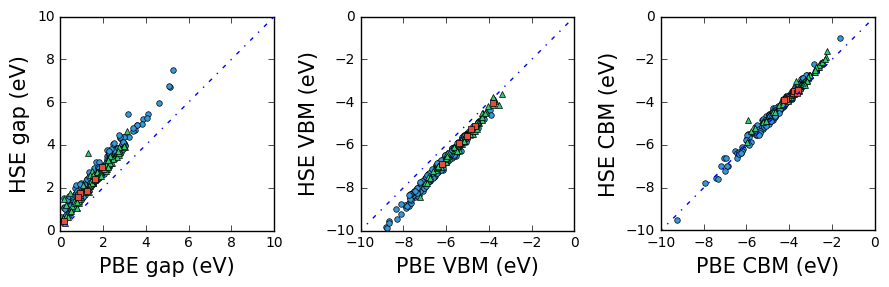

In [100]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
pbe_label = [('Band gap (eV)','PBE gap (eV)'),('VBM Absolute (eV)','PBE VBM (eV)'),('CBM Absolute (eV)','PBE CBM (eV)')]
hse_label = [('HSE-gap (eV)','HSE gap (eV)'),('HSE-VBM Absolute (eV)','HSE VBM (eV)'),('HSE-CBM Absolute (eV)','HSE CBM (eV)')]
xranges=[(0,10),(-10,0),(-10,0)]
yranges=[(0,10),(-10,0),(-10,0)]
for i in range(3):
    subplt_pbe_vs_hse(axes[i],pbe_label[i],hse_label[i],xranges[i],yranges[i],data_frame=all_select[all_select['Type']==3], data_frame2=all_select[all_select['Type']==2],data_frame3=all_select[all_select['Type']==1])
fig.tight_layout(rect=[0,0,1,1])

(0, 1)

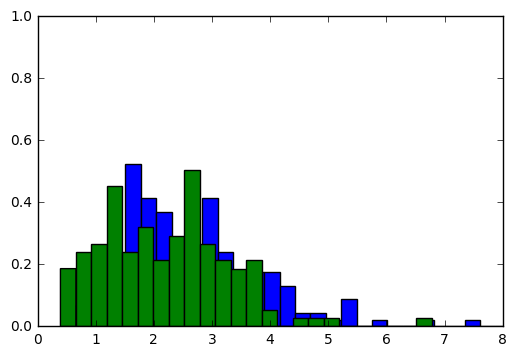

In [360]:
#fig,subplots=plt.subplots()
plt.hist(all_select[all_select['Phase index']==0]['HSE-gap (eV)'],normed=True,bins=40)
plt.hist(all_select[all_select['Phase index']==1]['HSE-gap (eV)'],normed=True,bins=24)
plt.xlim(0,8)
plt.ylim(0,1)

(0, 1)

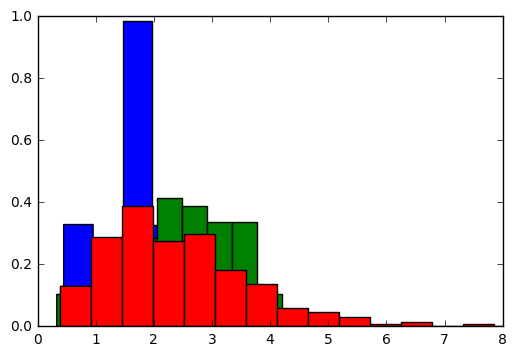

In [365]:
plt.hist(all_select[all_select['Type']==1]['HSE-gap (eV)'],normed=True,bins=5)
plt.hist(all_select[all_select['Type']==2]['HSE-gap (eV)'],normed=True,bins=10)
plt.hist(all_select[all_select['Type']==3]['HSE-gap (eV)'],normed=True,bins=20)
plt.xlim(0,8)
plt.ylim(0,1)

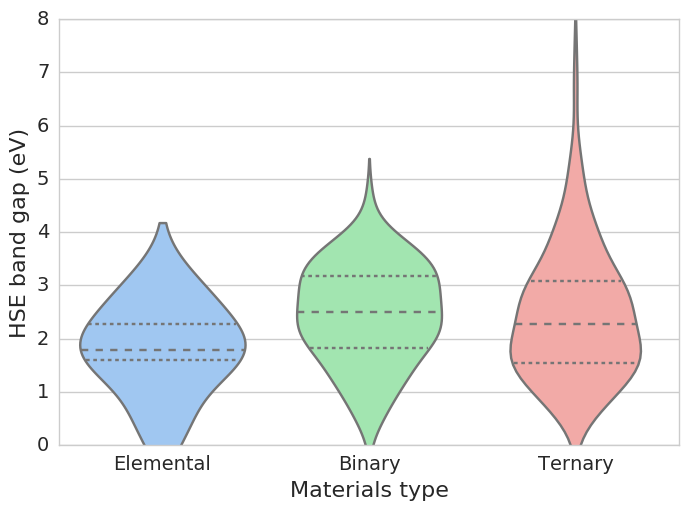

In [379]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="Type", y="HSE-gap (eV)", data=all_select, split=True,
               inner="quart")
plt.ylim(0,8)
plt.xticks([0,1,2],['Elemental','Binary','Ternary'],fontsize=14)
plt.yticks([0,1,2,3,4,5,6,7,8],fontsize=14)
plt.xlabel('Materials type',fontsize=16)
plt.ylabel('HSE band gap (eV)',fontsize=16)

In [383]:
all_select.head(1)

Phase  VBM Absolute (eV)  CBM Absolute (eV)  Band gap (eV)  HSE-gap (eV)  \
0   P_0          -5.043332          -4.132928       0.902202      1.736824   

   HSE-VBM Absolute (eV)  HSE-CBM Absolute (eV)  Type  Phase index Compound  \
0              -5.567745              -3.830921     1            0        P   

         ...         Anion_1_ionization  Anion_2_ionization  \
0        ...                   0.310284            0.210079   

   Cation_negativity  Anion_1_negativity  Anion_2_negativity  \
0                0.6            0.095238            0.095238   

   Anion_1 - Cation negativity  Anion_2 - Cation negativity  Cation_elec_aff  \
0                     0.137931                     0.137931          0.42037   

   Anion_1_elec_aff  Anion_2_elec_aff  
0          0.220924               0.0  

[1 rows x 22 columns]

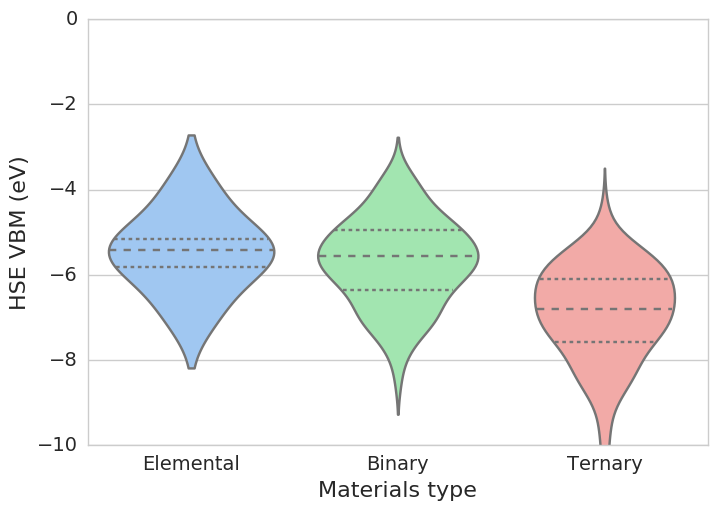

In [386]:
sns.violinplot(x="Type", y="HSE-VBM Absolute (eV)", data=all_select, split=True,
               inner="quart")
plt.ylim(-10,0)
plt.xticks([0,1,2],['Elemental','Binary','Ternary'],fontsize=14)
plt.yticks(list(range(-10,1,2)),fontsize=14)
plt.xlabel('Materials type',fontsize=16)
plt.ylabel('HSE VBM (eV)',fontsize=16)

In [407]:
import matplotlib as mpl

In [428]:
all_select_part = all_select[all_select['Phase index']!=2]

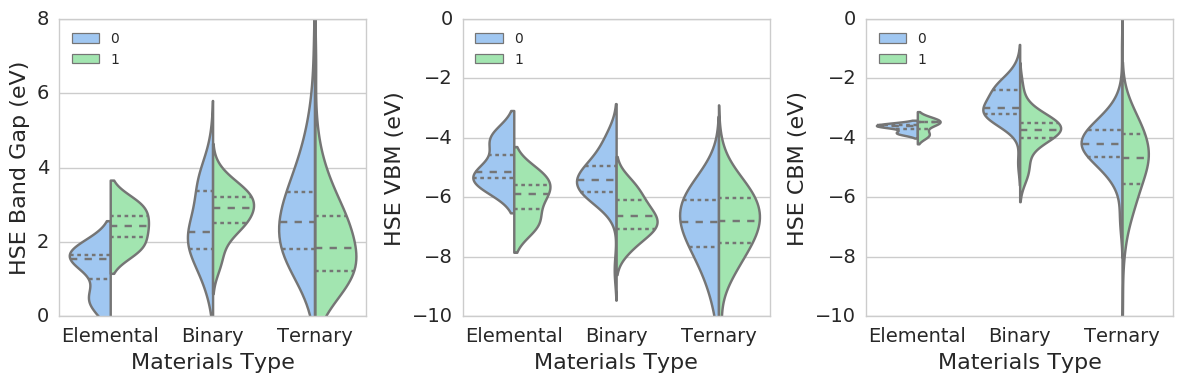

In [445]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
sns.violinplot(x="Type", y="HSE-gap (eV)",hue='Phase index', data=all_select_part, split=True,
               inner="quart",ax=ax1,bw=.6)
sns.violinplot(x="Type", y="HSE-VBM Absolute (eV)",hue='Phase index', data=all_select_part, split=True,
               inner="quart",ax=ax2,bw=.6)
sns.violinplot(x="Type", y="HSE-CBM Absolute (eV)",hue='Phase index', data=all_select_part, split=True,
               inner="quart",ax=ax3,bw=.6)
ax1.set_ylim(0,8)
ax2.set_ylim(-10,0)
ax3.set_ylim(-10,0)
ax1.set_ylabel('HSE Band Gap (eV)',fontsize=16)
ax2.set_ylabel('HSE VBM (eV)',fontsize=16)
ax3.set_ylabel('HSE CBM (eV)',fontsize=16)
ax1.set_yticks(range(0,9,2))
ax1.set_xticklabels(['Elemental','Binary','Ternary'],fontsize=14)
ax2.set_xticklabels(['Elemental','Binary','Ternary'],fontsize=14)
ax3.set_xticklabels(['Elemental','Binary','Ternary'],fontsize=14)
ax1.set_xlabel('Materials Type',fontsize=16)
ax2.set_xlabel('Materials Type',fontsize=16)
ax3.set_xlabel('Materials Type',fontsize=16)
#plt.yticks(fontsize=14)
fig.tight_layout(rect=(0,0,1,1))
mpl.rcParams['ytick.labelsize'] = 14
ax1.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

In [446]:
"""
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
sns.violinplot(x="Phase index", y="HSE-gap (eV)", data=all_select_part, split=True,
               inner="quart",ax=ax1)
sns.violinplot(x="Phase index", y="HSE-VBM Absolute (eV)", data=all_select_part, split=True,
               inner="quart",ax=ax2)
sns.violinplot(x="Phase index", y="HSE-CBM Absolute (eV)", data=all_select_part, split=True,
               inner="quart",ax=ax3)
ax1.set_ylim(0,8)
ax2.set_ylim(-10,0)
ax3.set_ylim(-10,0)
ax1.set_ylabel('HSE Band Gap (eV)',fontsize=16)
ax2.set_ylabel('HSE VBM (eV)',fontsize=16)
ax3.set_ylabel('HSE CBM (eV)',fontsize=16)
#ax1.set_xlim(-0.5,1.5)
#ax2.set_xlim(-0.5,1.5)
#ax3.set_xlim(-0.5,1.5)
ax1.set_yticks(range(0,9,2))
ax1.set_xticklabels(['A','B'],fontsize=14)
ax2.set_xticklabels(['A','B'],fontsize=14)
ax3.set_xticklabels(['A','B'],fontsize=14)
ax1.set_xlabel('Materials Phase',fontsize=16)
ax2.set_xlabel('Materials Phase',fontsize=16)
ax3.set_xlabel('Materials Phase',fontsize=16)
#plt.yticks(fontsize=14)
fig.tight_layout(rect=(0,0,1,1))
mpl.rcParams['ytick.labelsize'] = 14
"""

'\nfig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(12,4))\nsns.violinplot(x="Phase index", y="HSE-gap (eV)", data=all_select_part, split=True,\n               inner="quart",ax=ax1)\nsns.violinplot(x="Phase index", y="HSE-VBM Absolute (eV)", data=all_select_part, split=True,\n               inner="quart",ax=ax2)\nsns.violinplot(x="Phase index", y="HSE-CBM Absolute (eV)", data=all_select_part, split=True,\n               inner="quart",ax=ax3)\nax1.set_ylim(0,8)\nax2.set_ylim(-10,0)\nax3.set_ylim(-10,0)\nax1.set_ylabel(\'HSE Band Gap (eV)\',fontsize=16)\nax2.set_ylabel(\'HSE VBM (eV)\',fontsize=16)\nax3.set_ylabel(\'HSE CBM (eV)\',fontsize=16)\n#ax1.set_xlim(-0.5,1.5)\n#ax2.set_xlim(-0.5,1.5)\n#ax3.set_xlim(-0.5,1.5)\nax1.set_yticks(range(0,9,2))\nax1.set_xticklabels([\'A\',\'B\'],fontsize=14)\nax2.set_xticklabels([\'A\',\'B\'],fontsize=14)\nax3.set_xticklabels([\'A\',\'B\'],fontsize=14)\nax1.set_xlabel(\'Materials Phase\',fontsize=16)\nax2.set_xlabel(\'Materials Phase\',fontsize=16)\nax3

In [49]:
from sklearn import linear_model

In [50]:
vbm_lr=linear_model.LinearRegression()
cbm_lr=linear_model.LinearRegression()
gap_lr=linear_model.LinearRegression()

In [51]:
vbm_lr_t1=linear_model.LinearRegression()
cbm_lr_t1=linear_model.LinearRegression()
gap_lr_t1=linear_model.LinearRegression()

In [52]:
vbm_lr_t2=linear_model.LinearRegression()
cbm_lr_t2=linear_model.LinearRegression()
gap_lr_t2=linear_model.LinearRegression()

In [167]:
#test_lr=linear_model.LinearRegression()

In [155]:
#test_lr.fit([[1],[2]],[2,4])

In [53]:
binary_info.drop('Unnamed: 0',axis=1,inplace=True)
#binary_info

In [165]:
#np.array(binary_info['Band gap (eV)']).reshape(106,1)

In [54]:
binary_info.reset_index(inplace=True)

In [55]:
binary_info.drop('index',axis=1,inplace=True)

In [56]:
ternary_info.drop(ternary_info[ternary_info['Band gap (eV)']==0].index,inplace=True)

In [57]:
ternary_2_info.drop(ternary_2_info[ternary_2_info['Band gap (eV)']==0].index,inplace=True)

In [79]:
binary_info.drop(binary_info[binary_info['Band gap (eV)']==0].index,inplace=True)
#len(binary_info['Band gap (eV)'])

In [84]:

#binary_info.info()

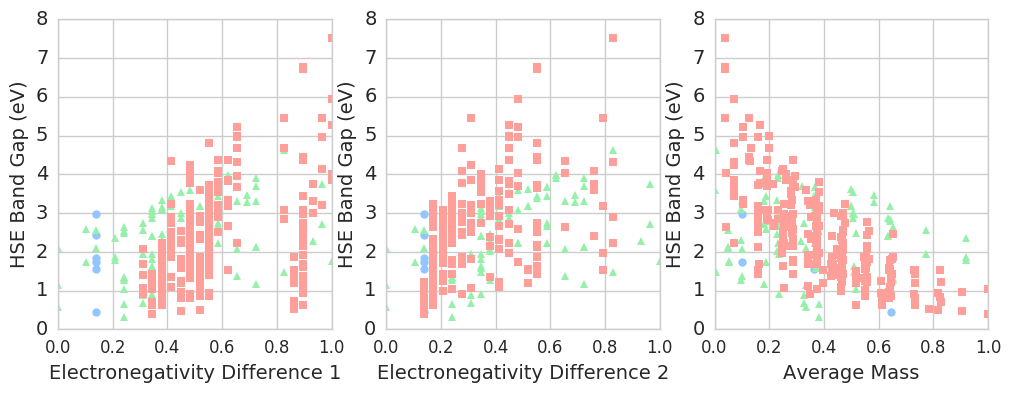

In [469]:
fig,axes=plt.subplots(1,3,figsize=(12,4))
axes[0].plot(all_select[all_select['Type']==1]['Anion_2 - Cation negativity'],all_select[all_select['Type']==1]['HSE-gap (eV)'],'o',ms=6)
axes[0].plot(all_select[all_select['Type']==2]['Anion_2 - Cation negativity'],all_select[all_select['Type']==2]['HSE-gap (eV)'],'^',ms=6)
axes[0].plot(all_select[all_select['Type']==3]['Anion_2 - Cation negativity'],all_select[all_select['Type']==3]['HSE-gap (eV)'],'s',ms=6)
axes[0].set_ylim(0,8)
axes[0].set_ylabel('HSE Band Gap (eV)',fontsize=14)
axes[0].set_xlabel('Electronegativity Difference 1',fontsize=14)
axes[1].plot(all_select[all_select['Type']==1]['Anion_1 - Cation negativity'],all_select[all_select['Type']==1]['HSE-gap (eV)'],'o',ms=6)
axes[1].plot(all_select[all_select['Type']==2]['Anion_1 - Cation negativity'],all_select[all_select['Type']==2]['HSE-gap (eV)'],'^',ms=6)
axes[1].plot(all_select[all_select['Type']==3]['Anion_1 - Cation negativity'],all_select[all_select['Type']==3]['HSE-gap (eV)'],'s',ms=6)
axes[1].set_ylim(0,8)
axes[1].set_ylabel('HSE Band Gap (eV)',fontsize=14)
axes[1].set_xlabel('Electronegativity Difference 2',fontsize=14)
axes[2].plot(all_select[all_select['Type']==1]['Average mass'],all_select[all_select['Type']==1]['HSE-gap (eV)'],'o',ms=6)
axes[2].plot(all_select[all_select['Type']==2]['Average mass'],all_select[all_select['Type']==2]['HSE-gap (eV)'],'^',ms=6)
axes[2].plot(all_select[all_select['Type']==3]['Average mass'],all_select[all_select['Type']==3]['HSE-gap (eV)'],'s',ms=6)
axes[2].set_ylim(0,8)
axes[2].set_ylabel('HSE Band Gap (eV)',fontsize=14)
axes[2].set_xlabel('Average Mass',fontsize=14)

___
### Section 1.3.1 Model fitting with elementary and binary structures
___

In [467]:
all_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 22 columns):
Phase                          342 non-null object
VBM Absolute (eV)              342 non-null float64
CBM Absolute (eV)              342 non-null float64
Band gap (eV)                  342 non-null float64
HSE-gap (eV)                   342 non-null float64
HSE-VBM Absolute (eV)          342 non-null float64
HSE-CBM Absolute (eV)          342 non-null float64
Type                           342 non-null int64
Phase index                    342 non-null int64
Compound                       342 non-null object
Average mass                   342 non-null float64
Cation_ionization              342 non-null float64
Anion_1_ionization             342 non-null float64
Anion_2_ionization             342 non-null float64
Cation_negativity              342 non-null float64
Anion_1_negativity             342 non-null float64
Anion_2_negativity             342 non-null float64
Anion_1 - Cation 

In [184]:
# fit binary
vbm_lr.fit(np.array(binary_info['VBM Absolute (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1),binary_info['HSE-VBM Absolute (eV)'])
cbm_lr.fit(np.array(binary_info['CBM Absolute (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1),binary_info['HSE-CBM Absolute (eV)'])
gap_lr.fit(np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1),binary_info['HSE-gap (eV)'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [185]:
# fit ternary 1
vbm_lr_t1.fit(np.array(ternary_info['VBM Absolute (eV)']).reshape(len(ternary_info['VBM Absolute (eV)']),1),ternary_info['HSE-VBM Absolute (eV)'])
cbm_lr_t1.fit(np.array(ternary_info['CBM Absolute (eV)']).reshape(len(ternary_info['CBM Absolute (eV)']),1),ternary_info['HSE-CBM Absolute (eV)'])
gap_lr_t1.fit(np.array(ternary_info['Band gap (eV)']).reshape(len(ternary_info['Band gap (eV)']),1),ternary_info['HSE-gap (eV)'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [186]:
# fit ternary 2
vbm_lr_t2.fit(np.array(ternary_2_info['VBM Absolute (eV)']).reshape(len(ternary_2_info['VBM Absolute (eV)']),1),ternary_2_info['HSE-VBM Absolute (eV)'])
cbm_lr_t2.fit(np.array(ternary_2_info['CBM Absolute (eV)']).reshape(len(ternary_2_info['CBM Absolute (eV)']),1),ternary_2_info['HSE-CBM Absolute (eV)'])
gap_lr_t2.fit(np.array(ternary_2_info['Band gap (eV)']).reshape(len(ternary_2_info['Band gap (eV)']),1),ternary_2_info['HSE-gap (eV)'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [187]:
#gap_lr

In [187]:
gap_lr.fit(np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['HSE-gap (eV)']),1),binary_info['HSE-gap (eV)'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [188]:
binary_gap_predicted=gap_lr.predict(np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['HSE-gap (eV)']),1))

In [189]:
binary_vbm_predicted = vbm_lr.predict(np.array(binary_info['VBM Absolute (eV)']).reshape(len(binary_info['HSE-gap (eV)']),1))
binary_cbm_predicted = cbm_lr.predict(np.array(binary_info['CBM Absolute (eV)']).reshape(len(binary_info['HSE-gap (eV)']),1))

In [58]:
def r_2(pred,calc):
    return 1-np.sum((pred-calc)**2)/np.sum((calc-np.mean(calc))**2)

In [173]:
r_2(binary_cbm_predicted-binary_vbm_predicted,binary_info['HSE-gap (eV)'])

0.9417032423535454

In [174]:
r_2(binary_gap_predicted,binary_info['HSE-gap (eV)'])

0.9221993098335884

In [59]:
def gap_plot(ax,pred_gap,cal_gap,marker=['o','^','s'],marker_color=['#3498db','#2ecc71','#e74c3c'],xlim=(0,8),ylim=(0,8)):
    if len(pred_gap)!=len(cal_gap):
        print('dimension not equal!')
    for i in range(len(pred_gap)):
        ax.plot(cal_gap[i],pred_gap[i],marker[i],color=marker_color[i],ms=5)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylabel('Predicted gap (eV)',fontsize=14)
    ax.set_xlabel('Calculated gap (eV)',fontsize=14)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0,8],[0,8],'-.')
    #ax.axhline(y=0,ls='-.')
    #ax.axis('scaled')

In [60]:
def gap_error_plot(ax,pred_gap,cal_gap,marker=['o','^','s'],marker_color=['#3498db','#2ecc71','#e74c3c'],xlim=(0,8),ylim=(-2,2)):
    if len(pred_gap)!=len(cal_gap):
        print('dimension not equal!')
    for i in range(len(pred_gap)):
        ax.plot(cal_gap[i],pred_gap[i]-cal_gap[i],marker[i],color=marker_color[i],ms=5)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylabel('Error (eV)',fontsize=14)
    ax.set_xlabel('Calculated gap (eV)',fontsize=14)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.axhline(y=0,ls='-.')
    #ax.axis('scaled')

In [211]:
"""
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(binary_cbm_predicted-binary_vbm_predicted,binary_info['HSE-gap (eV)'],'o')
axes[0].set_xlim(0,5)
axes[0].set_ylim(0,5)
axes[0].plot([0,5],[0,5],'-.')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Predicted gap (eV)')
axes[0].set_ylabel('Calculated gap (eV)')
axes[1].plot(binary_gap_predicted,binary_info['HSE-gap (eV)'],'o')
axes[1].set_xlim(0,5)
axes[1].set_ylim(0,5)
axes[1].plot([0,5],[0,5],'-.')
axes[1].set_aspect('equal')
axes[1].set_xlabel('Predicted gap (eV)')
axes[1].set_ylabel('Calculated gap (eV)')
"""

"\nfig, axes = plt.subplots(1,2,figsize=(8,4))\naxes[0].plot(binary_cbm_predicted-binary_vbm_predicted,binary_info['HSE-gap (eV)'],'o')\naxes[0].set_xlim(0,5)\naxes[0].set_ylim(0,5)\naxes[0].plot([0,5],[0,5],'-.')\naxes[0].set_aspect('equal')\naxes[0].set_xlabel('Predicted gap (eV)')\naxes[0].set_ylabel('Calculated gap (eV)')\naxes[1].plot(binary_gap_predicted,binary_info['HSE-gap (eV)'],'o')\naxes[1].set_xlim(0,5)\naxes[1].set_ylim(0,5)\naxes[1].plot([0,5],[0,5],'-.')\naxes[1].set_aspect('equal')\naxes[1].set_xlabel('Predicted gap (eV)')\naxes[1].set_ylabel('Calculated gap (eV)')\n"

In [191]:
# predict vbm, cbm with the model fitted by binary compounds
ternary_1_vbm_predicted=vbm_lr.predict(np.array(ternary_info['VBM Absolute (eV)']).reshape(len(ternary_info['VBM Absolute (eV)']),1))
ternary_2_vbm_predicted=vbm_lr.predict(np.array(ternary_2_info['VBM Absolute (eV)']).reshape(len(ternary_2_info['VBM Absolute (eV)']),1))
ternary_1_cbm_predicted=cbm_lr.predict(np.array(ternary_info['CBM Absolute (eV)']).reshape(len(ternary_info['CBM Absolute (eV)']),1))
ternary_2_cbm_predicted=cbm_lr.predict(np.array(ternary_2_info['CBM Absolute (eV)']).reshape(len(ternary_2_info['CBM Absolute (eV)']),1))

In [192]:
# predict band gap with the model fitted by binary compounds
ternary_1_gap_predicted=gap_lr.predict(np.array(ternary_info['Band gap (eV)']).reshape(len(ternary_info['Band gap (eV)']),1))
ternary_2_gap_predicted=gap_lr.predict(np.array(ternary_2_info['Band gap (eV)']).reshape(len(ternary_2_info['Band gap (eV)']),1))

In [175]:
#r_2()

0.9417032423535454

In [461]:
#r_2()

In [222]:
pred_gap_1_b=[binary_cbm_predicted-binary_vbm_predicted,ternary_1_cbm_predicted-ternary_1_vbm_predicted,ternary_2_cbm_predicted-ternary_2_vbm_predicted]
pred_gap_2_b=[binary_gap_predicted,ternary_1_gap_predicted,ternary_2_gap_predicted]
pred_gap_3_b=[(pred_gap_1_b[i]+pred_gap_2_b[i])/2 for i in range(3)]

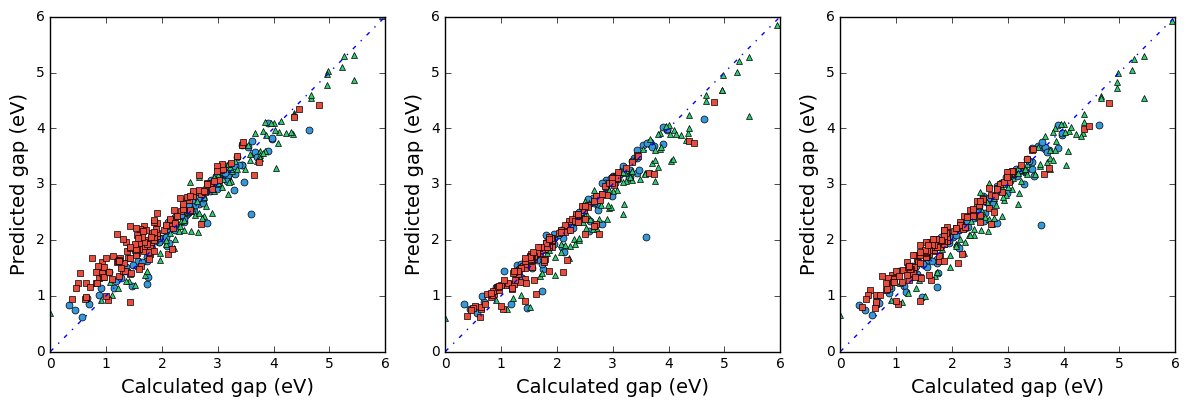

In [223]:
fig, axes_gap =plt.subplots(1,3,figsize=(12,4))
gap_plot(axes_gap[0],pred_gap_1_b,cal_gap,xlim=(0,6),ylim=(0,6))
gap_plot(axes_gap[1],pred_gap_2_b,cal_gap,xlim=(0,6),ylim=(0,6))
gap_plot(axes_gap[2],pred_gap_3_b,cal_gap,xlim=(0,6),ylim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

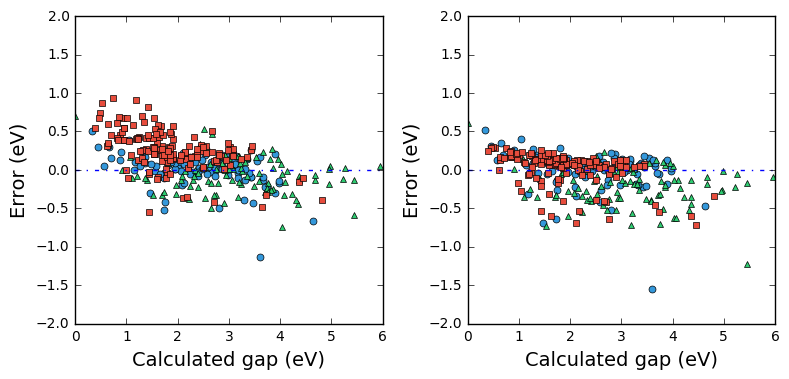

In [219]:
fig, axes =plt.subplots(1,2,figsize=(8,4))
gap_error_plot(axes[0],pred_gap_1_b,cal_gap,xlim=(0,6))
gap_error_plot(axes[1],pred_gap_2_b,cal_gap,xlim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

In [216]:
"""
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(binary_cbm_predicted-binary_vbm_predicted,binary_info['HSE-gap (eV)'],'o',color = '#3498db',ms=5)
axes[0].plot(ternary_1_cbm_predicted-ternary_1_vbm_predicted,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[0].plot(ternary_2_cbm_predicted-ternary_2_vbm_predicted,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[0].set_xlim(0,8)
axes[0].set_ylim(0,8)
axes[0].plot([0,8],[0,8],'-.',color = '#3498db')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Predicted gap (eV)')
axes[0].set_ylabel('Calculated gap (eV)')
axes[1].plot(binary_gap_predicted,binary_info['HSE-gap (eV)'],'o',color = '#3498db',ms=5)
axes[1].plot(ternary_1_gap_predicted,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[1].plot(ternary_2_gap_predicted,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[1].set_xlim(0,8)
axes[1].set_ylim(0,8)
axes[1].plot([0,8],[0,8],'-.',color = '#3498db')
axes[1].set_aspect('equal')
axes[1].set_xlabel('Predicted gap (eV)')
axes[1].set_ylabel('Calculated gap (eV)')
"""

"\nfig, axes = plt.subplots(1,2,figsize=(8,4))\naxes[0].plot(binary_cbm_predicted-binary_vbm_predicted,binary_info['HSE-gap (eV)'],'o',color = '#3498db',ms=5)\naxes[0].plot(ternary_1_cbm_predicted-ternary_1_vbm_predicted,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)\naxes[0].plot(ternary_2_cbm_predicted-ternary_2_vbm_predicted,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)\naxes[0].set_xlim(0,8)\naxes[0].set_ylim(0,8)\naxes[0].plot([0,8],[0,8],'-.',color = '#3498db')\naxes[0].set_aspect('equal')\naxes[0].set_xlabel('Predicted gap (eV)')\naxes[0].set_ylabel('Calculated gap (eV)')\naxes[1].plot(binary_gap_predicted,binary_info['HSE-gap (eV)'],'o',color = '#3498db',ms=5)\naxes[1].plot(ternary_1_gap_predicted,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)\naxes[1].plot(ternary_2_gap_predicted,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)\naxes[1].set_xlim(0,8)\naxes[1].set_ylim(0,8)\naxes[1].plot([0,8],[0,8],'-.',color = '#3498db')\naxes[1].set_aspect(

___
### Section 1.3.2 Model fitting with ternary_1 structures
___

In [194]:
#binary_info
#
# use model fitted by t1
#
binary_vbm_predicted_t1 = vbm_lr_t1.predict(np.array(binary_info['VBM Absolute (eV)']).reshape(len(binary_info['VBM Absolute (eV)']),1))
binary_cbm_predicted_t1 = cbm_lr_t1.predict(np.array(binary_info['CBM Absolute (eV)']).reshape(len(binary_info['VBM Absolute (eV)']),1))
binary_gap_predicted_t1 = gap_lr_t1.predict(np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['VBM Absolute (eV)']),1))
ternary_1_vbm_predicted_t1=vbm_lr_t1.predict(np.array(ternary_info['VBM Absolute (eV)']).reshape(len(ternary_info['VBM Absolute (eV)']),1))
ternary_2_vbm_predicted_t1=vbm_lr_t1.predict(np.array(ternary_2_info['VBM Absolute (eV)']).reshape(len(ternary_2_info['VBM Absolute (eV)']),1))
ternary_1_cbm_predicted_t1=cbm_lr_t1.predict(np.array(ternary_info['CBM Absolute (eV)']).reshape(len(ternary_info['CBM Absolute (eV)']),1))
ternary_2_cbm_predicted_t1=cbm_lr_t1.predict(np.array(ternary_2_info['CBM Absolute (eV)']).reshape(len(ternary_2_info['CBM Absolute (eV)']),1))
ternary_1_gap_predicted_t1=gap_lr_t1.predict(np.array(ternary_info['Band gap (eV)']).reshape(len(ternary_info['Band gap (eV)']),1))
ternary_2_gap_predicted_t1=gap_lr_t1.predict(np.array(ternary_2_info['Band gap (eV)']).reshape(len(ternary_2_info['Band gap (eV)']),1))

In [214]:
"""
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(binary_cbm_predicted_t1-binary_vbm_predicted_t1,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[0].plot(ternary_1_cbm_predicted_t1-ternary_1_vbm_predicted_t1,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[0].plot(ternary_2_cbm_predicted_t1-ternary_2_vbm_predicted_t1,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[0].set_xlim(0,8)
axes[0].set_ylim(0,8)
axes[0].plot([0,8],[0,8],'-.',color='#2ecc71')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Predicted gap (eV)')
axes[0].set_ylabel('Calculated gap (eV)')
axes[1].plot(binary_gap_predicted_t1,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[1].plot(ternary_1_gap_predicted_t1,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[1].plot(ternary_2_gap_predicted_t1,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[1].set_xlim(0,8)
axes[1].set_ylim(0,8)
axes[1].plot([0,8],[0,8],'-.',color='#2ecc71')
axes[1].set_aspect('equal')
axes[1].set_xlabel('Predicted gap (eV)')
axes[1].set_ylabel('Calculated gap (eV)')
"""

"\nfig, axes = plt.subplots(1,2,figsize=(8,4))\naxes[0].plot(binary_cbm_predicted_t1-binary_vbm_predicted_t1,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)\naxes[0].plot(ternary_1_cbm_predicted_t1-ternary_1_vbm_predicted_t1,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)\naxes[0].plot(ternary_2_cbm_predicted_t1-ternary_2_vbm_predicted_t1,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)\naxes[0].set_xlim(0,8)\naxes[0].set_ylim(0,8)\naxes[0].plot([0,8],[0,8],'-.',color='#2ecc71')\naxes[0].set_aspect('equal')\naxes[0].set_xlabel('Predicted gap (eV)')\naxes[0].set_ylabel('Calculated gap (eV)')\naxes[1].plot(binary_gap_predicted_t1,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)\naxes[1].plot(ternary_1_gap_predicted_t1,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)\naxes[1].plot(ternary_2_gap_predicted_t1,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)\naxes[1].set_xlim(0,8)\naxes[1].set_ylim(0,8)\naxes[1].plot([0,8],[0,8],'-.',color='#2ecc71')\n

In [215]:
pred_gap_1_t1=[binary_cbm_predicted_t1-binary_vbm_predicted_t1,ternary_1_cbm_predicted_t1-ternary_1_vbm_predicted_t1,ternary_2_cbm_predicted_t1-ternary_2_vbm_predicted_t1]
pred_gap_2_t1=[binary_gap_predicted_t1,ternary_1_gap_predicted_t1,ternary_2_gap_predicted_t1]

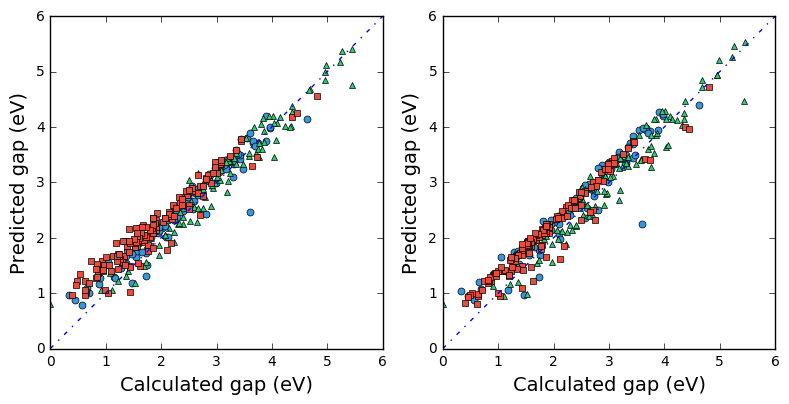

In [217]:
fig, axes_gap =plt.subplots(1,2,figsize=(8,4))
gap_plot(axes_gap[0],pred_gap_1_t1,cal_gap,xlim=(0,6),ylim=(0,6))
gap_plot(axes_gap[1],pred_gap_2_t1,cal_gap,xlim=(0,6),ylim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

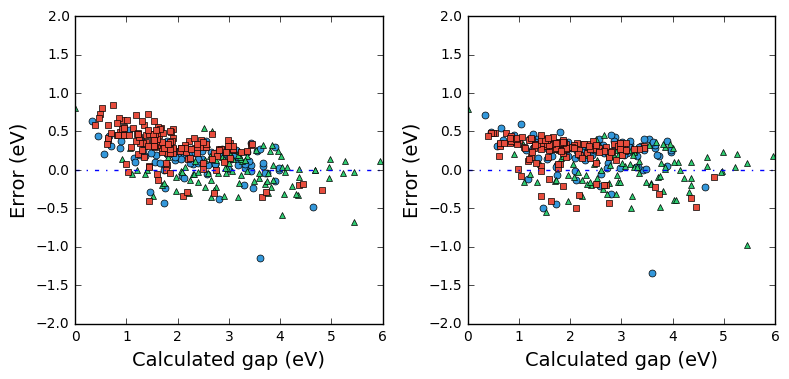

In [218]:
fig, axes =plt.subplots(1,2,figsize=(8,4))
gap_error_plot(axes[0],pred_gap_1_t1,cal_gap,xlim=(0,6))
gap_error_plot(axes[1],pred_gap_2_t1,cal_gap,xlim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

___
### Section 1.3.2 Model fitting with ternary_2 structures
___

In [197]:
binary_vbm_predicted_t2 = vbm_lr_t2.predict(np.array(binary_info['VBM Absolute (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1))
binary_cbm_predicted_t2 = cbm_lr_t2.predict(np.array(binary_info['CBM Absolute (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1))
binary_gap_predicted_t2 = gap_lr_t2.predict(np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1))
ternary_1_vbm_predicted_t2=vbm_lr_t2.predict(np.array(ternary_info['VBM Absolute (eV)']).reshape(len(ternary_info['VBM Absolute (eV)']),1))
ternary_2_vbm_predicted_t2=vbm_lr_t2.predict(np.array(ternary_2_info['VBM Absolute (eV)']).reshape(len(ternary_2_info['VBM Absolute (eV)']),1))
ternary_1_cbm_predicted_t2=cbm_lr_t2.predict(np.array(ternary_info['CBM Absolute (eV)']).reshape(len(ternary_info['CBM Absolute (eV)']),1))
ternary_2_cbm_predicted_t2=cbm_lr_t2.predict(np.array(ternary_2_info['CBM Absolute (eV)']).reshape(len(ternary_2_info['CBM Absolute (eV)']),1))
ternary_1_gap_predicted_t2=gap_lr_t2.predict(np.array(ternary_info['Band gap (eV)']).reshape(len(ternary_info['Band gap (eV)']),1))
ternary_2_gap_predicted_t2=gap_lr_t2.predict(np.array(ternary_2_info['Band gap (eV)']).reshape(len(ternary_2_info['Band gap (eV)']),1))

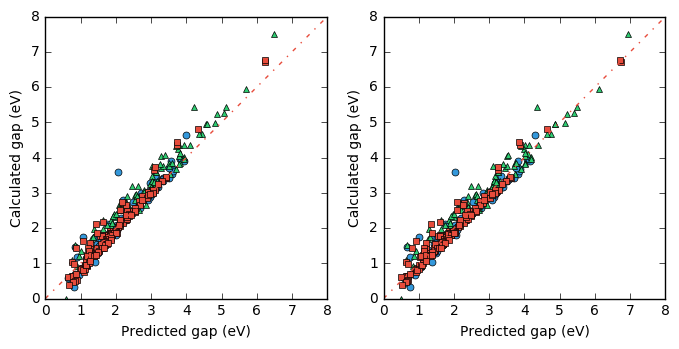

In [198]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(binary_cbm_predicted_t2-binary_vbm_predicted_t2,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[0].plot(ternary_1_cbm_predicted_t2-ternary_1_vbm_predicted_t2,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[0].plot(ternary_2_cbm_predicted_t2-ternary_2_vbm_predicted_t2,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[0].set_xlim(0,8)
axes[0].set_ylim(0,8)
axes[0].plot([0,8],[0,8],'-.',color='#e74c3c')
axes[0].set_aspect('equal')
axes[0].set_xlabel('Predicted gap (eV)')
axes[0].set_ylabel('Calculated gap (eV)')
axes[1].plot(binary_gap_predicted_t2,binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[1].plot(ternary_1_gap_predicted_t2,ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[1].plot(ternary_2_gap_predicted_t2,ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[1].set_xlim(0,8)
axes[1].set_ylim(0,8)
axes[1].plot([0,8],[0,8],'-.',color='#e74c3c')
axes[1].set_aspect('equal')
axes[1].set_xlabel('Predicted gap (eV)')
axes[1].set_ylabel('Calculated gap (eV)')

In [209]:
"""
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(binary_info['HSE-gap (eV)'],binary_cbm_predicted_t2-binary_vbm_predicted_t2-binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[0].plot(ternary_info['HSE-gap (eV)'],ternary_1_cbm_predicted_t2-ternary_1_vbm_predicted_t2-ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[0].plot(ternary_2_info['HSE-gap (eV)'],ternary_2_cbm_predicted_t2-ternary_2_vbm_predicted_t2-ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[0].set_xlim(0,8)
axes[0].set_ylim(-2,2)
#axes[0].plot([0,0],[8,0],'-.',color='#e74c3c')
axes[0].axhline(y=0, color='#e74c3c', linestyle='-.')
#axes[0].set_aspect('equal')
axes[0].set_xlabel('Calculated gap (eV)')
axes[0].set_ylabel('Error (eV)')
axes[1].plot(binary_info['HSE-gap (eV)'],binary_gap_predicted_t2-binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)
axes[1].plot(ternary_info['HSE-gap (eV)'],ternary_1_gap_predicted_t2-ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)
axes[1].plot(ternary_2_info['HSE-gap (eV)'],ternary_2_gap_predicted_t2-ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)
axes[1].set_xlim(0,8)
axes[1].set_ylim(-2,2)
#axes[1].plot([0,0],[8,0],'-.',color='#e74c3c')
axes[1].axhline(y=0, color='#e74c3c', linestyle='-.')
#axes[1].set_aspect('equal')
axes[1].set_xlabel('Calculated gap (eV)')
axes[1].set_ylabel('Error (eV)')
"""

"\nfig, axes = plt.subplots(1,2,figsize=(8,4))\naxes[0].plot(binary_info['HSE-gap (eV)'],binary_cbm_predicted_t2-binary_vbm_predicted_t2-binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)\naxes[0].plot(ternary_info['HSE-gap (eV)'],ternary_1_cbm_predicted_t2-ternary_1_vbm_predicted_t2-ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5)\naxes[0].plot(ternary_2_info['HSE-gap (eV)'],ternary_2_cbm_predicted_t2-ternary_2_vbm_predicted_t2-ternary_2_info['HSE-gap (eV)'],'s',color='#e74c3c',ms=5)\naxes[0].set_xlim(0,8)\naxes[0].set_ylim(-2,2)\n#axes[0].plot([0,0],[8,0],'-.',color='#e74c3c')\naxes[0].axhline(y=0, color='#e74c3c', linestyle='-.')\n#axes[0].set_aspect('equal')\naxes[0].set_xlabel('Calculated gap (eV)')\naxes[0].set_ylabel('Error (eV)')\naxes[1].plot(binary_info['HSE-gap (eV)'],binary_gap_predicted_t2-binary_info['HSE-gap (eV)'],'o',color='#3498db',ms=5)\naxes[1].plot(ternary_info['HSE-gap (eV)'],ternary_1_gap_predicted_t2-ternary_info['HSE-gap (eV)'],'^',color='#2ecc71',ms=5

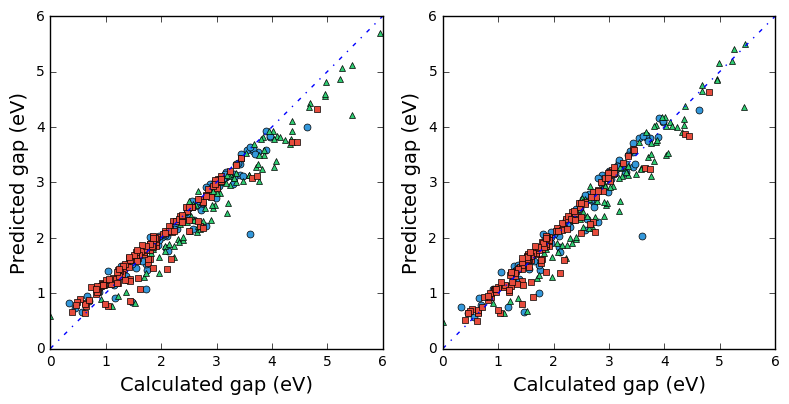

In [208]:
fig, axes_gap =plt.subplots(1,2,figsize=(8,4))
gap_plot(axes_gap[0],pred_gap_1_t2,cal_gap,xlim=(0,6),ylim=(0,6))
gap_plot(axes_gap[1],pred_gap_2_t2,cal_gap,xlim=(0,6),ylim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

In [206]:
pred_gap_1_t2=[binary_cbm_predicted_t2-binary_vbm_predicted_t2,ternary_1_cbm_predicted_t2-ternary_1_vbm_predicted_t2,ternary_2_cbm_predicted_t2-ternary_2_vbm_predicted_t2]
pred_gap_2_t2=[binary_gap_predicted_t2,ternary_1_gap_predicted_t2,ternary_2_gap_predicted_t2]
cal_gap=[binary_info['HSE-gap (eV)'],ternary_info['HSE-gap (eV)'],ternary_2_info['HSE-gap (eV)']]

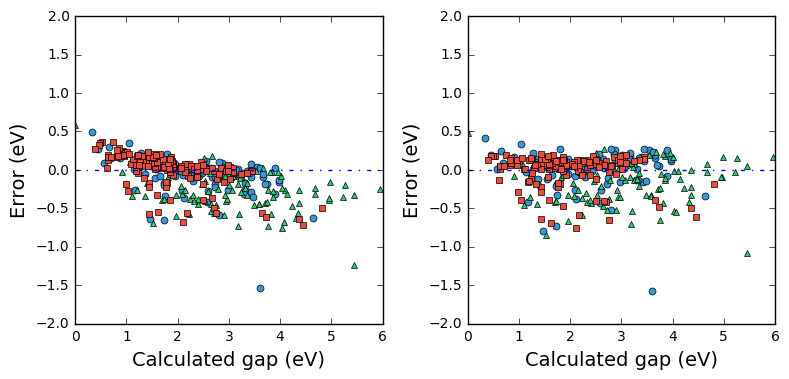

In [207]:
fig, axes =plt.subplots(1,2,figsize=(8,4))
gap_error_plot(axes[0],pred_gap_1_t2,cal_gap,xlim=(0,6))
gap_error_plot(axes[1],pred_gap_2_t2,cal_gap,xlim=(0,6))
fig.tight_layout(rect=[0,0,1,1])

In [74]:
# r^2 for first model
1-np.sum((binary_cbm_predicted_t1-binary_vbm_predicted_t1-np.array(binary_info['HSE-gap (eV)']))**2)/np.sum((np.array(binary_info['HSE-gap (eV)'])-np.mean(np.array(binary_info['HSE-gap (eV)'])))**2)

0.93816153079598896

In [75]:
# r^2 for second model
1-np.sum((binary_gap_predicted_t1-np.array(binary_info['HSE-gap (eV)']))**2)/np.sum((np.array(binary_info['HSE-gap (eV)'])-np.mean(np.array(binary_info['HSE-gap (eV)'])))**2)

0.91302925538656976

In [76]:
# r^2 for first model: ternary_1
1-np.sum((ternary_1_cbm_predicted_t1-ternary_1_vbm_predicted_t1-np.array(ternary_info['HSE-gap (eV)']))**2)/np.sum((np.array(ternary_info['HSE-gap (eV)'])-np.mean(np.array(ternary_info['HSE-gap (eV)'])))**2)

0.9678901600155152

In [78]:
# r^2 for second model: ternary_1
1-np.sum((ternary_1_gap_predicted_t1-np.array(ternary_info['HSE-gap (eV)']))**2)/np.sum((np.array(ternary_info['HSE-gap (eV)'])-np.mean(np.array(ternary_info['HSE-gap (eV)'])))**2)

0.96369500790677642

In [79]:
# r^2 for first model: ternary_2
1-np.sum((ternary_2_cbm_predicted_t1-ternary_2_vbm_predicted_t1-np.array(ternary_2_info['HSE-gap (eV)']))**2)/np.sum((np.array(ternary_2_info['HSE-gap (eV)'])-np.mean(np.array(ternary_2_info['HSE-gap (eV)'])))**2)

0.88049327379649511

In [80]:
# r^2 for second model: ternary_2
1-np.sum((ternary_2_gap_predicted_t1-np.array(ternary_2_info['HSE-gap (eV)']))**2)/np.sum((np.array(ternary_2_info['HSE-gap (eV)'])-np.mean(np.array(ternary_2_info['HSE-gap (eV)'])))**2)

0.93777255974911622

___
### Section 1.4 Combine binary, ternary_1, and ternary_2 structures
___

In [75]:
binary_select=binary_info[['Phase','VBM Absolute (eV)','CBM Absolute (eV)','Band gap (eV)','HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)','Type']]

In [62]:
# old
#binary_select['Type']=binary_select['Phase'].map(lambda x:1)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [67]:
#binary_select['Type']=binary_select[''].map(lambda x:1)

In [231]:
#binary_select

In [68]:
ternary_1_select=ternary_info[['Phase','VBM Absolute (eV)','CBM Absolute (eV)','Band gap (eV)','HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)']]

In [69]:
ternary_1_select['Type']=ternary_1_select['Phase'].map(lambda x:3)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [70]:
ternary_2_select=ternary_2_info[['Phase','VBM Absolute (eV)','CBM Absolute (eV)','Band gap (eV)','HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)']]

In [71]:
ternary_2_select['Type']=ternary_2_select['Phase'].map(lambda x:3)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [73]:
#ternary_1_select

In [76]:
frames=[binary_select,ternary_1_select,ternary_2_select]
all_select = pd.concat(frames)

In [78]:
all_select.dropna(inplace=True)

In [82]:
all_select.reset_index(inplace=True)

In [88]:
all_select.head()

Phase  VBM Absolute (eV)  CBM Absolute (eV)  Band gap (eV)  HSE-gap (eV)  \
0   P_0          -5.043332          -4.132928       0.902202      1.736824   
1   P_1          -6.173252          -4.229903       1.933175      2.981880   
2  As_0          -4.645834          -3.831167       0.806833      1.552500   
3  As_1          -5.384708          -3.771955       1.603376      2.424000   
4  As_2          -4.029373          -4.029373       0.000000      0.000000   

   HSE-VBM Absolute (eV)  HSE-CBM Absolute (eV)  Type  
0              -5.567745              -3.830921     1  
1              -6.872901              -3.891021     1  
2              -5.129834              -3.577334     1  
3              -5.902415              -3.478415     1  
4              -4.200440              -4.200440     1

In [87]:
all_select.drop('index',axis=1,inplace=True)

In [90]:
#all_select[all_select['Band gap (eV)']==0]

In [91]:
all_select.drop(all_select[all_select['Band gap (eV)']==0].index,inplace=True)

In [85]:
#all_select[all_select['HSE-gap (eV)']==0]

In [92]:
all_select.drop(all_select[all_select['HSE-gap (eV)']==0].index,inplace=True)

In [93]:
all_select.reset_index(inplace=True)

In [94]:
all_select.drop('index',axis=1,inplace=True)

In [95]:
all_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 8 columns):
Phase                    342 non-null object
VBM Absolute (eV)        342 non-null float64
CBM Absolute (eV)        342 non-null float64
Band gap (eV)            342 non-null float64
HSE-gap (eV)             342 non-null float64
HSE-VBM Absolute (eV)    342 non-null float64
HSE-CBM Absolute (eV)    342 non-null float64
Type                     342 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 21.5+ KB


___
### Section 1.4.1 Use VBM and CBM as predictors
___

In [114]:
#all_select[all_select['HSE-gap (eV)']==0]

In [101]:
#import sklearn.cross_validation as cv
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [104]:
from sklearn import linear_model

In [252]:
#all_select

In [105]:
lm_vbm_cbm = linear_model.LinearRegression()

In [106]:
lm_vbm_cbm_ridge = linear_model.Ridge()

In [107]:
lm_vbm_cbm_lasso = linear_model.Lasso(alpha=0.01)

In [108]:
features_vbm_cbm = all_select[['VBM Absolute (eV)','CBM Absolute (eV)']]

In [109]:
target_hse_gap = all_select['HSE-gap (eV)']

In [110]:
lm_vbm_cbm_full = linear_model.LinearRegression()

In [111]:
lm_vbm_cbm_full.fit(features_vbm_cbm,target_hse_gap)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [112]:
(lm_vbm_cbm_full.coef_,lm_vbm_cbm_full.intercept_)

(array([-1.24205554,  1.16574334]), 0.13390580181337075)

___
### HSE gap vs PBE vbm and cbm
**$\rm E_{HSE} = 1.166~CBM_{PBE}-1.242~VBM_{PBE}+0.134$**
### HSE gap vs PBE vbm and cbm
**$\rm E_{HSE} = 1.171~CBM_{PBE}-1.249~VBM_{PBE}+0.134$**
___

In [113]:
predicted_lm = cross_val_predict(lm_vbm_cbm,features_vbm_cbm,target_hse_gap,cv=10)
predicted_lm_ridge = cross_val_predict(lm_vbm_cbm_ridge,features_vbm_cbm,target_hse_gap,cv=10)
predicted_lm_lasso = cross_val_predict(lm_vbm_cbm_lasso,features_vbm_cbm,target_hse_gap,cv=10)

In [125]:
#predicted_lm_score = cross_val_score(lm_vbm_cbm,features_vbm_cbm,target_hse_gap,cv=5)

In [126]:
#predicted_lm_score.mean()

In [114]:
[cross_val_score(lm_vbm_cbm,features_vbm_cbm,target_hse_gap,cv=10).mean(),cross_val_score(lm_vbm_cbm_ridge,features_vbm_cbm,target_hse_gap,cv=10).mean(),cross_val_score(lm_vbm_cbm_lasso,features_vbm_cbm,target_hse_gap,cv=10).mean()]

[0.85006786403233114, 0.84538782261185585, 0.83655297293675535]

In [115]:
def compare_plot_lm(ax,pred_gap,calc_gap,xlim=(0,8),ylim=(0,8)):
    ax.plot(calc_gap,pred_gap,'o',ms=4,color='#3498db')
    ax.plot([xlim[0],xlim[1]],[ylim[0],ylim[1]],'-.')
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel('HSE gap (eV)',fontsize=14)
    ax.set_ylabel('Predicted gap (eV)',fontsize=14)

In [116]:
def residue_plot_lm(ax,pred_gap,calc_gap,xlim=(0,8),ylim=(-4,4)):
    ax.plot(calc_gap,calc_gap-pred_gap,'s',ms=4,color='#e74c3c')
    #ax.plot([-2,2],[],'-.')
    #ax.set_xlim(0,8)
    #ax.set_ylim(-4,4)
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlabel('HSE gap (eV)',fontsize=14)
    ax.set_ylabel('Residue (eV)',fontsize=14)
    ax.axhline(y=0,ls='-.')

In [117]:
def mse_train_test(features,target,estimator,test_size=0.1,max_round=2):
    mse_rt = []
    for rand_state in range(1,max_round):
        f_train,f_test,t_train,t_test=train_test_split(features,target,test_size=test_size,random_state=rand_state)
        estimator.fit(f_train,t_train)
        t_pred=estimator.predict(f_test)
        mse_rt.append(mean_squared_error(t_pred,t_test))
    return max(mse_rt),min(mse_rt),sum(mse_rt)/len(mse_rt)

In [118]:
import math

In [119]:
def rmse_train_test(features,target,estimator,test_size=0.1,max_round=2):
    rmse_rt = []
    for rand_state in range(1,max_round):
        f_train,f_test,t_train,t_test=train_test_split(features,target,test_size=test_size,random_state=rand_state)
        estimator.fit(f_train,t_train)
        t_pred=estimator.predict(f_test)
        rmse_rt.append(math.sqrt(mean_squared_error(t_pred,t_test)))
    return max(rmse_rt),min(rmse_rt),sum(rmse_rt)/len(rmse_rt)

In [120]:
def mape_train_test(features,target,estimator,test_size=0.1,max_round=2):
    mape_rt = []
    for rand_state in range(1,max_round):
        f_train,f_test,t_train,t_test=train_test_split(features,target,test_size=test_size,random_state=rand_state)
        estimator.fit(f_train,t_train)
        t_pred=estimator.predict(f_test)
        mape_val = 0.0
        for val in zip(list(t_pred),list(t_test)):
            mape_val += abs((val[0]-val[1])/val[1])*100
        mape_val = mape_val / len(t_pred)
        mape_rt.append(mape_val)
    return max(mape_rt),min(mape_rt),sum(mape_rt)/len(mape_rt)

In [121]:
mape_train_test(features_vbm_cbm,target_hse_gap,lm_vbm_cbm,max_round=100)

(16.01336839117462, 6.2003749009091544, 10.640551816913408)

In [122]:
rmse_train_test(features_vbm_cbm,target_hse_gap,lm_vbm_cbm,max_round=100)

(0.3815139434311496, 0.16177472709013818, 0.2458291240327476)

In [123]:
mean_squared_error(predicted_lm,target_hse_gap)

0.069450757699056259

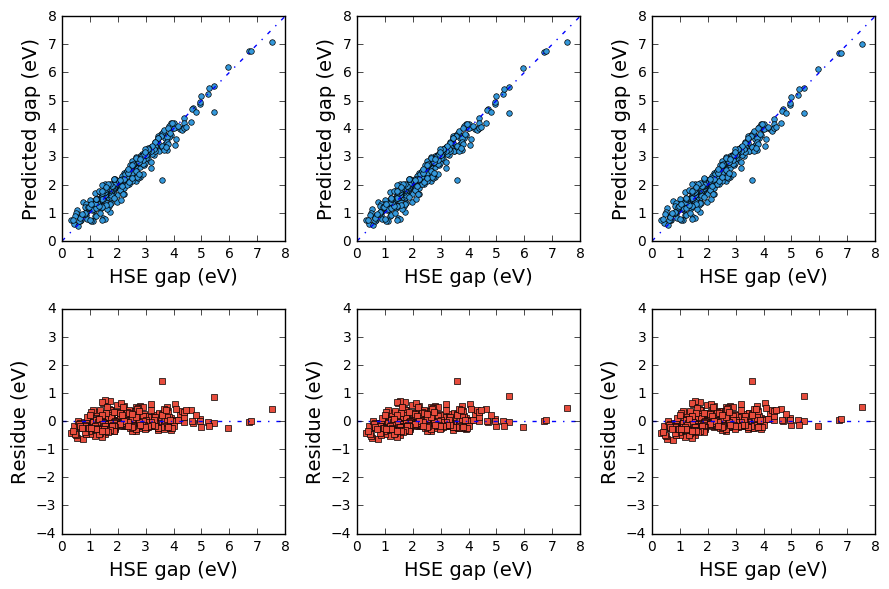

In [124]:
fig, axes = plt.subplots(2,3,figsize=(9,6))
compare_plot_lm(axes[0][0],predicted_lm,target_hse_gap)
compare_plot_lm(axes[0][1],predicted_lm_ridge,target_hse_gap)
compare_plot_lm(axes[0][2],predicted_lm_lasso,target_hse_gap)
residue_plot_lm(axes[1][0],predicted_lm,target_hse_gap)
residue_plot_lm(axes[1][1],predicted_lm_ridge,target_hse_gap)
residue_plot_lm(axes[1][2],predicted_lm_lasso,target_hse_gap)
fig.tight_layout(rect=[0,0,1,1])

In [125]:
#[mean_squared_error(predicted_lm,target_hse_gap),mean_squared_error(predicted_lm_ridge,target_hse_gap),mean_squared_error(predicted_lm_lasso,target_hse_gap)]

___
### Section 1.4.2 Use PBE band gap as the descriptor
___

In [126]:
#np.array(binary_info['Band gap (eV)']).reshape(len(binary_info['HSE-VBM Absolute (eV)']),1)
feature_pbe_gap = np.array(all_select['Band gap (eV)']).reshape(len(all_select['Band gap (eV)']),1)

In [127]:
lm_pbe_gap=linear_model.LinearRegression()
lm_pbe_gap_ridge=linear_model.Ridge()
lm_pbe_gap_lasso=linear_model.Lasso(alpha=0.01)

In [128]:
lm_pbe_gap_full=linear_model.LinearRegression()

In [129]:
lm_pbe_gap_full.fit(feature_pbe_gap,target_hse_gap)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
lm_pbe_gap_full.coef_

array([ 1.21370324])

In [131]:
lm_pbe_gap_full.intercept_

0.5161224754012419

___
(old)
### HSE gap vs PBE gap
**$\rm E_{HSE} = 1.214E_{PBE}+0.516$**
(new)
### HSE gap vs PBE gap
**$\rm E_{HSE} = 1.221E_{PBE}+0.502$**
___

In [508]:
# (old)
#mse_train_test(feature_pbe_gap,target_hse_gap,lm_pbe_gap,max_round=100)
#(0.16589461933129493, 0.024801266892860347, 0.066794352071593135)

(0.16589461933129493, 0.024801266892860347, 0.066794352071593135)

In [132]:
mse_train_test(feature_pbe_gap,target_hse_gap,lm_pbe_gap,max_round=100)

(0.16589461933129493, 0.024801266892860347, 0.066794352071593135)

In [133]:
#(old)
#rmse_train_test(feature_pbe_gap,target_hse_gap,lm_pbe_gap,max_round=100)
#(0.40730163187899815, 0.1574841798177212, 0.25464927595133385)

In [134]:
rmse_train_test(feature_pbe_gap,target_hse_gap,lm_pbe_gap,max_round=100)

(0.40730163187899815, 0.1574841798177212, 0.25464927595133385)

In [135]:
#all_select
predicted_lm_pbe = cross_val_predict(lm_pbe_gap,feature_pbe_gap,target_hse_gap,cv=10)
predicted_lm_pbe_ridge = cross_val_predict(lm_pbe_gap_ridge,feature_pbe_gap,target_hse_gap,cv=10)
predicted_lm_pbe_lasso = cross_val_predict(lm_pbe_gap_lasso,feature_pbe_gap,target_hse_gap,cv=10)

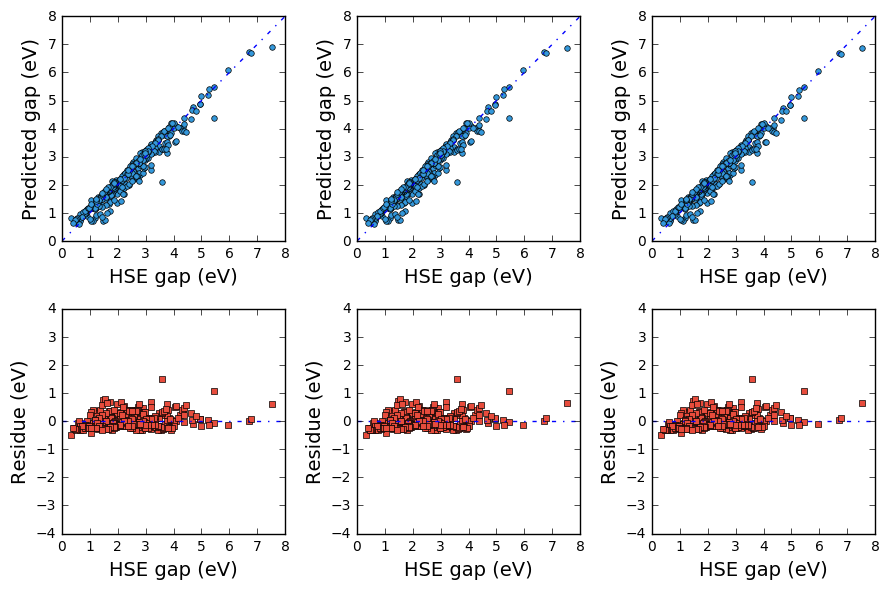

In [136]:
fig, axes = plt.subplots(2,3,figsize=(9,6))
compare_plot_lm(axes[0][0],predicted_lm_pbe,target_hse_gap)
compare_plot_lm(axes[0][1],predicted_lm_pbe_ridge,target_hse_gap)
compare_plot_lm(axes[0][2],predicted_lm_pbe_lasso,target_hse_gap)
residue_plot_lm(axes[1][0],predicted_lm_pbe,target_hse_gap)
residue_plot_lm(axes[1][1],predicted_lm_pbe_ridge,target_hse_gap)
residue_plot_lm(axes[1][2],predicted_lm_pbe_lasso,target_hse_gap)
fig.tight_layout(rect=[0,0,1,1])

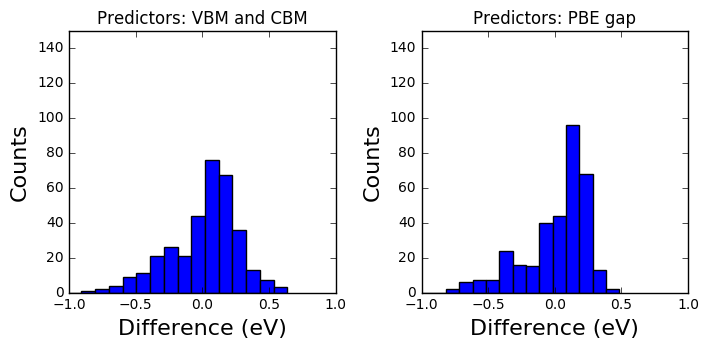

In [137]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].hist(predicted_lm-target_hse_gap,bins=20)
axes[0].set_xlim(-1,1)
axes[0].set_ylabel('Counts',fontsize=16)
axes[0].set_xlabel('Difference (eV)',fontsize=16)
axes[0].set_ylim(0,150)
axes[0].set_title('Predictors: VBM and CBM')
axes[1].hist(predicted_lm_pbe-target_hse_gap,bins=20)
axes[1].set_xlim(-1,1)
axes[1].set_ylabel('Counts',fontsize=16)
axes[1].set_xlabel('Difference (eV)',fontsize=16)
axes[1].set_ylim(0,150)
axes[1].set_title('Predictors: PBE gap')
fig.tight_layout(rect=[0,0,0.9,0.9])

In [138]:
#for i in range(len(target_hse_gap)):
#    print(i)
#[(list(predicted_lm_pbe)[i]-list(target_hse_gap)[i])/list(target_hse_gap)[i]*100 for i in range(343)]
#all_select.info()

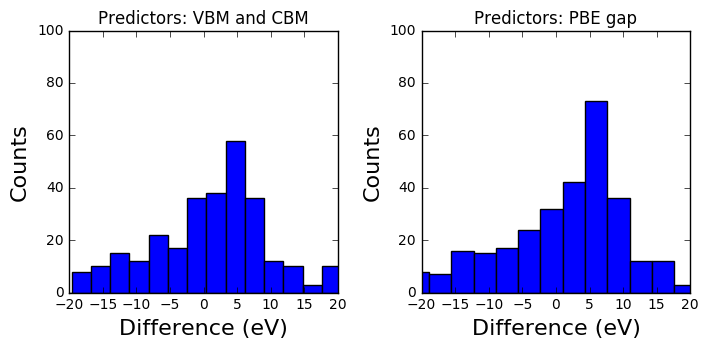

In [139]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].hist([(list(predicted_lm)[i]-list(target_hse_gap)[i])/list(target_hse_gap)[i]*100 for i in range(322)],bins=60)
axes[0].set_xlim(-20,20)
axes[0].set_ylabel('Counts',fontsize=16)
axes[0].set_xlabel('Difference (eV)',fontsize=16)
axes[0].set_ylim(0,100)
axes[0].set_title('Predictors: VBM and CBM')
axes[1].hist([(list(predicted_lm_pbe)[i]-list(target_hse_gap)[i])/list(target_hse_gap)[i]*100 for i in range(322)],bins=60)
axes[1].set_xlim(-20,20)
axes[1].set_ylabel('Counts',fontsize=16)
axes[1].set_xlabel('Difference (eV)',fontsize=16)
axes[1].set_ylim(0,100)
axes[1].set_title('Predictors: PBE gap')
fig.tight_layout(rect=[0,0,0.9,0.9])

___
### Section 1.4.3: Fitting HSE VBM with PBE VBM
___

In [140]:
lm_vbm = linear_model.LinearRegression()
lm_cbm = linear_model.LinearRegression()
#lm_vbm_ridge = linear_model.Ridge()
#lm_vbm_lasso = linear_model.Lasso(alpha=0.001)

In [141]:
feature_pbe_vbm = np.array(all_select['VBM Absolute (eV)']).reshape(len(all_select['VBM Absolute (eV)']),1)
feature_pbe_cbm = np.array(all_select['CBM Absolute (eV)']).reshape(len(all_select['CBM Absolute (eV)']),1)

In [142]:
target_hse_vbm = all_select['HSE-VBM Absolute (eV)']
target_hse_cbm = all_select['HSE-CBM Absolute (eV)']

In [143]:
#
lm_vbm_full = linear_model.LinearRegression()
lm_cbm_full = linear_model.LinearRegression()

In [144]:
lm_vbm_full.fit(feature_pbe_vbm,target_hse_vbm)
lm_cbm_full.fit(feature_pbe_cbm,target_hse_cbm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [145]:
(lm_vbm_full.coef_,lm_vbm_full.intercept_)

(array([ 1.1451131]), 0.23118266565353363)

In [146]:
(lm_cbm_full.coef_,lm_cbm_full.intercept_)

(array([ 1.06632616]), 0.50767772255918686)

(old)
### VBM prediction and CBM prediction
$\rm VBM_{HSE}=1.145VBM_{PBE}+0.231$

$\rm CBM_{HSE}=1.066CBM_{PBE}+0.508$
(new)
### VBM prediction and CBM prediction
$\rm VBM_{HSE}=1.148VBM_{PBE}+0.252$

$\rm CBM_{HSE}=1.066CBM_{PBE}+0.503$

In [147]:
predicted_lm_vbm = cross_val_predict(lm_vbm,feature_pbe_vbm,target_hse_vbm,cv=10)
predicted_lm_cbm = cross_val_predict(lm_cbm,feature_pbe_cbm,target_hse_cbm,cv=10)
#predicted_lm_vbm_ridge = cross_val_predict(lm_vbm_ridge,feature_pbe_gap,target_hse_vbm,cv=10)
#predicted_lm_vbm_lasso = cross_val_predict(lm_vbm_lasso,feature_pbe_gap,target_hse_vbm,cv=10)

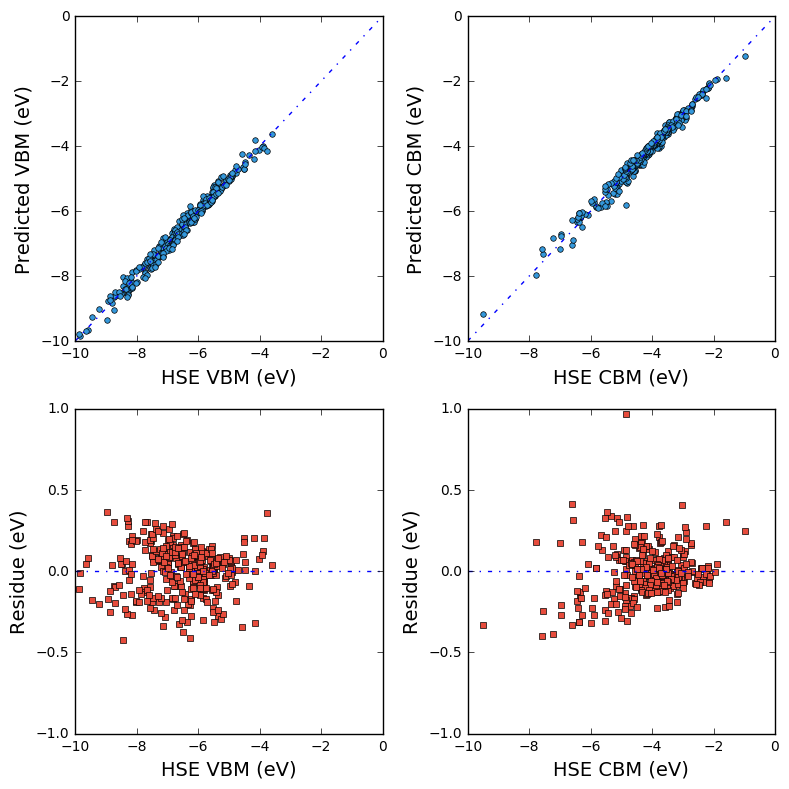

In [148]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
compare_plot_lm(axes[0][0],predicted_lm_vbm,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
axes[0][0].set_ylabel('Predicted VBM (eV)')
axes[0][0].set_xlabel('HSE VBM (eV)')
compare_plot_lm(axes[0][1],predicted_lm_cbm,target_hse_cbm,xlim=(-10,0),ylim=(-10,0))
axes[0][1].set_ylabel('Predicted CBM (eV)')
axes[0][1].set_xlabel('HSE CBM (eV)')
#compare_plot_lm(axes[0][1],predicted_lm_vbm_ridge,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
#compare_plot_lm(axes[0][2],predicted_lm_vbm_lasso,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
residue_plot_lm(axes[1][0],predicted_lm_vbm,target_hse_vbm,xlim=(-10,0),ylim=(-1,1))
axes[1][0].set_ylabel('Residue (eV)')
axes[1][0].set_xlabel('HSE VBM (eV)')
residue_plot_lm(axes[1][1],predicted_lm_cbm,target_hse_cbm,xlim=(-10,0),ylim=(-1,1))
#residue_plot_lm(axes[1][1],predicted_lm_vbm_ridge,target_hse_vbm,xlim=(-10,0),ylim=(-2,2))
#residue_plot_lm(axes[1][2],predicted_lm_vbm_lasso,target_hse_vbm,xlim=(-10,0),ylim=(-2,2))
axes[1][1].set_ylabel('Residue (eV)')
axes[1][1].set_xlabel('HSE CBM (eV)')
fig.tight_layout(rect=[0,0,1,1])

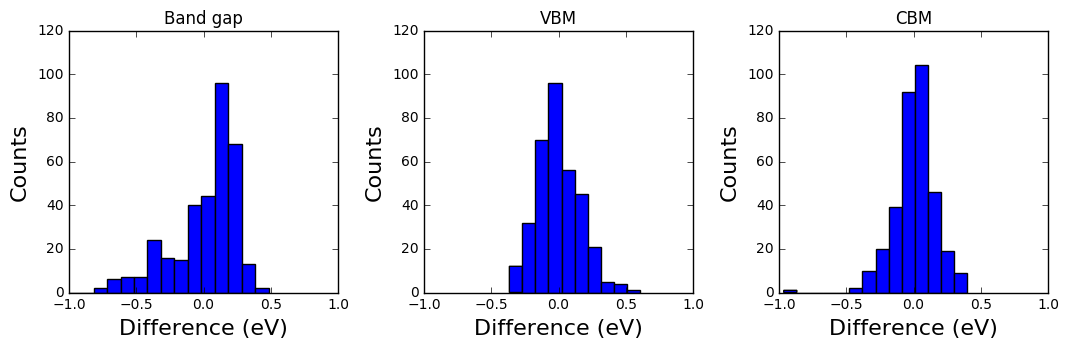

In [149]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
axes[1].hist(predicted_lm_vbm-target_hse_vbm,bins=10)
axes[1].set_xlim(-1,1)
axes[1].set_ylabel('Counts',fontsize=16)
axes[1].set_xlabel('Difference (eV)',fontsize=16)
axes[1].set_ylim(0,120)
axes[1].set_title('VBM')
axes[2].hist(predicted_lm_cbm-target_hse_cbm,bins=14)
axes[2].set_xlim(-1,1)
axes[2].set_ylabel('Counts',fontsize=16)
axes[2].set_xlabel('Difference (eV)',fontsize=16)
axes[2].set_ylim(0,120)
axes[2].set_title('CBM')
axes[0].hist(predicted_lm_pbe-target_hse_gap,bins=20)
axes[0].set_xlim(-1,1)
axes[0].set_ylabel('Counts',fontsize=16)
axes[0].set_xlabel('Difference (eV)',fontsize=16)
axes[0].set_ylim(0,120)
axes[0].set_title('Band gap')
fig.tight_layout(rect=[0,0,0.9,0.9])

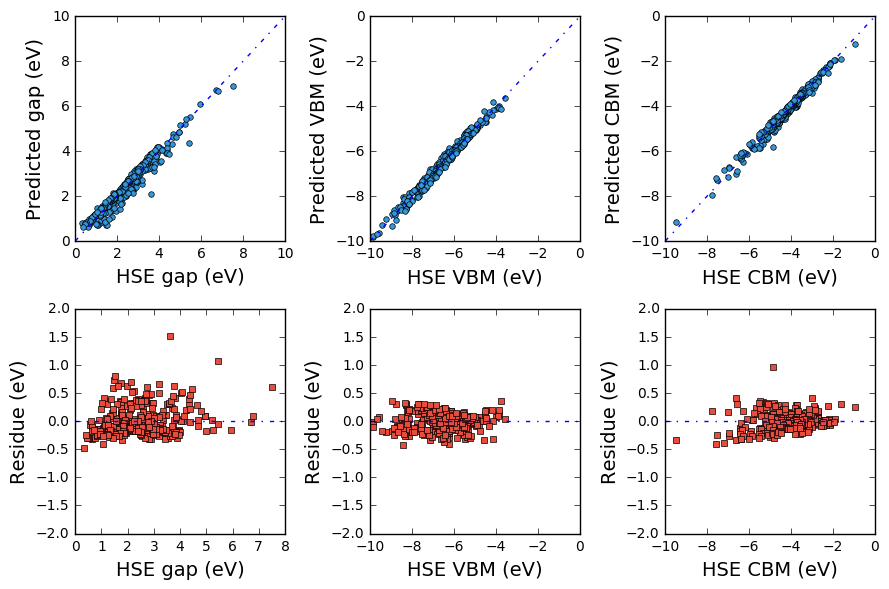

In [150]:
fig, axes = plt.subplots(2,3,figsize=(9,6))
compare_plot_lm(axes[0][1],predicted_lm_vbm,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
axes[0][1].set_ylabel('Predicted VBM (eV)')
axes[0][1].set_xlabel('HSE VBM (eV)')
compare_plot_lm(axes[0][2],predicted_lm_cbm,target_hse_cbm,xlim=(-10,0),ylim=(-10,0))
axes[0][2].set_ylabel('Predicted CBM (eV)')
axes[0][2].set_xlabel('HSE CBM (eV)')
#compare_plot_lm(axes[0][1],predicted_lm_vbm_ridge,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
#compare_plot_lm(axes[0][2],predicted_lm_vbm_lasso,target_hse_vbm,xlim=(-10,0),ylim=(-10,0))
residue_plot_lm(axes[1][1],predicted_lm_vbm,target_hse_vbm,xlim=(-10,0),ylim=(-2,2))
axes[1][1].set_ylabel('Residue (eV)')
axes[1][1].set_xlabel('HSE VBM (eV)')
residue_plot_lm(axes[1][2],predicted_lm_cbm,target_hse_cbm,xlim=(-10,0),ylim=(-2,2))
#residue_plot_lm(axes[1][1],predicted_lm_vbm_ridge,target_hse_vbm,xlim=(-10,0),ylim=(-2,2))
#residue_plot_lm(axes[1][2],predicted_lm_vbm_lasso,target_hse_vbm,xlim=(-10,0),ylim=(-2,2))
axes[1][2].set_ylabel('Residue (eV)')
axes[1][2].set_xlabel('HSE CBM (eV)')
compare_plot_lm(axes[0][0],predicted_lm_pbe,target_hse_gap,xlim=(0,10),ylim=(0,10))
residue_plot_lm(axes[1][0],predicted_lm_pbe,target_hse_gap,ylim=(-2,2))
fig.tight_layout(rect=[0,0,1,1])

In [151]:
lm_vbm_rmse = linear_model.LinearRegression()

In [152]:
# old
#rmse_train_test(feature_pbe_vbm,target_hse_vbm,lm_vbm_rmse,max_round=100)

In [153]:
rmse_train_test(feature_pbe_vbm,target_hse_vbm,lm_vbm_rmse,max_round=100)

(0.21208250844822718, 0.10522008653926217, 0.15207039810580186)

In [154]:
mape_train_test(feature_pbe_vbm,target_hse_vbm,lm_vbm_rmse,max_round=100)

(2.3449069174935628, 1.203400752006851, 1.8513401647389411)

In [155]:
lm_cbm_rmse=linear_model.LinearRegression()

In [156]:
rmse_train_test(feature_pbe_cbm,target_hse_cbm,lm_cbm_rmse,max_round=100)

(0.23085831181043692, 0.09457682291354794, 0.1366084433466761)

In [157]:
mape_train_test(feature_pbe_cbm,target_hse_cbm,lm_cbm_rmse,max_round=100)

(3.7690735014313428, 1.8202176234923311, 2.5267080070647188)

In [158]:
lm_gap_rmse=linear_model.LinearRegression()

In [159]:
rmse_train_test(feature_pbe_gap,target_hse_gap,lm_gap_rmse,max_round=100)

(0.40730163187899815, 0.1574841798177212, 0.25464927595133385)

In [160]:
mape_train_test(feature_pbe_gap,target_hse_gap,lm_gap_rmse,max_round=100)

(16.519589475014385, 6.5067904224269499, 10.728520940956551)

In [602]:
#all_select

___
### Section 1.5 Adding fundamental features
___

In [161]:
def normalize(data_frame, col_name, normal_type='rescaling'):
    """
    function: Normalize the data
    data_frame: the data frame you are dealing with
    col_name: the label of the column
    """
    max_val = data_frame[col_name].max()
    min_val = data_frame[col_name].min()
    mean_val = data_frame[col_name].mean()
    var_val = data_frame[col_name].var()
    if normal_type == 'rescaling' or normal_type == 'r':
        data_frame[col_name]=data_frame[col_name].map(lambda x: (x-min_val)*1.0/(max_val-min_val))
    elif normal_type == 'standardization' or normal_type == 's':
        data_frame[col_name]=data_frame[col_name].map(lambda x: (x-mean_val)*1.0/(var_val))

In [162]:
all_select.head(1)

Phase  VBM Absolute (eV)  CBM Absolute (eV)  Band gap (eV)  HSE-gap (eV)  \
0   P_0          -5.043332          -4.132928       0.902202      1.736824   

   HSE-VBM Absolute (eV)  HSE-CBM Absolute (eV)  Type  
0              -5.567745              -3.830921     1

In [163]:
all_select['Phase index']=all_select['Phase'].map(lambda x:int(x[-1]))

In [164]:
all_select['Compound']=all_select['Phase'].map(lambda x: x.split('_')[0])

In [165]:
def average_mass(compound):
    elems=atomic_info.count_elem(compound)
    if elems is None:
        return None
    if len(elems)==1:
        return atomic_info.element.atomic_mass[elems[0]]
    elif len(elems)==2:
        return (atomic_info.element.atomic_mass[elems[0]]+atomic_info.element.atomic_mass[elems[1]])/2.0
    elif len(elems)==3:
        return (atomic_info.element.atomic_mass[elems[0]]+atomic_info.element.atomic_mass[elems[1]]+atomic_info.element.atomic_mass[elems[2]])/3.0

In [166]:
#average_mass('GaTeCl')

In [178]:
#all_select.info()
#%load_ext autoreload
#%autoreload 2
import importlib
importlib.reload(atomic_info)

<module 'atomic_info' from '/Users/zhenzhu/Project/calculcation/IV-VI/ternary/atomic_info.py'>

In [167]:
all_select['Average mass']=all_select['Compound'].map(lambda x:average_mass(x))

In [168]:
normalize(all_select,'Average mass')

___

In [169]:
def ionization(compound):
    elems=atomic_info.count_elem(compound)
    if elems is None:
        return None
    if len(elems)==1:
        return (atomic_info.element.atomic_ionization_energy[elems[0]],atomic_info.element.atomic_ionization_energy[elems[0]],atomic_info.element.atomic_ionization_energy[elems[0]])
    elif len(elems)==2:
        return (atomic_info.element.atomic_ionization_energy[elems[0]],atomic_info.element.atomic_ionization_energy[elems[1]],atomic_info.element.atomic_ionization_energy[elems[1]])
    elif len(elems)==3:
        return (atomic_info.element.atomic_ionization_energy[elems[0]],atomic_info.element.atomic_ionization_energy[elems[1]],atomic_info.element.atomic_ionization_energy[elems[2]])

In [637]:
#ionization('P')

In [170]:
all_select['Cation_ionization']=all_select['Compound'].map(lambda x:ionization(x)[0])

In [171]:
all_select['Anion_1_ionization']=all_select['Compound'].map(lambda x:ionization(x)[1])

In [172]:
all_select['Anion_2_ionization']=all_select['Compound'].map(lambda x:ionization(x)[2])

In [173]:
labels=['Cation_ionization','Anion_1_ionization','Anion_2_ionization']
for label in labels:
    normalize(all_select,label)

___

In [174]:
def elec_negativity(compound):
    elems=atomic_info.count_elem(compound)
    if elems is None:
        return None
    if len(elems)==1:
        return (atomic_info.element.atomic_elec_neg[elems[0]],atomic_info.element.atomic_elec_neg[elems[0]],atomic_info.element.atomic_elec_neg[elems[0]])
    elif len(elems)==2:
        return (atomic_info.element.atomic_elec_neg[elems[0]],atomic_info.element.atomic_elec_neg[elems[1]],atomic_info.element.atomic_elec_neg[elems[1]])
    elif len(elems)==3:
        return (atomic_info.element.atomic_elec_neg[elems[0]],atomic_info.element.atomic_elec_neg[elems[1]],atomic_info.element.atomic_elec_neg[elems[2]])

In [175]:
elec_negativity('P')

(2.1, 2.1, 2.1)

In [176]:
all_select['Cation_negativity']=all_select['Compound'].map(lambda x:elec_negativity(x)[0])
all_select['Anion_1_negativity']=all_select['Compound'].map(lambda x:elec_negativity(x)[1])
all_select['Anion_2_negativity']=all_select['Compound'].map(lambda x:elec_negativity(x)[2])

In [177]:
all_select['Anion_1 - Cation negativity']=all_select['Anion_1_negativity']-all_select['Cation_negativity']
all_select['Anion_2 - Cation negativity']=all_select['Anion_2_negativity']-all_select['Cation_negativity']
#data_frame['(Anion_1 + Anion_2)/2 - Cation negativity']=data_frame['Anion_1_negativity']+data_frame['Anion_2_negativity']-data_frame['Cation_negativity']

In [178]:
labels=['Cation_negativity','Anion_1_negativity','Anion_2_negativity','Anion_1 - Cation negativity','Anion_2 - Cation negativity']
for label in labels:
    normalize(all_select,label)

___

In [179]:
#all_select['Anion_1_ionization'].min()
def elec_affinity(compound):
    elems=atomic_info.count_elem(compound)
    if elems is None:
        return None
    if len(elems)==1:
        return (atomic_info.element.atomic_elec_affinity[elems[0]],atomic_info.element.atomic_elec_affinity[elems[0]],atomic_info.element.atomic_elec_affinity[elems[0]])
    elif len(elems)==2:
        return (atomic_info.element.atomic_elec_affinity[elems[0]],atomic_info.element.atomic_elec_affinity[elems[1]],atomic_info.element.atomic_elec_affinity[elems[1]])
    elif len(elems)==3:
        return (atomic_info.element.atomic_elec_affinity[elems[0]],atomic_info.element.atomic_elec_affinity[elems[1]],atomic_info.element.atomic_elec_affinity[elems[2]])

In [180]:
all_select['Cation_elec_aff']=all_select['Compound'].map(lambda x:elec_affinity(x)[0])
all_select['Anion_1_elec_aff']=all_select['Compound'].map(lambda x:elec_affinity(x)[1])
all_select['Anion_2_elec_aff']=all_select['Compound'].map(lambda x:elec_affinity(x)[2])

In [181]:
labels=['Cation_elec_aff','Anion_1_elec_aff','Anion_2_elec_aff']
for label in labels:
    normalize(all_select,label)

___

In [182]:
all_select_features=all_select[['Type', 'Phase index', 'Average mass', 'Cation_ionization',
       'Anion_1_ionization', 'Anion_2_ionization', 'Cation_negativity',
       'Anion_1_negativity', 'Anion_2_negativity',
       'Anion_1 - Cation negativity', 'Anion_2 - Cation negativity',
       'Cation_elec_aff', 'Anion_1_elec_aff', 'Anion_2_elec_aff']]

all_select_target_vbm=all_select['HSE-VBM Absolute (eV)']
all_select_target_cbm=all_select['HSE-CBM Absolute (eV)']
all_select_target_gap=all_select['HSE-gap (eV)']

In [183]:
all_select_features_vbm=all_select[['VBM Absolute (eV)','Type', 'Phase index', 'Average mass', 'Cation_ionization',
       'Anion_1_ionization', 'Anion_2_ionization', 'Cation_negativity',
       'Anion_1_negativity', 'Anion_2_negativity',
       'Anion_1 - Cation negativity', 'Anion_2 - Cation negativity',
       'Cation_elec_aff', 'Anion_1_elec_aff', 'Anion_2_elec_aff']]
all_select_features_cbm=all_select[['CBM Absolute (eV)','Type', 'Phase index', 'Average mass', 'Cation_ionization',
       'Anion_1_ionization', 'Anion_2_ionization', 'Cation_negativity',
       'Anion_1_negativity', 'Anion_2_negativity',
       'Anion_1 - Cation negativity', 'Anion_2 - Cation negativity',
       'Cation_elec_aff', 'Anion_1_elec_aff', 'Anion_2_elec_aff']]
all_select_features_gap=all_select[['Band gap (eV)','Type', 'Phase index', 'Average mass', 'Cation_ionization',
       'Anion_1_ionization', 'Anion_2_ionization', 'Cation_negativity',
       'Anion_1_negativity', 'Anion_2_negativity',
       'Anion_1 - Cation negativity', 'Anion_2 - Cation negativity',
       'Cation_elec_aff', 'Anion_1_elec_aff', 'Anion_2_elec_aff']]

___

### Section 1.5.1 Comparing features
___

In [184]:
from sklearn import ensemble
from sklearn import svm

In [185]:
lm_simple = linear_model.LinearRegression()

In [186]:
lm_vbm_simple = linear_model.LinearRegression()

In [187]:
lm_ridge = linear_model.Ridge()

In [188]:
rfr_vbm = ensemble.RandomForestRegressor()

In [189]:
svr_vbm = svm.SVR(kernel='rbf', C=100, gamma=0.01)

In [190]:
predicted_vbm_simple=cross_val_predict(lm_vbm_simple,all_select_features,all_select_target_vbm,cv=10)

#### - Linear models

In [191]:
rmse_train_test(all_select_features,all_select_target_gap,lm_simple,max_round=100)

(1.4744848641764436, 0.5233350665514136, 0.869973041563473)

In [192]:
mape_train_test(all_select_features,all_select_target_gap,lm_simple,max_round=100)

(53.653398152089437, 19.127143199205577, 35.068968049168276)

In [193]:
rmse_train_test(all_select_features_gap,all_select_target_gap,lm_simple,max_round=100)

(0.2818926782463082, 0.08953880433269405, 0.15002062327648374)

In [194]:
mape_train_test(all_select_features_gap,all_select_target_gap,lm_simple,max_round=100)

(10.51570813992516, 3.3884981661552609, 5.5485194154562345)

In [195]:
rmse_train_test(all_select_features,all_select_target_vbm,lm_simple,max_round=100)

(1.2134793301065199, 0.6279778990240737, 0.8812982711124087)

In [196]:
mape_train_test(all_select_features,all_select_target_vbm,lm_simple,max_round=100)

(14.306887053989513, 7.3556675388082295, 10.302582283864556)

In [197]:
rmse_train_test(all_select_features_vbm,all_select_target_vbm,lm_simple,max_round=100)

(0.1369266409946704, 0.06381932741372, 0.08924924766990391)

In [198]:
mape_train_test(all_select_features_vbm,all_select_target_vbm,lm_simple,max_round=100)

(1.5356224414772797, 0.70021556689946229, 1.0401917635345725)

In [199]:
rmse_train_test(all_select_features,all_select_target_cbm,lm_simple,max_round=100)

(1.0561117702354812, 0.5569337284007647, 0.802325947715088)

In [200]:
mape_train_test(all_select_features,all_select_target_cbm,lm_simple,max_round=100)

(27.385352982843777, 10.324170775100866, 16.031467246188875)

In [201]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,lm_simple,max_round=100)

(0.16442483709903633, 0.05446648210024354, 0.08823638422288274)

In [202]:
mape_train_test(all_select_features_cbm,all_select_target_cbm,lm_simple,max_round=100)

(2.1601293684874712, 1.0464102886522515, 1.5585872325328376)

In [203]:
lm_predicted_gap = cross_val_predict(lm_simple,all_select_features,all_select_target_gap,cv=10)
lm_predicted_vbm = cross_val_predict(lm_simple,all_select_features,all_select_target_vbm,cv=10)
lm_predicted_cbm = cross_val_predict(lm_simple,all_select_features,all_select_target_cbm,cv=10)

In [204]:
lm_predicted_gap_2 = cross_val_predict(lm_simple,all_select_features_gap,all_select_target_gap,cv=10)
lm_predicted_vbm_2 = cross_val_predict(lm_simple,all_select_features_vbm,all_select_target_vbm,cv=10)
lm_predicted_cbm_2 = cross_val_predict(lm_simple,all_select_features_cbm,all_select_target_cbm,cv=10)

___

In [205]:
rmse_train_test(all_select_features,all_select_target_gap,lm_ridge,max_round=100)

(1.4477355624343415, 0.5129226137147107, 0.8680890354515652)

In [206]:
rmse_train_test(all_select_features_gap,all_select_target_gap,lm_ridge,max_round=100)

(0.28180824808400223, 0.09105100559301042, 0.14937396169647463)

In [207]:
rmse_train_test(all_select_features,all_select_target_vbm,lm_ridge,max_round=100)

(1.3018539857808447, 0.6356793581516246, 0.9275105078671232)

In [208]:
rmse_train_test(all_select_features_vbm,all_select_target_vbm,lm_ridge,max_round=100)

(0.14297627873878577, 0.058654529465703424, 0.08895828196306757)

In [209]:
rmse_train_test(all_select_features,all_select_target_cbm,lm_ridge,max_round=100)

(1.0866803234994826, 0.5975738174914981, 0.8238021161066508)

In [210]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,lm_ridge,max_round=100)

(0.16023799500696156, 0.05668633640307793, 0.08784573744002122)

___

In [211]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,rfr_vbm,max_round=100)

(0.49518727874354423, 0.07347870826908107, 0.15522074272871098)

In [212]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,svr_vbm,max_round=100)

(0.1945147380737041, 0.054193522667267416, 0.09232607139479711)

___
### Random Forest Regression
___

In [213]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Gap: RFR
___

In [214]:
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features,all_select_target_gap)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [215]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 8, 'min_samples_leaf': 2}, 0.08387023736893288)

In [230]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 10, 'min_samples_leaf': 2}, 0.09448026436083254)

In [216]:
rfr_predicted_gap=cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=8),all_select_features,all_select_target_gap,cv=10)

In [221]:
rmse_train_test(all_select_features,all_select_target_gap,RandomForestRegressor(min_samples_leaf=2,max_features=8),max_round=100)

(1.2289520513952277, 0.4215567950454343, 0.7010310902840263)

In [222]:
mape_train_test(all_select_features,all_select_target_gap,RandomForestRegressor(min_samples_leaf=2,max_features=8),max_round=100)

(44.760453462630629, 13.663354540665168, 26.378446360553909)

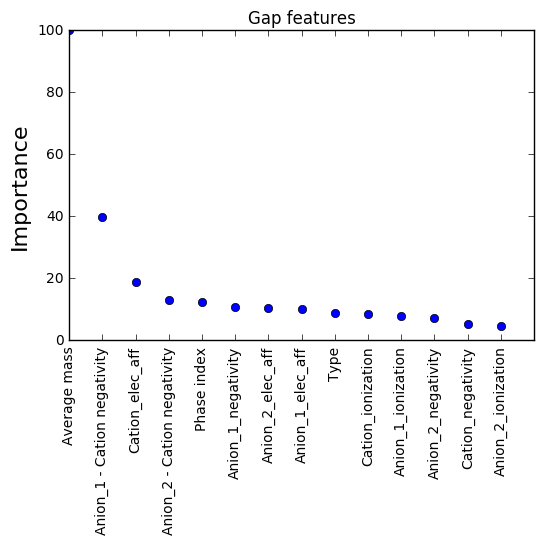

In [316]:
feature_importance_gap_1=RandomForestRegressor(min_samples_leaf=2,max_features=8)
feature_importance_gap_1.fit(all_select_features,all_select_target_gap)
plt_feature_importance(feature_importance_gap_1.feature_importances_,all_select_features,'Gap features')

In [219]:
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features_gap,all_select_target_gap)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [223]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 11, 'min_samples_leaf': 2}, 0.8857851735862113)

In [224]:
rfr_predicted_gap_2 = cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=11),all_select_features_gap,all_select_target_gap,cv=10)

In [225]:
rmse_train_test(all_select_features_gap,all_select_target_gap,RandomForestRegressor(min_samples_leaf=2,max_features=11),max_round=100)

(0.8841232398984962, 0.12540732223523388, 0.2547812787157302)

In [226]:
mape_train_test(all_select_features_gap,all_select_target_gap,RandomForestRegressor(min_samples_leaf=2,max_features=11),max_round=100)

(12.481960392488933, 4.2444787348543356, 7.4447883979669598)

(0, 20)

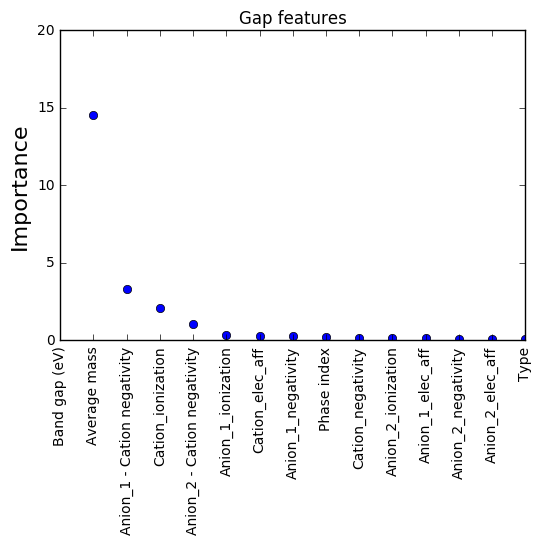

In [315]:
feature_importance_gap_2=RandomForestRegressor(min_samples_leaf=2,max_features=11)
feature_importance_gap_2.fit(all_select_features_gap,all_select_target_gap)
plt_feature_importance(feature_importance_gap_2.feature_importances_,all_select_features_gap,'Gap features')
plt.ylim(0,20)

___
### VBM: RFR
___

In [227]:
#all_select_features.info()
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features,all_select_target_vbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [228]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 9, 'min_samples_leaf': 2}, 0.4369181883514386)

In [229]:
rfr_predicted_vbm = cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=9),all_select_features,all_select_target_vbm,cv=10)

In [230]:
rmse_train_test(all_select_features,all_select_target_vbm,RandomForestRegressor(min_samples_leaf=2,max_features=9),max_round=100)

(0.9685568238280197, 0.3950219781458127, 0.6658372801694158)

In [231]:
mape_train_test(all_select_features,all_select_target_vbm,RandomForestRegressor(min_samples_leaf=2,max_features=9),max_round=100)

(13.085634904218981, 4.1412506397038102, 7.2330050696881889)

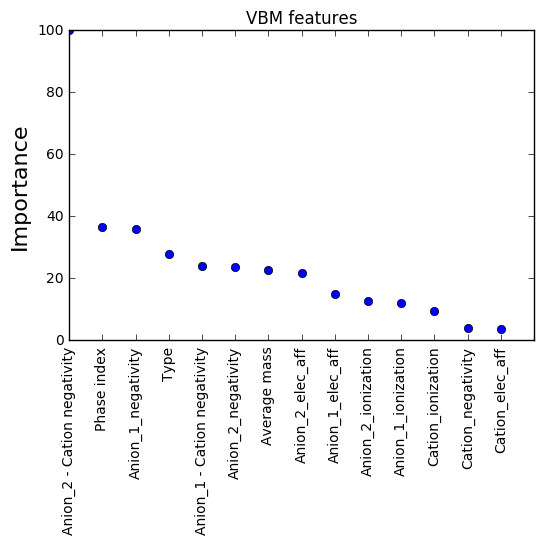

In [313]:
feature_importance_vbm_1=RandomForestRegressor(min_samples_leaf=2,max_features=9)
feature_importance_vbm_1.fit(all_select_features,all_select_target_vbm)
plt_feature_importance(feature_importance_vbm_1.feature_importances_,all_select_features,'VBM features')

In [232]:
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features_vbm,all_select_target_vbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [233]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 10, 'min_samples_leaf': 2}, 0.9669466685099061)

In [234]:
rfr_predicted_vbm_2=cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=10),all_select_features_vbm,all_select_target_vbm,cv=10)

In [235]:
rmse_train_test(all_select_features_vbm,all_select_target_vbm,RandomForestRegressor(min_samples_leaf=2,max_features=10),max_round=100)

(0.5198625269487906, 0.09204811686765486, 0.1815202180358747)

In [236]:
mape_train_test(all_select_features_vbm,all_select_target_vbm,RandomForestRegressor(min_samples_leaf=2,max_features=10),max_round=100)

(3.0900724610020451, 1.0282245480964458, 1.7514760767846389)

In [309]:
feature_importance_vbm_2=RandomForestRegressor(min_samples_leaf=2,max_features=10)
%feature_importance_vbm_2.fit(all_select_features_vbm,all_select_target_vbm)

In [310]:
feature_importance_vbm_2.fit(all_select_features_vbm,all_select_target_vbm)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

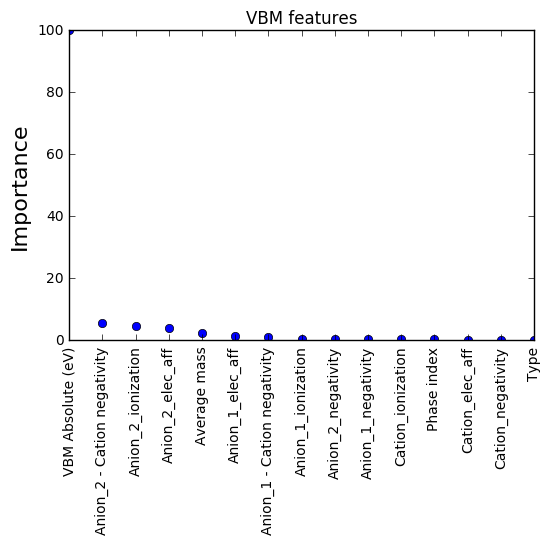

In [311]:
plt_feature_importance(feature_importance_vbm_2.feature_importances_,all_select_features_vbm,'VBM features')

___
### CBM: RFR
___

In [237]:
#all_select_features.info()
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features,all_select_target_cbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [238]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 8, 'min_samples_leaf': 5}, -0.17188872448907971)

In [240]:
rfr_predicted_cbm = cross_val_predict(RandomForestRegressor(min_samples_leaf=5,max_features=8),all_select_features,all_select_target_cbm,cv=10)

In [241]:
rmse_train_test(all_select_features,all_select_target_cbm,RandomForestRegressor(min_samples_leaf=5,max_features=8),max_round=100)

(0.8674345134487977, 0.373026884132341, 0.5789850650812908)

In [242]:
mape_train_test(all_select_features,all_select_target_cbm,RandomForestRegressor(min_samples_leaf=5,max_features=8),max_round=100)

(16.284018631363494, 6.337306737429472, 10.222551192924527)

In [306]:
obt_feature_importance_2=RandomForestRegressor(min_samples_leaf=5,max_features=8)

In [307]:
obt_feature_importance_2.fit(all_select_features,all_select_target_cbm)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

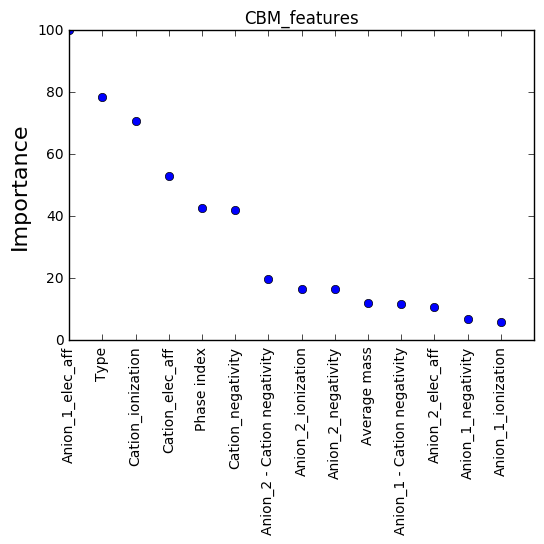

In [308]:
plt_feature_importance(obt_feature_importance_2.feature_importances_,all_select_features,'CBM_features')

In [243]:
#all_select_features.info()
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(2,12,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=10)
rfr_grid.fit(all_select_features_cbm,all_select_target_cbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [246]:
obt_feature_importance=RandomForestRegressor(min_samples_leaf=2,max_features=10)

In [247]:
obt_feature_importance.fit(all_select_features_cbm,all_select_target_cbm)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [248]:
obt_feature_importance.feature_importances_

array([  8.35888581e-01,   4.99342914e-02,   6.00258155e-04,
         1.14077777e-02,   1.74050191e-02,   6.74887954e-03,
         3.00532323e-03,   2.06296264e-03,   1.36296908e-02,
         7.82721631e-04,   9.44303131e-03,   5.90106167e-03,
         1.06999825e-02,   3.19171357e-02,   5.73283717e-04])

In [259]:
xlabels_cbm = list(all_select_features_cbm.columns)

In [262]:
importance_cbm = list(obt_feature_importance.feature_importances_)

In [267]:
max_val_cbm=max(importance_cbm)

In [273]:
key_import = list(zip(xlabels_cbm,importance_cbm))

In [258]:
#list(zip(list(all_select_features_cbm.columns),list(obt_feature_importance.feature_importances_))).sort(key=lambda x:x[1])

In [275]:
key_import.sort(key=lambda x:x[1],reverse=True)

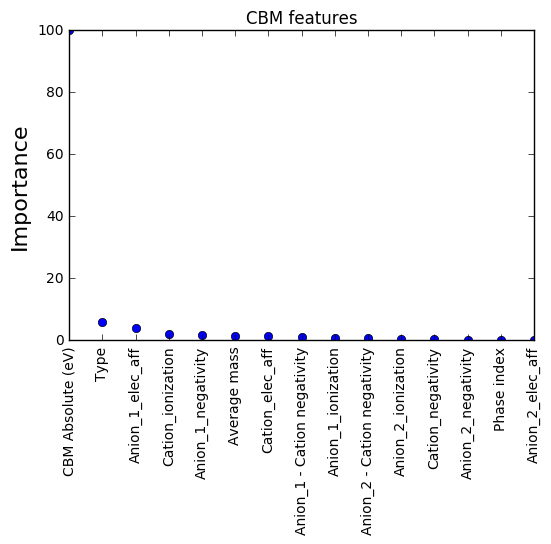

In [298]:
plt.plot([i for i in range(0,15)],[key_import[i][1]/max_val_cbm*100 for i in range(0,15)],'o')
labels=[key_import[i][0] for i in range(0,15)]
plt.xticks([i for i in range(0,15)],labels,rotation=90)
plt.title('CBM features')
plt.ylabel('Importance',fontsize=16)

In [299]:
#all_select_features_cbm.head()

In [304]:
def plt_feature_importance(feature_importance,df_feature,title):
    labels = list(df_feature.columns)
    labels_len = len(labels)
    #xlabels_cbm = list(all_select_features_cbm.columns)
    importance = list(feature_importance)
    max_val_cbm=max(importance)
    key_import = list(zip(labels,importance))
    key_import.sort(key=lambda x:x[1],reverse=True)
    plt.plot([i for i in range(0,labels_len)],[key_import[i][1]/max_val_cbm*100 for i in range(0,labels_len)],'o')
    labels=[key_import[i][0] for i in range(0,labels_len)]
    plt.xticks([i for i in range(0,labels_len)],labels,rotation=90)
    plt.title(title)
    plt.ylabel('Importance',fontsize=16)

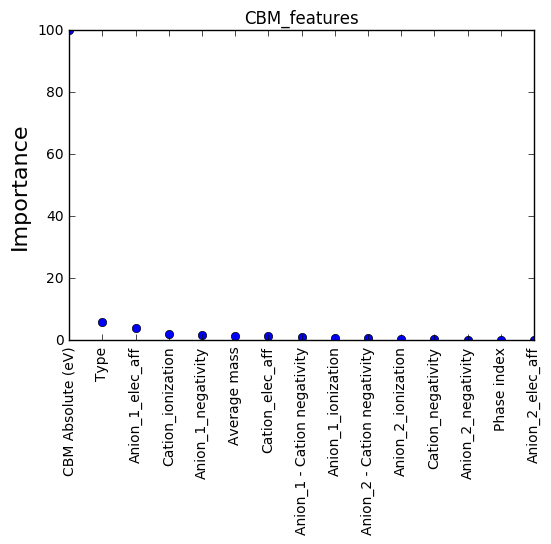

In [305]:
plt_feature_importance(obt_feature_importance.feature_importances_,all_select_features_cbm,'CBM_features')

In [245]:
(rfr_grid.best_params_,rfr_grid.best_score_)

({'max_features': 10, 'min_samples_leaf': 2}, 0.9040823204917706)

In [251]:
rfr_predicted_cbm_2=cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=11),all_select_features_cbm,all_select_target_cbm,cv=10)

In [252]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,RandomForestRegressor(min_samples_leaf=2,max_features=11),max_round=100)

(0.5106696149856853, 0.08075096909114293, 0.17570752252270047)

In [253]:
mape_train_test(all_select_features_cbm,all_select_target_cbm,RandomForestRegressor(min_samples_leaf=2,max_features=11),max_round=100)

(7.5463737689962294, 1.0939253023777014, 2.6444307272083769)

___
### Support vector machine
___

### VBM: SVR

In [319]:
from sklearn.svm import SVR

In [777]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-2, 2, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features,all_select_target_vbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.42510e-01,   2.03092e-01,   2.89427e-01,
         4.12463e-01,   5.87802e-01,   8.37678e-01,   1.19378e+00,
         1.70125e+00,   2.42446e+00,   3.45511e+00,   4.92388e+00,
         7.01704e+00,   1.00000e+01,   1.42510e+01,   2.03092e+01,
         2.8942...,   1.70125e+02,   2.42446e+02,
         3.45511e+02,   4.92388e+02,   7.01704e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [317]:
"""
old:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)
({'C': 7.0170382867038299, 'gamma': 0.41246263829013524}, 0.7573496365420076)
"""

"\nold:\n(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)\n({'C': 7.0170382867038299, 'gamma': 0.41246263829013524}, 0.7573496365420076)\n"

In [320]:
svr_predicted_vbm = cross_val_predict(SVR(C=7.0170382867038299,gamma=0.412),all_select_features,all_select_target_vbm,cv=10)

In [321]:
rmse_train_test(all_select_features,all_select_target_vbm,SVR(C=7.0170382867038299,gamma=0.412),max_round=100)

(0.8136029853884451, 0.22997286644170875, 0.49208754021419115)

In [322]:
mape_train_test(all_select_features,all_select_target_vbm,SVR(C=7.0170382867038299,gamma=0.412),max_round=100)

(8.6153312089319627, 2.4562104039577473, 4.830116209668069)

In [780]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-2, 2, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features_vbm,all_select_target_vbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.62378e-01,   2.63665e-01,   4.28133e-01,
         6.95193e-01,   1.12884e+00,   1.83298e+00,   2.97635e+00,
         4.83293e+00,   7.84760e+00,   1.27427e+01,   2.06914e+01,
         3.35982e+01,   5.45559e+01,   8.85867e+01,   1.43845e+02,
         2.3357...,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [781]:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)

({'C': 1000.0, 'gamma': 0.016237767391887217}, 0.9936654110005034)

In [323]:
svr_predicted_vbm_2=cross_val_predict(SVR(C=1000,gamma=0.016237767391887217),all_select_features_vbm,all_select_target_vbm,cv=10)

In [324]:
rmse_train_test(all_select_features_vbm,all_select_target_vbm,SVR(C=1000,gamma=0.016237767391887217),max_round=100)

(0.12109331492211832, 0.05747872872427437, 0.0832594891259004)

In [325]:
mape_train_test(all_select_features_vbm,all_select_target_vbm,SVR(C=1000,gamma=0.016237767391887217),max_round=100)

(1.5978904084492815, 0.679299321296153, 0.96218875657589531)

___
### SVR: CBM
___

In [784]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-2, 2, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features,all_select_target_cbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.62378e-01,   2.63665e-01,   4.28133e-01,
         6.95193e-01,   1.12884e+00,   1.83298e+00,   2.97635e+00,
         4.83293e+00,   7.84760e+00,   1.27427e+01,   2.06914e+01,
         3.35982e+01,   5.45559e+01,   8.85867e+01,   1.43845e+02,
         2.3357...,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [785]:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)

({'C': 12.742749857031335, 'gamma': 0.48329302385717521}, 0.23102772927298384)

In [326]:
svr_predicted_cbm = cross_val_predict(SVR(C=12.742749857031335,gamma=0.48329302385717521),all_select_features,all_select_target_cbm,cv=10)

In [327]:
rmse_train_test(all_select_features,all_select_target_cbm,SVR(C=12.742749857031335,gamma=0.48329302385717521),max_round=100)

(0.6883650685152537, 0.1935086425563731, 0.4275798094816843)

In [328]:
mape_train_test(all_select_features,all_select_target_cbm,SVR(C=12.742749857031335,gamma=0.48329302385717521),max_round=100)

(13.740983998319441, 3.8045609674713683, 7.0742245997651638)

In [787]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-2, 2, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features_cbm,all_select_target_cbm)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.62378e-01,   2.63665e-01,   4.28133e-01,
         6.95193e-01,   1.12884e+00,   1.83298e+00,   2.97635e+00,
         4.83293e+00,   7.84760e+00,   1.27427e+01,   2.06914e+01,
         3.35982e+01,   5.45559e+01,   8.85867e+01,   1.43845e+02,
         2.3357...,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [788]:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)

({'C': 143.8449888287663, 'gamma': 0.01}, 0.9795552002253924)

In [329]:
svr_predicted_cbm_2 = cross_val_predict(SVR(C=143.8449888287663,gamma=0.01),all_select_features_cbm,all_select_target_cbm,cv=10)

In [330]:
rmse_train_test(all_select_features_cbm,all_select_target_cbm,SVR(C=143.8449888287663,gamma=0.01),max_round=100)

(0.1891739375008763, 0.05498744211149593, 0.0910865106072017)

In [331]:
mape_train_test(all_select_features_cbm,all_select_target_cbm,SVR(C=143.8449888287663,gamma=0.01),max_round=100)

(2.3166798578763981, 1.1563337233949844, 1.652436839876648)

___
### SVR: Gap
___

In [791]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-2, 2, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features,all_select_target_gap)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.62378e-01,   2.63665e-01,   4.28133e-01,
         6.95193e-01,   1.12884e+00,   1.83298e+00,   2.97635e+00,
         4.83293e+00,   7.84760e+00,   1.27427e+01,   2.06914e+01,
         3.35982e+01,   5.45559e+01,   8.85867e+01,   1.43845e+02,
         2.3357...,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [792]:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)

({'C': 12.742749857031335, 'gamma': 1.2742749857031335}, 0.5036656253343015)

In [332]:
svr_predicted_gap = cross_val_predict(SVR(C=12.742749857031335,gamma=1.2742749857031335),all_select_features,all_select_target_gap,cv=10)

In [333]:
rmse_train_test(all_select_features,all_select_target_gap,SVR(C=12.742749857031335,gamma=1.2742749857031335),max_round=100)

(1.2848749234766843, 0.24281719595777296, 0.5652322126974426)

In [334]:
mape_train_test(all_select_features,all_select_target_gap,SVR(C=12.742749857031335,gamma=1.2742749857031335),max_round=100)

(36.58379577522637, 8.9159622313829807, 16.80547045808839)

In [797]:
C_range = np.logspace(-1, 3, 20)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-3, 1, 20)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=10,
                   param_grid=param_grid)
svr_rbf_gcv.fit(all_select_features_gap,all_select_target_gap)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-01,   1.62378e-01,   2.63665e-01,   4.28133e-01,
         6.95193e-01,   1.12884e+00,   1.83298e+00,   2.97635e+00,
         4.83293e+00,   7.84760e+00,   1.27427e+01,   2.06914e+01,
         3.35982e+01,   5.45559e+01,   8.85867e+01,   1.43845e+02,
         2.3357...,   8.85867e-01,   1.43845e+00,
         2.33572e+00,   3.79269e+00,   6.15848e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [798]:
(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)

({'C': 615.84821106602612, 'gamma': 0.011288378916846888}, 0.9594345116413612)

In [335]:
svr_predicted_gap_2 = cross_val_predict(SVR(C=615.84821106602612,gamma=0.0113),all_select_features_gap,all_select_target_gap,cv=10)

In [336]:
rmse_train_test(all_select_features_gap,all_select_target_gap,SVR(C=615.84821106602612,gamma=0.0113),max_round=100)

(0.2526258775008044, 0.06296359615257546, 0.13322425553269468)

In [337]:
mape_train_test(all_select_features_gap,all_select_target_gap,SVR(C=615.84821106602612,gamma=0.0113),max_round=100)

(8.5600948432399129, 2.6253017336821634, 4.9282760850903085)

___

In [279]:
def gap_group_plot(ax,pred_gap,hse_gap,title):
    ax.plot(hse_gap,pred_gap,'o',ms=4,color='#3498db')
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_title(title,size=16)
    ax.set_xlabel('HSE gap (eV)',fontsize=14)
    ax.set_ylabel('Predicted gap (eV)',fontsize=14)
    ax.plot([0,10],[0,10],'-.')

In [275]:
def vbm_group_plot(ax,pred_edge,hse_edge):
    ax.plot(hse_edge,pred_edge,'o',ms=4,color='#3498db')
    ax.set_xlim(-10,0)
    ax.set_ylim(-10,0)
    ax.set_xlabel('HSE VBM (eV)',fontsize=14)
    ax.set_ylabel('Predicted VBM (eV)',fontsize=14)
    ax.plot([-10,0],[-10,0],'-.')
    #ax.set_title(title)

In [276]:
def cbm_group_plot(ax,pred_edge,hse_edge):
    ax.plot(hse_edge,pred_edge,'o',ms=4,color='#3498db')
    ax.set_xlim(-10,0)
    ax.set_ylim(-10,0)
    ax.set_xlabel('HSE CBM (eV)',fontsize=14)
    ax.set_ylabel('Predicted CBM (eV)',fontsize=14)
    ax.plot([-10,0],[-10,0],'-.')

In [277]:
pred_gaps = [lm_predicted_gap,rfr_predicted_gap,svr_predicted_gap]
pred_vbms = [lm_predicted_vbm,rfr_predicted_vbm,svr_predicted_vbm]
pred_cbms = [lm_predicted_cbm,rfr_predicted_cbm,svr_predicted_cbm]
titles = ['LR','RFR','SVR']

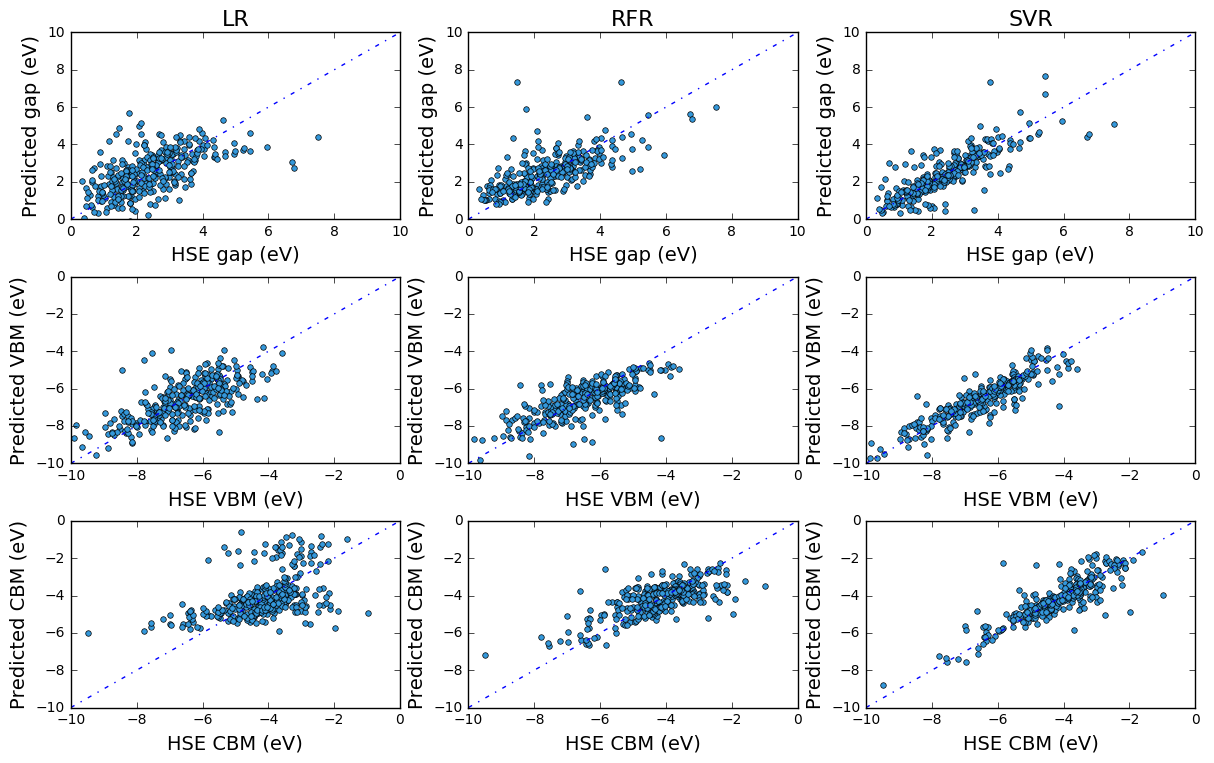

In [280]:
fig, axes = plt.subplots(3,3,figsize=(12,7.5))
for i in range(3):
    gap_group_plot(axes[0][i],pred_gaps[i],all_select_target_gap,titles[i])
for i in range(3):
    vbm_group_plot(axes[1][i],pred_vbms[i],all_select_target_vbm)
for i in range(3):
    cbm_group_plot(axes[2][i],pred_cbms[i],all_select_target_cbm)
fig.tight_layout(rect=[0,0,1,1],pad=0.2)

In [281]:
pred_gaps_2 = [lm_predicted_gap_2,rfr_predicted_gap_2,svr_predicted_gap_2]
pred_vbms_2 = [lm_predicted_vbm_2,rfr_predicted_vbm_2,svr_predicted_vbm_2]
pred_cbms_2 = [lm_predicted_cbm_2,rfr_predicted_cbm_2,svr_predicted_cbm_2]
titles = ['LR','RFR','SVR']

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9,7.5))
for i in range(3):
    gap_group_plot(axes[0][i],pred_gaps_2[i],all_select_target_gap,titles[i])
for i in range(3):
    vbm_group_plot(axes[1][i],pred_vbms_2[i],all_select_target_vbm)
for i in range(3):
    cbm_group_plot(axes[2][i],pred_cbms_2[i],all_select_target_cbm)
fig.tight_layout(rect=[0,0,1,1],pad=0.2)

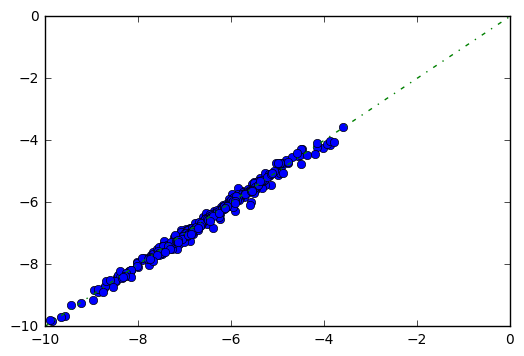

In [691]:
plt.plot(all_select_target_vbm,predicted_vbm_simple,'o')
plt.xlim(-10,0)
plt.ylim(-10,0)
plt.plot([-10,0],[-10,0],'-.')

In [676]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [674]:
opt_model_VBM_lassoCV = LassoCV(cv=5).fit(all_select_features,all_select_target_vbm)

In [675]:
opt_model_VBM_lassoCV.alpha_

0.041195143089795723

In [678]:
lm_lasso_vbm = Lasso(alpha=0.041195143089795723)

In [679]:
predicted_vbm=cross_val_predict(lm_lasso_vbm,all_select_features,all_select_target_vbm,cv=10)

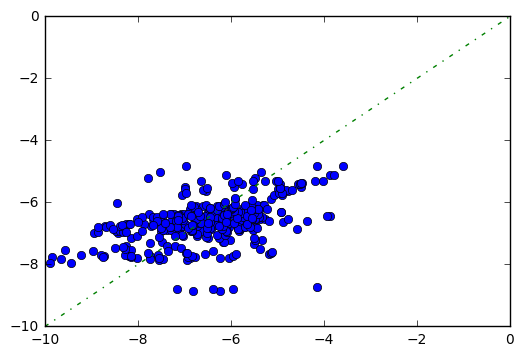

In [684]:
plt.plot(all_select_target_vbm,predicted_vbm,'o')
plt.xlim(-10,0)
plt.ylim(-10,0)
plt.plot([-10,0],[-10,0],'-.')

___

___
## Section 2: Screening 2D materials suitable for water splitting
___

### Section 2.1: Band edge trend (VBM and CBM)
___

In [1284]:
#
# E_red (H+/H2) = -4.44 + pH * 0.059
# E_ox (O2/H2O) = -5.67 + pH * 0.059
#
"""
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(109),ternary_info['HSE-VBM Absolute (eV)'],'o')
ax.plot(np.arange(109),ternary_info['HSE-CBM Absolute (eV)'],'^')
ax.set_xlim(0,108)
ax.set_ylim(-10,-2)
ax.plot(np.arange(109),[-4.44]*109,'-r')
ax.plot(np.arange(109),[-5.67]*109,'-r')
ax.plot(np.arange(109),[-4.02]*109,'-.r')
ax.plot(np.arange(109),[-5.257]*109,'-.r')
ax.set_xticks(np.arange(108))
ax.set_xticklabels(ternary_info['Phase'],rotation=90,fontsize=8)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Energy (eV)',fontsize = 15)
"""

"\nfig, ax = plt.subplots(figsize=(15,5))\nax.plot(np.arange(109),ternary_info['HSE-VBM Absolute (eV)'],'o')\nax.plot(np.arange(109),ternary_info['HSE-CBM Absolute (eV)'],'^')\nax.set_xlim(0,108)\nax.set_ylim(-10,-2)\nax.plot(np.arange(109),[-4.44]*109,'-r')\nax.plot(np.arange(109),[-5.67]*109,'-r')\nax.plot(np.arange(109),[-4.02]*109,'-.r')\nax.plot(np.arange(109),[-5.257]*109,'-.r')\nax.set_xticks(np.arange(108))\nax.set_xticklabels(ternary_info['Phase'],rotation=90,fontsize=8)\nax.set_xlabel('2D Compounds',fontsize = 15)\nax.set_ylabel('Energy (eV)',fontsize = 15)\n"

In [2320]:
def plot_bandedge_compound(ax,data_frame,xrange,yrange,phase):
    ax.plot(np.arange(xrange+1),data_frame['HSE-VBM Absolute (eV)'],'o-.')
    ax.plot(np.arange(xrange+1),data_frame['HSE-CBM Absolute (eV)'],'^-')
    ax.set_xlim(0,xrange)
    ax.set_ylim(yrange)
    #ax.plot(np.arange(xrange+1),[-4.44]*(xrange+1),'-.r')
    #ax.plot(np.arange(xrange+1),[-5.67]*(xrange+1),'-.r')
    #ax.plot(np.arange(xrange+1),[-4.02]*(xrange+1),'-.g')
    #ax.plot(np.arange(xrange+1),[-5.257]*(xrange+1),'-.g')
    ax.set_xticks(np.arange(xrange+1))
    ax.set_xticklabels(data_frame['Compound'],rotation=90,fontsize=10)
    #ax.set_xlabel('2D III-VI-VII '+phase,fontsize = 15)
    ax.set_ylabel('Energy (eV)',fontsize = 15)
    plt.text(0.85, 0.85,'2D III-VI-VII '+phase, ha='center', va='center', transform=ax.transAxes,fontsize=14)
    #ax.set_title('2D III-VI-VII: '+phase,fontsize=20)

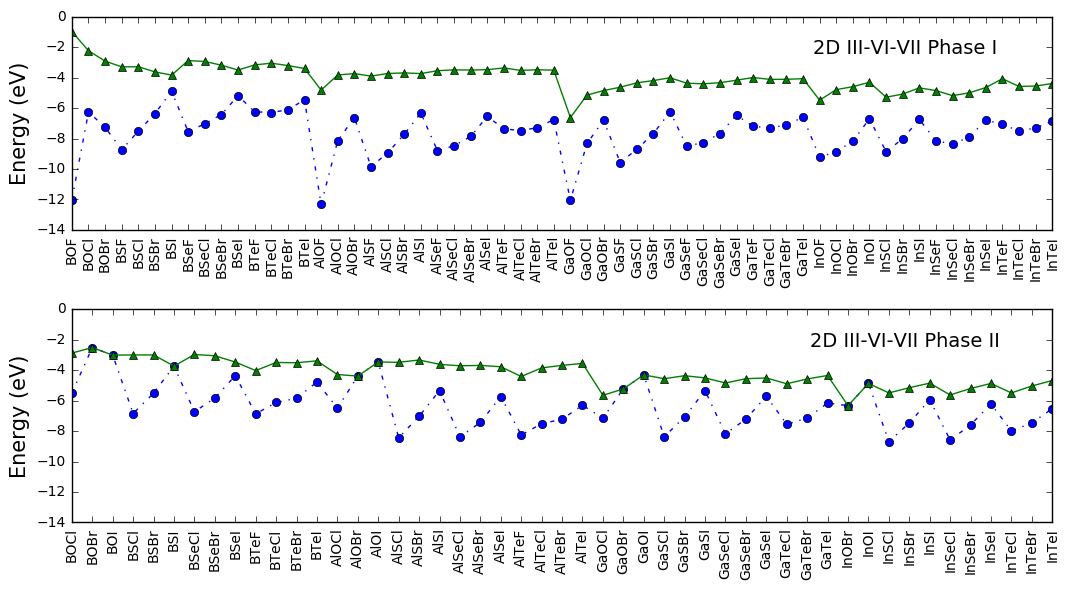

In [2321]:
fig, axes = plt.subplots(2,1,figsize=(12,6))
xranges=[59,48]
yranges=[[-14,0],[-14,0]]
data_frames = [ternary_phase_one,ternary_phase_two]
phases=['Phase I','Phase II']
for i in range(2):
    plot_bandedge_compound(axes[i],data_frames[i],xranges[i],yranges[i],phases[i])
fig.tight_layout(rect=[0,0,0.9,1])

In [1336]:
"""
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(60),ternary_phase_one['HSE-VBM Absolute (eV)'],'o-')
ax.plot(np.arange(60),ternary_phase_one['HSE-CBM Absolute (eV)'],'^-')
ax.set_xlim(0,59)
ax.set_ylim(-14,-2)
ax.plot(np.arange(60),[-4.44]*60,'-r')
ax.plot(np.arange(60),[-5.67]*60,'-r')
ax.plot(np.arange(60),[-4.02]*60,'-.r')
ax.plot(np.arange(60),[-5.257]*60,'-.r')
ax.set_xticks(np.arange(60))
ax.set_xticklabels(ternary_phase_one['Compound'],rotation=90,fontsize=12)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Energy (eV)',fontsize = 15)
ax.set_title('2D III-VI-VII: Phase I',fontsize=20)
"""

"\nfig, ax = plt.subplots(figsize=(15,5))\nax.plot(np.arange(60),ternary_phase_one['HSE-VBM Absolute (eV)'],'o-')\nax.plot(np.arange(60),ternary_phase_one['HSE-CBM Absolute (eV)'],'^-')\nax.set_xlim(0,59)\nax.set_ylim(-14,-2)\nax.plot(np.arange(60),[-4.44]*60,'-r')\nax.plot(np.arange(60),[-5.67]*60,'-r')\nax.plot(np.arange(60),[-4.02]*60,'-.r')\nax.plot(np.arange(60),[-5.257]*60,'-.r')\nax.set_xticks(np.arange(60))\nax.set_xticklabels(ternary_phase_one['Compound'],rotation=90,fontsize=12)\nax.set_xlabel('2D Compounds',fontsize = 15)\nax.set_ylabel('Energy (eV)',fontsize = 15)\nax.set_title('2D III-VI-VII: Phase I',fontsize=20)\n"

In [1266]:
#ternary_phase_two.info()

In [1267]:
#ternary_phase_two['Compound']=ternary_phase_two['Phase'].map(lambda x:x.split('_')[0])

In [1337]:
"""
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(49),ternary_phase_two['HSE-VBM Absolute (eV)'],'o-')
ax.plot(np.arange(49),ternary_phase_two['HSE-CBM Absolute (eV)'],'^-')
ax.set_xlim(0,48)
ax.set_ylim(-10,-2)
ax.plot(np.arange(49),[-4.44]*49,'-r')
ax.plot(np.arange(49),[-5.67]*49,'-r')
ax.plot(np.arange(49),[-4.02]*49,'-.r')
ax.plot(np.arange(49),[-5.257]*49,'-.r')
ax.set_xticks(np.arange(49))
ax.set_xticklabels(ternary_phase_two['Compound'],rotation=90,fontsize=12)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Energy (eV)',fontsize = 15)
ax.set_title('2D III-VI-VII: Phase II',fontsize=20)
"""

"\nfig, ax = plt.subplots(figsize=(15,5))\nax.plot(np.arange(49),ternary_phase_two['HSE-VBM Absolute (eV)'],'o-')\nax.plot(np.arange(49),ternary_phase_two['HSE-CBM Absolute (eV)'],'^-')\nax.set_xlim(0,48)\nax.set_ylim(-10,-2)\nax.plot(np.arange(49),[-4.44]*49,'-r')\nax.plot(np.arange(49),[-5.67]*49,'-r')\nax.plot(np.arange(49),[-4.02]*49,'-.r')\nax.plot(np.arange(49),[-5.257]*49,'-.r')\nax.set_xticks(np.arange(49))\nax.set_xticklabels(ternary_phase_two['Compound'],rotation=90,fontsize=12)\nax.set_xlabel('2D Compounds',fontsize = 15)\nax.set_ylabel('Energy (eV)',fontsize = 15)\nax.set_title('2D III-VI-VII: Phase II',fontsize=20)\n"

In [1268]:
#np.arange(60)

In [1269]:
#ternary_phase_one.info()

In [1208]:
#
# we can manupulate the data_frame
#
#ternary_water_splitting=ternary_info[(ternary_info['HSE-VBM Absolute (eV)']<-5.67) & (ternary_info['HSE-gap (eV)']<3.5) & (ternary_info['HSE-CBM Absolute (eV)']>-4.44)]

In [1209]:
#ternary_water_splitting.reset_index(inplace=True)

In [1217]:
#ternary_water_splitting['Phase']

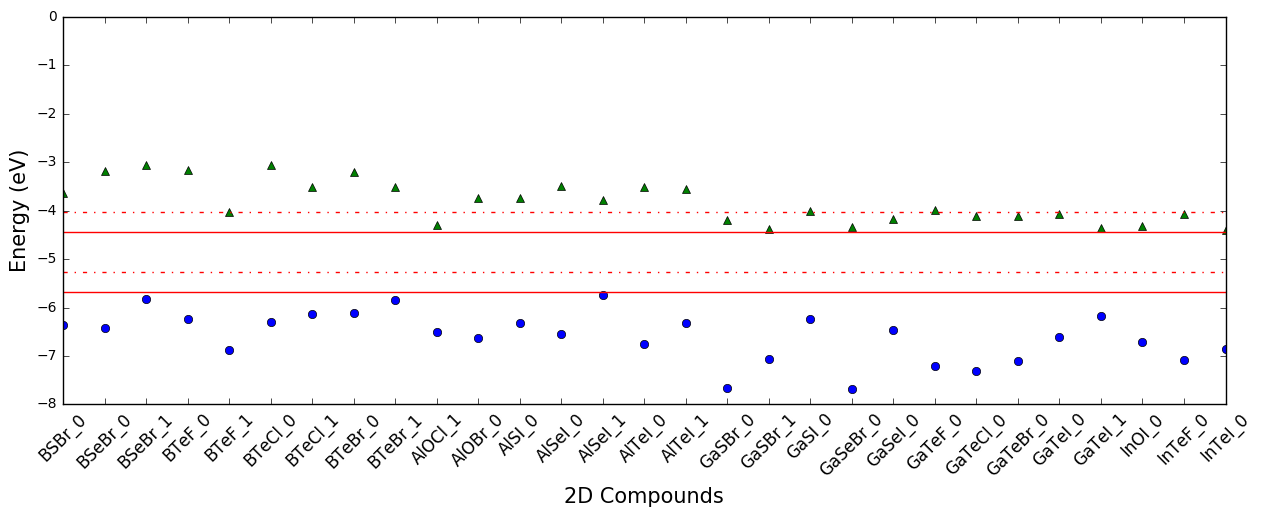

In [1338]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(29),ternary_water_splitting['HSE-VBM Absolute (eV)'],'o')
ax.plot(np.arange(29),ternary_water_splitting['HSE-CBM Absolute (eV)'],'^')
ax.set_xlim(0,28)
ax.set_ylim(-8,0)
ax.plot(np.arange(29),[-4.44]*29,'-r')
ax.plot(np.arange(29),[-5.67]*29,'-r')
ax.plot(np.arange(29),[-4.02]*29,'-.r')
ax.plot(np.arange(29),[-5.257]*29,'-.r')
ax.set_xticks(np.arange(29))
ax.set_xticklabels(ternary_water_splitting['Phase'],rotation=45,fontsize=12)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Energy (eV)',fontsize = 15)
#plt.axes().set_aspect(aspect = 2)
#plt.figure(figsize=(40,10))

In [417]:
#np.arange(0,100)

___
## Section 3: Band gap trend
___

### Section 3.1: How band gap changes with respect to the elements?

In [484]:
#ternary_info.info()

In [540]:
# phase 0
#ternary_phase1=ternary_info[ternary_info['Phase_index']==0][['Phase','Band gap (eV)','HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)','Cation','Anion_1','Anion_2','Cation_negativity','Anion_1_negativity','Anion_2_negativity','Cation_mass','Anion_1_mass','Anion_2_mass','a1 (A)','a2 (A)','a3 (A)']]

In [541]:
#ternary_phase1['HSE-gap (eV)']=ternary_phase1['HSE-gap (eV)'].map(lambda x:int(x*100+0.5)*1.0/100)

In [542]:
#ternary_phase1['Band gap (eV)']=ternary_phase1['Band gap (eV)'].map(lambda x:int(x*100+0.5)*1.0/100)

In [499]:
#ternary_phase1.drop('index',axis=1,inplace=True)

In [543]:
element_row_index={'B':2,'Al':3,'Ga':4,'In':5,'O':2,'S':3,'Se':4,'Te':5,'F':2,'Cl':3,'Br':4,'I':5}

In [544]:
#element_label_list = ['Cation','Anion_1','Anion_2']
for element_label in element_label_list:
    ternary_phase1[element_label+'_row_index']=ternary_phase1[element_label].map(lambda x: element_row_index[x])

In [606]:
#ternary_phase1

In [546]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#surf = ax.plot_surface(ternary_phase1[ternary_phase1['Anion_2_row_index']==2]['Cation_row_index'],ternary_phase1[ternary_phase1['Anion_2_row_index']==2]['Anion_1_row_index'],ternary_phase1[ternary_phase1['Anion_2_row_index']==2]['Band gap (eV)'], rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
#fig.colorbar(surf)

In [2432]:
ternary_info['Average mass']=ternary_info['Cation_mass']+ternary_info['Anion_1_mass']+ternary_info['Anion_2_mass']

In [2434]:
#ternary_info['Average mass']=ternary_info['Average mass'].map(lambda x:x*1.0/3.0)

___
### Check average mass as the descriptor of Band gap
___

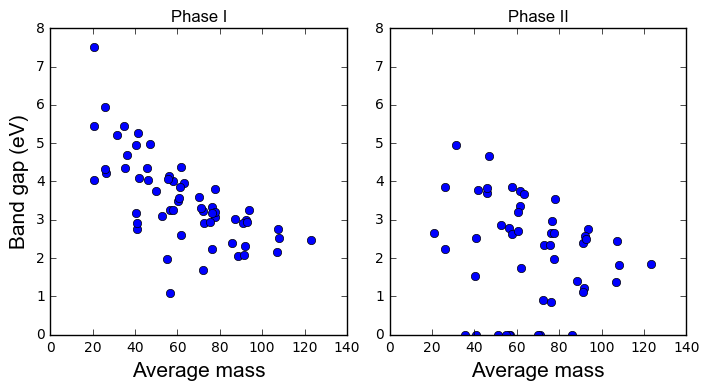

In [2466]:
hfont = {'fontname':'Arial'}
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(ternary_info[ternary_info['Phase_index']==0]['Average mass'],ternary_info[ternary_info['Phase_index']==0]['HSE-gap (eV)'],'o')
axes[0].set_ylim(0,8)
#plt.axes().set_aspect('equal')
axes[0].set_xlabel('Average mass',fontsize=15,**hfont)
axes[0].set_ylabel('Band gap (eV)',fontsize=15,**hfont)
axes[0].set_title('Phase I',**hfont)
axes[0].set_xlim(0,140)
axes[1].plot(ternary_info[ternary_info['Phase_index']==1]['Average mass'],ternary_info[ternary_info['Phase_index']==1]['HSE-gap (eV)'],'o')
axes[1].set_ylim(0,8)
#plt.axes().set_aspect('equal')
axes[1].set_xlabel('Average mass',fontsize=15,**hfont)
#axes[1].set_ylabel('Band gap (eV)',fontsize=15)
axes[1].set_title('Phase II',**hfont)
axes[1].set_xlim(0,140)
fig.tight_layout(rect=[0,0,0.9,1])

In [2449]:
#ternary_phase_one.info()

In [1312]:
def plot_gap_compound(ax,data_frame,xrange,yrange,phase):
    ax.plot(np.arange(xrange+1),data_frame['HSE-gap (eV)'],'o-.')
    #ax.plot(np.arange(60),ternary_phase_one['HSE-CBM Absolute (eV)'],'^-')
    ax.set_xlim(0,xrange)
    ax.set_ylim(0,yrange)
    #ax.plot(np.arange(60),[-4.44]*60,'-r')
    #ax.plot(np.arange(60),[-5.67]*60,'-r')
    #ax.plot(np.arange(60),[-4.02]*60,'-.r')
    #ax.plot(np.arange(60),[-5.257]*60,'-.r')
    ax.set_xticks(np.arange(xrange+1))
    ax.set_xticklabels(data_frame['Compound'],rotation=90,fontsize=10)
    #ax.set_xlabel('2D III-VI-VII '+phase,fontsize = 15)
    ax.set_ylabel('Band gap (eV)',fontsize = 15)
    plt.text(0.8, 0.8,'2D III-VI-VII '+phase, ha='center', va='center', transform=ax.transAxes,fontsize=14)
    #ax.set_title('2D III-VI-VII: '+phase,fontsize=20)

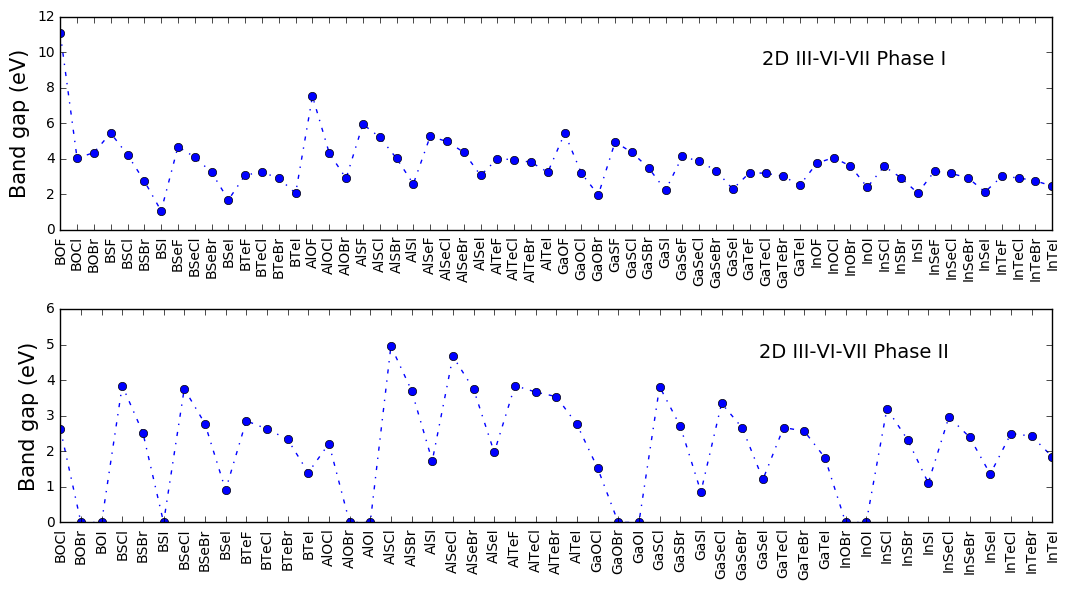

In [1313]:
fig, axes = plt.subplots(2,1,figsize=(12,6))
xranges=[59,48]
yranges=[12,6]
data_frames = [ternary_phase_one,ternary_phase_two]
phases=['Phase I','Phase II']
for i in range(2):
    plot_gap_compound(axes[i],data_frames[i],xranges[i],yranges[i],phases[i])
fig.tight_layout(rect=[0,0,0.9,1])

In [1314]:
"""
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(60),ternary_phase_one['HSE-gap (eV)'],'o-')
#ax.plot(np.arange(60),ternary_phase_one['HSE-CBM Absolute (eV)'],'^-')
ax.set_xlim(0,59)
ax.set_ylim(0,12)
#ax.plot(np.arange(60),[-4.44]*60,'-r')
#ax.plot(np.arange(60),[-5.67]*60,'-r')
#ax.plot(np.arange(60),[-4.02]*60,'-.r')
#ax.plot(np.arange(60),[-5.257]*60,'-.r')
ax.set_xticks(np.arange(60))
ax.set_xticklabels(ternary_phase_one['Compound'],rotation=90,fontsize=10)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Band gap (eV)',fontsize = 15)
ax.set_title('2D III-VI-VII: Phase I',fontsize=20)
"""

"\nfig, ax = plt.subplots(figsize=(12,4))\nax.plot(np.arange(60),ternary_phase_one['HSE-gap (eV)'],'o-')\n#ax.plot(np.arange(60),ternary_phase_one['HSE-CBM Absolute (eV)'],'^-')\nax.set_xlim(0,59)\nax.set_ylim(0,12)\n#ax.plot(np.arange(60),[-4.44]*60,'-r')\n#ax.plot(np.arange(60),[-5.67]*60,'-r')\n#ax.plot(np.arange(60),[-4.02]*60,'-.r')\n#ax.plot(np.arange(60),[-5.257]*60,'-.r')\nax.set_xticks(np.arange(60))\nax.set_xticklabels(ternary_phase_one['Compound'],rotation=90,fontsize=10)\nax.set_xlabel('2D Compounds',fontsize = 15)\nax.set_ylabel('Band gap (eV)',fontsize = 15)\nax.set_title('2D III-VI-VII: Phase I',fontsize=20)\n"

In [1315]:
"""
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(49),ternary_phase_two['HSE-gap (eV)'],'o-')
#ax.plot(np.arange(49),ternary_phase_two['HSE-CBM Absolute (eV)'],'^-')
ax.set_xlim(0,48)
ax.set_ylim(0,6)
#ax.plot(np.arange(49),[-4.44]*49,'-r')
#ax.plot(np.arange(49),[-5.67]*49,'-r')
#ax.plot(np.arange(49),[-4.02]*49,'-.r')
#ax.plot(np.arange(49),[-5.257]*49,'-.r')
ax.set_xticks(np.arange(49))
ax.set_xticklabels(ternary_phase_two['Compound'],rotation=90,fontsize=10)
ax.set_xlabel('2D Compounds',fontsize = 15)
ax.set_ylabel('Band gap (eV)',fontsize = 15)
ax.set_title('2D III-VI-VII: Phase II',fontsize=20)
"""

"\nfig, ax = plt.subplots(figsize=(12,4))\nax.plot(np.arange(49),ternary_phase_two['HSE-gap (eV)'],'o-')\n#ax.plot(np.arange(49),ternary_phase_two['HSE-CBM Absolute (eV)'],'^-')\nax.set_xlim(0,48)\nax.set_ylim(0,6)\n#ax.plot(np.arange(49),[-4.44]*49,'-r')\n#ax.plot(np.arange(49),[-5.67]*49,'-r')\n#ax.plot(np.arange(49),[-4.02]*49,'-.r')\n#ax.plot(np.arange(49),[-5.257]*49,'-.r')\nax.set_xticks(np.arange(49))\nax.set_xticklabels(ternary_phase_two['Compound'],rotation=90,fontsize=10)\nax.set_xlabel('2D Compounds',fontsize = 15)\nax.set_ylabel('Band gap (eV)',fontsize = 15)\nax.set_title('2D III-VI-VII: Phase II',fontsize=20)\n"

In [669]:
def heatmap_compounds(anion_label,anion_index,plot_labels,ternary_phase1,v_min=0,v_max=9):
    """
    anion_label: selected anion kept the same in a single subplot
    anion_index: here, ['F','Cl','Br','I']
    plot_labels: [cation,anion_1,band gaps]
    ternary_phase1: the selected data frame
    """
    fig, axes = plt.subplots(2,2,sharex=False,sharey=False)
    cbar_ax = fig.add_axes([.91,.3,.03,.4])
    
    for i, ax in enumerate(axes.flat):
        corr_Anion = ternary_phase1[ternary_phase1[anion_label]==anion_index[i]][plot_labels]
        result = corr_Anion.pivot(index=plot_labels[0], columns=plot_labels[1], values=plot_labels[2])
        sns.heatmap(result,ax=ax,cbar=i==0,cbar_ax=None if i else cbar_ax,annot=True, fmt="g",vmin=v_min,vmax=v_max,cmap='YlGnBu',yticklabels=['B','Al','Ga','In'],xticklabels=['O','S','Se','Te'])
        ax.set_title('CA'+anion_index[i]+' Band gaps (eV)')
        #plt.yticks([2,3,4,5],['B','Al','Ga','In'])
    fig.tight_layout(rect=[0,0,0.9,1])
    #plt.setp(axes,yticks=[0.5,1.5,2.5,3.5],yticklabels=['In','Ga','Al','B'],xticks=[0.5,1.5,2.5,3.5],xticklabels=['O','S','Se','Te'])

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


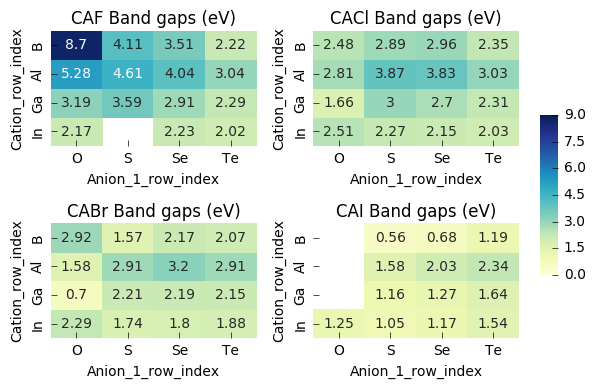

In [670]:
#
# heapmap plot for phase 1: PBE band gaps
#
heatmap_compounds('Anion_2',['F','Cl','Br','I'],['Cation_row_index','Anion_1_row_index','Band gap (eV)'],ternary_phase1)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


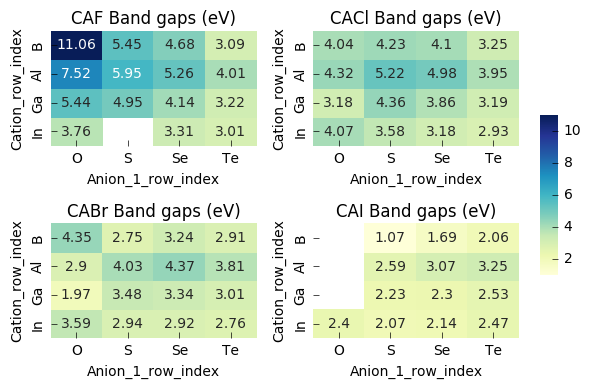

In [671]:
heatmap_compounds('Anion_2',['F','Cl','Br','I'],['Cation_row_index','Anion_1_row_index','HSE-gap (eV)'],ternary_phase1,v_min=1,v_max=11)

In [700]:
ternary_phase2=ternary_info[ternary_info['Phase_index']==1][['Phase','Band gap (eV)','HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)','Cation','Anion_1','Anion_2','Cation_negativity','Anion_1_negativity','Anion_2_negativity','Cation_mass','Anion_1_mass','Anion_2_mass','a1 (A)','a2 (A)','a3 (A)']]

In [701]:
element_row_index={'B':2,'Al':3,'Ga':4,'In':5,'O':2,'S':3,'Se':4,'Te':5,'F':2,'Cl':3,'Br':4,'I':5}

In [702]:
element_label_list = ['Cation','Anion_1','Anion_2']
for element_label in element_label_list:
    ternary_phase2[element_label+'_row_index']=ternary_phase2[element_label].map(lambda x: element_row_index[x])

In [691]:
#test=pd.DataFrame(['InOF_0'], columns=['Phase'])

In [2741]:
#ternary_phase_one

In [707]:
#ternary_phase2.head()

In [705]:
#ternary_phase2['HSE-gap (eV)']=ternary_phase2['HSE-gap (eV)'].map(lambda x:int(x*100+0.5)*1.0/100)

In [706]:
#ternary_phase2['Band gap (eV)']=ternary_phase2['Band gap (eV)'].map(lambda x:int(x*100+0.5)*1.0/100)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


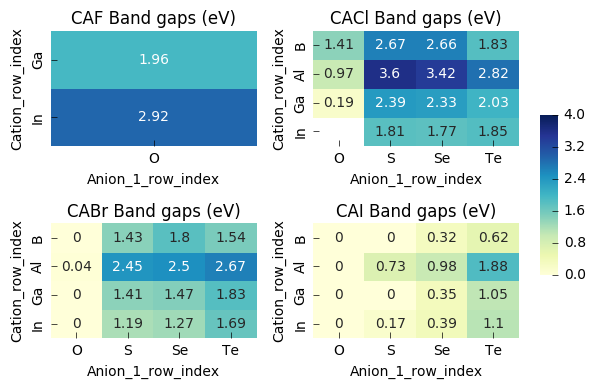

In [694]:
heatmap_compounds('Anion_2',['F','Cl','Br','I'],['Cation_row_index','Anion_1_row_index','Band gap (eV)'],ternary_phase2,v_max=4)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


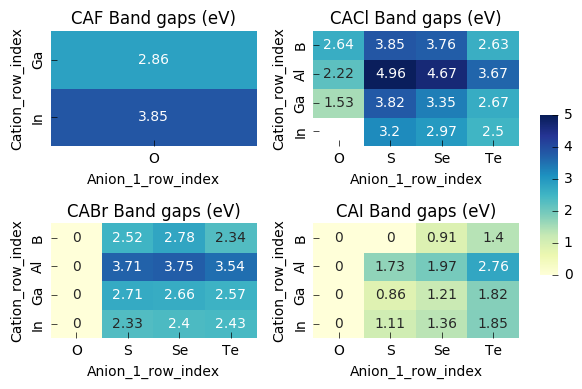

In [673]:
heatmap_compounds('Anion_2',['F','Cl','Br','I'],['Cation_row_index','Anion_1_row_index','HSE-gap (eV)'],ternary_phase2,v_max=5)

### Note: the first subplot of above two figures is wrong. It should be (B,Al)TeF instead.

### ABF compounds

In [689]:
#corr_Anion2_2 = ternary_phase1[ternary_phase1['Anion_2_row_index']==2][['Cation','Anion_1','Band gap (eV)']]
#result = corr_Anion2_2.pivot(index='Cation', columns='Anion_1', values='Band gap (eV)')
#sns.heatmap(result, annot=True, fmt="g", cmap='YlGnBu')

### ABCl compounds

In [688]:
#corr_Anion2_3 = ternary_phase1[ternary_phase1['Anion_2_row_index']==3][['Cation','Anion_1','Band gap (eV)']]
#result_3 = corr_Anion2_3.pivot(index='Cation', columns='Anion_1', values='Band gap (eV)')
#sns.heatmap(result_3, annot=True, fmt="g", cmap='viridis')

### ABBr compunds

In [680]:
#corr_Anion2_4 = ternary_phase1[ternary_phase1['Anion_2_row_index']==4][['Cation','Anion_1','Band gap (eV)']]
#result_4 = corr_Anion2_4.pivot(index='Cation', columns='Anion_1', values='Band gap (eV)')
#sns.heatmap(result_4, annot=True, fmt="g", cmap='viridis')

### ABI compounds

In [677]:
#corr_Anion2_5 = ternary_phase1[ternary_phase1['Anion_2_row_index']==5][['Cation','Anion_1','Band gap (eV)']]
#result_5 = corr_Anion2_5.pivot(index='Cation', columns='Anion_1', values='Band gap (eV)')
#sns.heatmap(result_5, annot=True, fmt="g", cmap='viridis')

___
### Section 3.1.1: Band edge relationshipt
___

In [1065]:
#ternary_phase1['Compound']=ternary_phase1['Phase'].map(lambda x:x.split('_')[0])

In [1067]:
#edge_compare=list(zip(list(ternary_phase1['Compound']),list(ternary_phase1['HSE-VBM Absolute (eV)']),list(ternary_phase1['HSE-CBM Absolute (eV)'])))

In [1070]:
#edge_compare

In [1072]:
matrix = [[0 for _ in range(len(edge_compare))] for _ in range(len(edge_compare))]
for i in range(len(edge_compare)-1):
    for j in range(i+1,len(edge_compare)):
        if (edge_compare[i][1]<=edge_compare[j][1] and edge_compare[i][2]>=edge_compare[j][2]) or (edge_compare[i][1]>=edge_compare[j][1] and edge_compare[i][2]<=edge_compare[j][2]):
            matrix[i][j]=matrix[j][i]=1
        elif (edge_compare[i][1]>=edge_compare[j][1] and edge_compare[i][1]<=edge_compare[j][2]) or (edge_compare[i][2]>=edge_compare[j][1] and edge_compare[i][2]<=edge_compare[j][2]):
            matrix[i][j]=matrix[j][i]=2
        elif edge_compare[i][1]>=edge_compare[j][2] or edge_compare[i][2]<=edge_compare[j][1]:
            matrix[i][j]=matrix[j][i]=3

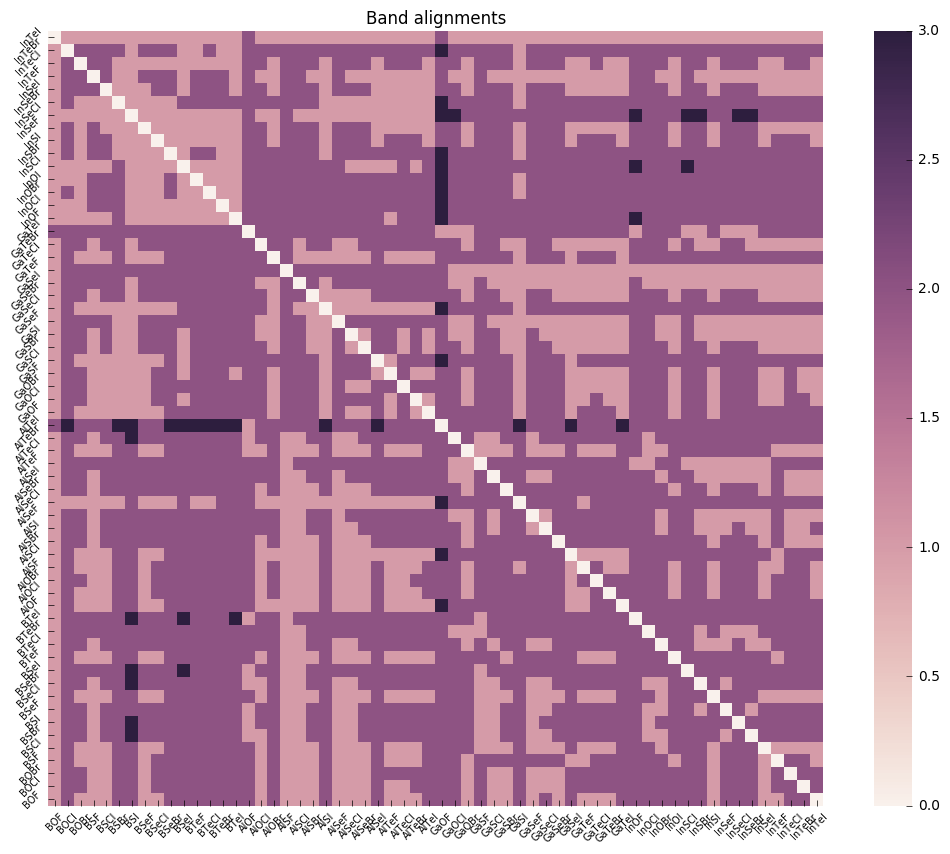

In [1285]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(matrix,ax=ax,square=True)
ax.set_yticklabels([edge_compare[i][0] for i in range(len(edge_compare))], rotation=45,fontsize=7)
ax.set_xticklabels([edge_compare[i][0] for i in range(len(edge_compare))], rotation=45,fontsize=7)
ax.set_title('Band alignments')

### Section 3.2: Band gap and electronegativity
___

### Section 3.2.1: Phase 1 structures

In [836]:
#ternary_phase1.head(1)

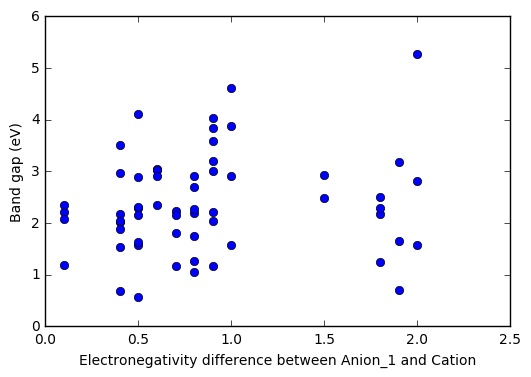

In [845]:
plt.plot(-ternary_phase1['Cation_negativity']+ternary_phase1['Anion_1_negativity'],ternary_phase1['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlim(0,2.5)
plt.xlabel('Electronegativity difference between Anion_1 and Cation')
plt.ylabel('Band gap (eV)')

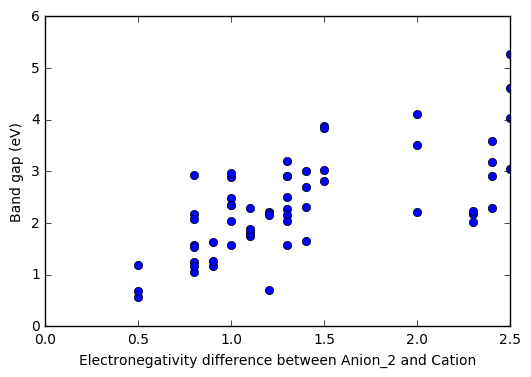

In [847]:
plt.plot(-ternary_phase1['Cation_negativity']+ternary_phase1['Anion_2_negativity'],ternary_phase1['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlim(0,2.5)
plt.xlabel('Electronegativity difference between Anion_2 and Cation')
plt.ylabel('Band gap (eV)')

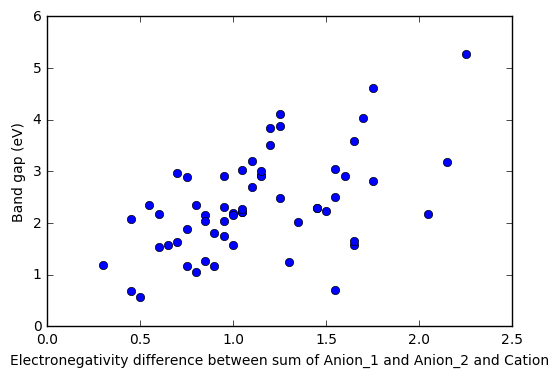

In [842]:
plt.plot(-ternary_phase1['Cation_negativity']+(ternary_phase1['Anion_1_negativity']+ternary_phase1['Anion_2_negativity'])/2.0,ternary_phase1['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlabel('Electronegativity difference between sum of Anion_1 and Anion_2 and Cation')

plt.ylabel('Band gap (eV)')

### Section 3.2.2: Phase 2 structures

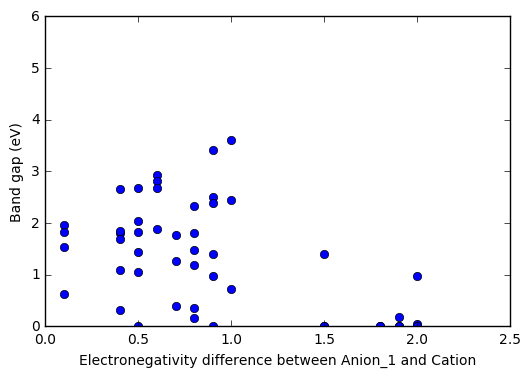

In [849]:
plt.plot(-ternary_phase2['Cation_negativity']+ternary_phase2['Anion_1_negativity'],ternary_phase2['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlim(0,2.5)
plt.xlabel('Electronegativity difference between Anion_1 and Cation')
plt.ylabel('Band gap (eV)')

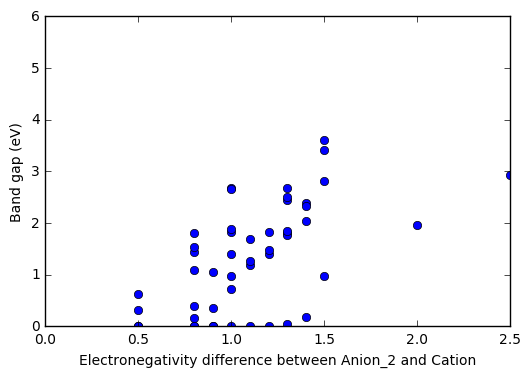

In [850]:
plt.plot(-ternary_phase2['Cation_negativity']+ternary_phase2['Anion_2_negativity'],ternary_phase2['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlim(0,2.5)
plt.xlabel('Electronegativity difference between Anion_2 and Cation')
plt.ylabel('Band gap (eV)')

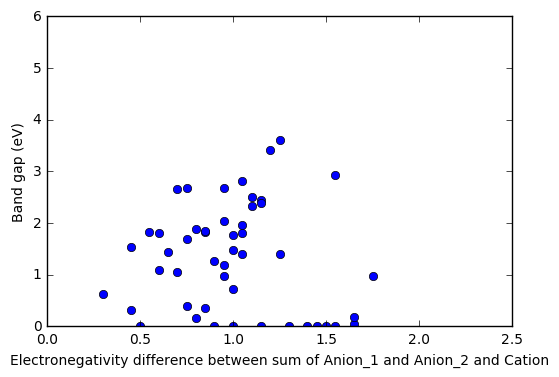

In [852]:
plt.plot(-ternary_phase2['Cation_negativity']+(ternary_phase2['Anion_1_negativity']+ternary_phase2['Anion_2_negativity'])/2.0,ternary_phase2['Band gap (eV)'],'o')
plt.ylim(0,6)
plt.xlabel('Electronegativity difference between sum of Anion_1 and Anion_2 and Cation')
plt.xlim(0,2.5)
plt.ylabel('Band gap (eV)')

___
### Phase 1 and Phase 2 in one figure
___

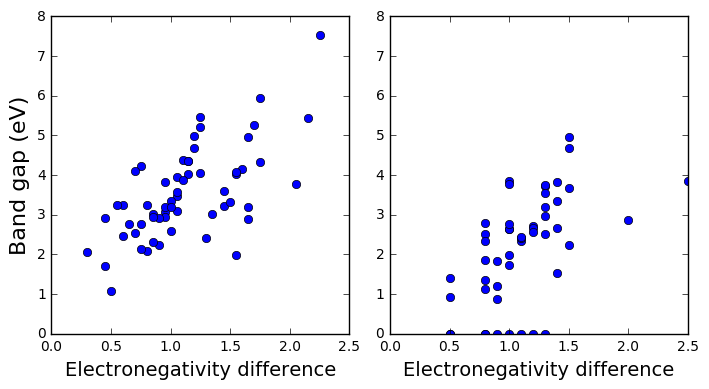

In [2488]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(-ternary_phase1['Cation_negativity']+(ternary_phase1['Anion_1_negativity']+ternary_phase1['Anion_2_negativity'])/2.0,ternary_phase1['HSE-gap (eV)'],'o')
axes[0].set_ylim(0,8)
axes[0].set_xlabel('Electronegativity difference',fontsize=14)
axes[0].set_ylabel('Band gap (eV)',fontsize=16)
axes[1].plot(-ternary_phase2['Cation_negativity']+ternary_phase2['Anion_2_negativity'],ternary_phase2['HSE-gap (eV)'],'o')
axes[1].set_ylim(0,8)
axes[1].set_xlim(0,2.5)
axes[1].set_xlabel('Electronegativity difference',fontsize=14)
fig.tight_layout(rect=[0,0,0.9,1])
#axes[1].set_ylabel('Band gap (eV)')

___
### Section 3.2.3: Phase I and II structural properties
___

In [1356]:
def plot_lattice_compound(ax,data_frame,xrange,yrange,phase):
    ax.plot(np.arange(xrange+1),data_frame['a1 (A)'],'o-.')
    if phase == 'Phase I':
        ax.plot(np.arange(xrange+1),ternary_phase_one['a2 (A)'],'^-')
    ax.set_xlim(0,xrange)
    ax.set_ylim(2,yrange)
    #ax.plot(np.arange(60),[-4.44]*60,'-r')
    #ax.plot(np.arange(60),[-5.67]*60,'-r')
    #ax.plot(np.arange(60),[-4.02]*60,'-.r')
    #ax.plot(np.arange(60),[-5.257]*60,'-.r')
    ax.set_xticks(np.arange(xrange+1))
    ax.set_yticks(np.arange(2,yrange+1))
    ax.set_xticklabels(data_frame['Compound'],rotation=90,fontsize=10)
    #ax.set_xlabel('2D III-VI-VII '+phase,fontsize = 15)
    ax.set_ylabel('Lattice constant (Ang)',fontsize = 15)
    plt.text(0.15, 0.85,'2D III-VI-VII '+phase, ha='center', va='center', transform=ax.transAxes,fontsize=14)
    #ax.set_title('2D III-VI-VII: '+phase,fontsize=20)

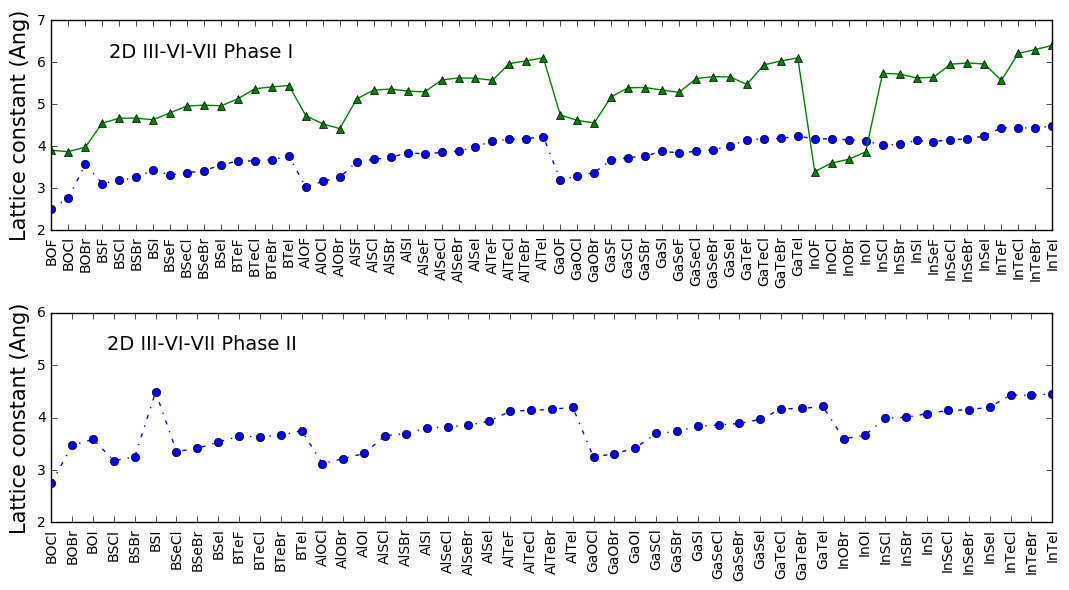

In [1359]:
fig, axes = plt.subplots(2,1,figsize=(12,6))
xranges=[59,48]
yranges=[7,6]
data_frames = [ternary_phase_one,ternary_phase_two]
phases=['Phase I','Phase II']
for i in range(2):
    plot_lattice_compound(axes[i],data_frames[i],xranges[i],yranges[i],phases[i])
fig.tight_layout(rect=[0,0,0.9,1])

___
## Section 4: Machine learning methods to predict band gaps
___

___
### Section 4.0: Feature engineering
**Step 1:** add more features

1. add difference between electronegativity as a feature

2. add averaged atomic mass as a feature

**Step 2:** Normalize the features

In [720]:
## We know there are two different structural phases for this group of ternary compounds. So we first seperate them.
#ternary_phase_one = ternary_phase1
#ternary_phase_two = ternary_phase2
#ternary_phase1.drop(['Cation','Anion_1','Anion_2'],axis=1)
#list(ternary_info)
#['a3 [A]','Cation','Anion_1','Anion_2']

In [1911]:
#ternary_phase_one['Cation_elec_aff']=ternary_phase_one['Cation'].map(lambda x: elec_affinity[x])
#ternary_phase_one['Anion_1_elec_aff']=ternary_phase_one['Anion_1'].map(lambda x: elec_affinity[x])
#ternary_phase_one['Anion_2_elec_aff']=ternary_phase_one['Anion_2'].map(lambda x: elec_affinity[x])
#ternary_phase_one['Cation_ionization']=ternary_phase_one['Cation'].map(lambda x: ionization_energy[x])
#ternary_phase_one['Anion_1_ionization']=ternary_phase_one['Anion_1'].map(lambda x: ionization_energy[x])
#ternary_phase_one['Anion_2_ionization']=ternary_phase_one['Anion_2'].map(lambda x: ionization_energy[x])
#ternary_phase_one.info()

In [1909]:
#ternary_phase_two['Cation_elec_aff']=ternary_phase_two['Cation'].map(lambda x: elec_affinity[x])
#ternary_phase_two['Anion_1_elec_aff']=ternary_phase_two['Anion_1'].map(lambda x: elec_affinity[x])
#ternary_phase_two['Anion_2_elec_aff']=ternary_phase_two['Anion_2'].map(lambda x: elec_affinity[x])
#ternary_phase_two['Cation_ionization']=ternary_phase_two['Cation'].map(lambda x: ionization_energy[x])
#ternary_phase_two['Anion_1_ionization']=ternary_phase_two['Anion_1'].map(lambda x: ionization_energy[x])
#ternary_phase_two['Anion_2_ionization']=ternary_phase_two['Anion_2'].map(lambda x: ionization_energy[x])

In [728]:
#phase_one_target=ternary_phase_one[['Band gap (eV)','HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)']]

In [1374]:
#phase_two_target=ternary_phase_two[['Band gap (eV)','HSE-gap (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)']]

In [1913]:
#ternary_phase_one.info()

In [1915]:
#phase_one_feature_full=ternary_phase_one.drop(['Phase','level_0','a3 (A)','Cation','Anion_1','Anion_2','Band gap (eV)','HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)',],axis=1)
#phase_two_feature_full=ternary_phase_two.drop(['Phase','index','a3 (A)','Cation','Anion_1','Anion_2','Band gap (eV)','HSE-gap (eV)','HSE-VBM (eV)','HSE-CBM (eV)','HSE-VBM Absolute (eV)','HSE-CBM Absolute (eV)',],axis=1)

In [1867]:
#ionization_affinity={"Cation_elec_aff","Anion_1_elec_aff"}

**phase_one(two)_target**: the target value we want to predict;

**phase_one(two)_feature**: features in the fitting model.

In [1569]:
#phase_one_feature

In [858]:
def normalize(data_frame, col_name, normal_type='rescaling'):
    """
    function: Normalize the data
    data_frame: the data frame you are dealing with
    col_name: the label of the column
    """
    max_val = data_frame[col_name].max()
    min_val = data_frame[col_name].min()
    mean_val = data_frame[col_name].mean()
    var_val = data_frame[col_name].var()
    if normal_type == 'rescaling' or normal_type == 'r':
        data_frame[col_name]=data_frame[col_name].map(lambda x: (x-min_val)*1.0/(max_val-min_val))
    elif normal_type == 'standardization' or normal_type == 's':
        data_frame[col_name]=data_frame[col_name].map(lambda x: (x-mean_val)*1.0/(var_val))

In [1918]:
#phase_one_feature_full.drop('Compound',axis=1,inplace=True)
#phase_two_feature_full.drop('Compound',axis=1,inplace=True)

In [1920]:
# anion_1 - cation
#phase_one_feature_full['Anion_1 - Cation negativity'] = phase_one_feature_full['Anion_1_negativity'] - phase_one_feature_full['Cation_negativity']
#phase_one_feature_full['Anion_2 - Cation negativity'] = phase_one_feature_full['Anion_2_negativity'] - phase_one_feature_full['Cation_negativity']
#phase_one_feature_full['Anion_1 + Anion_2 - Cation negativity'] = phase_one_feature_full['Anion_1_negativity'] + phase_one_feature_full['Anion_2_negativity'] - phase_one_feature_full['Cation_negativity']
#phase_one_feature_full['average mass'] = (phase_one_feature_full['Cation_mass'] + phase_one_feature_full['Anion_1_mass'] + phase_one_feature_full['Anion_2_mass'])/3.0

In [1922]:
#phase_two_feature_full['Anion_1 - Cation negativity'] = phase_two_feature_full['Anion_1_negativity'] - phase_two_feature_full['Cation_negativity']
#phase_two_feature_full['Anion_2 - Cation negativity'] = phase_two_feature_full['Anion_2_negativity'] - phase_two_feature_full['Cation_negativity']
#phase_two_feature_full['Anion_1 + Anion_2 - Cation negativity'] = phase_two_feature_full['Anion_1_negativity'] + phase_two_feature_full['Anion_2_negativity'] - phase_two_feature_full['Cation_negativity']
#phase_two_feature_full['average mass'] = (phase_two_feature_full['Cation_mass'] + phase_two_feature_full['Anion_1_mass'] + phase_two_feature_full['Anion_2_mass'])/3.0

In [1642]:
#phase_two_feature['Anion_1 - Cation negativity'] = phase_two_feature['Anion_1_negativity'] - phase_two_feature['Cation_negativity']
#phase_two_feature['Anion_2 - Cation negativity'] = phase_two_feature['Anion_2_negativity'] - phase_two_feature['Cation_negativity']
#phase_two_feature['Anion_1 + Anion_2 - Cation negativity'] = phase_two_feature['Anion_1_negativity'] + phase_two_feature['Anion_2_negativity'] - phase_two_feature['Cation_negativity']

In [1924]:
#phase_one_feature_full

In [1875]:
#list(phase_one_feature_full)
#phase_one_feature_full.drop('Compound',axis=1,inplace=True)

In [1879]:
#labels = ['Cation_negativity','Anion_1_negativity','Anion_2_negativity','Cation_mass','Anion_1_mass','Anion_2_mass','a1 (A)','a2 (A)','Cation_row_index','Anion_1_row_index','Anion_2_row_index','Anion_1 - Cation negativity',
#          'Anion_2 - Cation negativity','Anion_1 + Anion_2 - Cation negativity','average mass']
#list(phase_one_feature_full)
#phase_one_feature_full
labels = ['Anion_1_elec_aff','Anion_2_elec_aff','Cation_ionization','Anion_1_ionization','Anion_2_ionization']

In [1927]:
#for label in list(phase_two_feature_full):
#    normalize(phase_two_feature_full, label)
#list(phase_two_feature)
#phase_one_feature_full['anion']

In [1657]:
#phase_two_feature.drop(['Cation_ionization','Anion_1_ionization','Anion_2_ionization'],axis=1,inplace=True)

___
### Section 4.1: Linear regression models

#### Section 4.1.1: Linear regression fitting

In [1034]:
#phase_one_feature.head()

In [1979]:
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(phase_one_feature,phase_one_target['Band gap (eV)'],test_size=0.2,random_state=23)
gap_linear=lm.LinearRegression()
gap_linear.fit(X_train, Y_train)
predict_gap=gap_linear.predict(X_train)

In [2745]:
phase_one_feature_full.columns

Index(['Cation_negativity', 'Anion_1_negativity', 'Anion_2_negativity',
       'Cation_mass', 'Anion_1_mass', 'Anion_2_mass', 'a1 (A)', 'a2 (A)',
       'Cation_row_index', 'Anion_1_row_index', 'Anion_2_row_index',
       'Cation_elec_aff', 'Anion_1_elec_aff', 'Anion_2_elec_aff',
       'Cation_ionization', 'Anion_1_ionization', 'Anion_2_ionization',
       'Anion_1 - Cation negativity', 'Anion_2 - Cation negativity',
       'average mass', 'Anion_1 + Anion_2 - Cation negativity'],
      dtype='object')

In [1980]:
#def linear_fit(feature,target,size,randomness=20):
#    X_train, X_test, Y_train, Y_test = train_test_split(feature,target,test_size=size,random_state=randomness)
#    gap_linear = lm.LinearRegression()
#    gap_linear.fit(X_train,Y_train)
#    return gap_linear

In [1981]:
print(gap_linear.coef_)
print(gap_linear.intercept_)
print(gap_linear.score(X_train,Y_train))

[ -8.1151495   -0.49780235  -1.21710839  33.4791709   -4.5077573
  -1.74482958 -42.2544981    1.94936604  -3.56405151   1.76876393
   1.11595609   0.45146732   8.62628774]
11.4250027686
0.53462859764


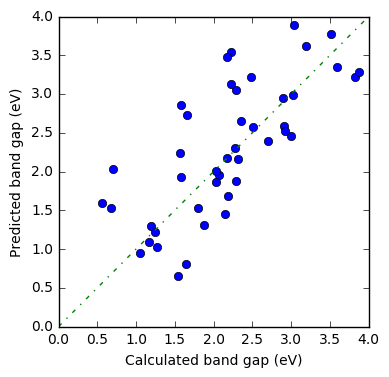

In [1982]:
plt.plot(Y_train,predict_gap,'o')
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel('Calculated band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.plot([0,4],[0,4],'-.')
plt.axes().set_aspect('equal')

#### Section 4.1.2: Cross-validation

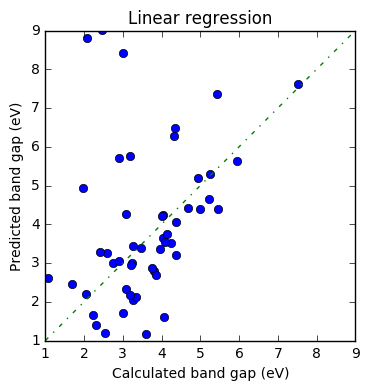

In [2612]:
# linear regression
predicted_lr_cv = cross_val_predict(lm.LinearRegression(), phase_one_feature_full, phase_one_target['HSE-gap (eV)'], cv=5)
plt.plot(phase_one_target['HSE-gap (eV)'],predicted_lr_cv,'o')
plt.xlim(1,9)
plt.ylim(1,9)
plt.plot([1,9],[1,9],'-.')
plt.axes().set_aspect('equal')
plt.xlabel('Calculated band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.title('Linear regression')

In [2613]:
mean_squared_error(phase_one_target['HSE-gap (eV)'],predicted_lr_cv)

11.293646708095832

In [2614]:
scores = cross_val_score(lm.LinearRegression(), phase_one_feature, phase_one_target['Band gap (eV)'], cv=10)

In [2615]:
scores

array([-0.21595767, -0.34819934,  0.54589045,  0.7211554 , -0.7876765 ,
       -0.10831919,  0.51811064, -9.95769941,  0.29393893, -7.23061419])

___
### Lasso
___

In [2622]:
from sklearn.linear_model import Lasso,LassoCV

### Band gap

In [2688]:
lr_lasso_gap_1 = Lasso(alpha=0.025922429172370962)
lr_lasso_gap_2 = Lasso(alpha=0.010618261304254152)
lasso_predicted_gap_1=cross_val_predict(lr_lasso_gap_1,phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv=5)
lasso_predicted_gap_2=cross_val_predict(lr_lasso_gap_2,phase_two_feature_full,phase_two_target['HSE-gap (eV)'],cv=5)

In [2689]:
print(mean_squared_error(lasso_predicted_gap_1,phase_one_target['HSE-gap (eV)']),mean_squared_error(lasso_predicted_gap_2,phase_two_target['HSE-gap (eV)']))

1.32848781919 0.383195748452


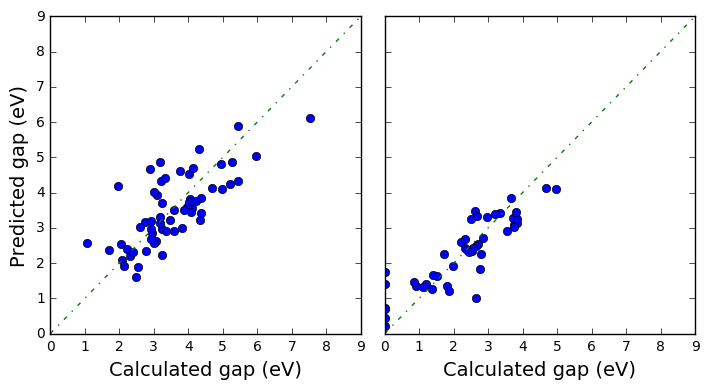

In [2690]:
fig, axes = plt.subplots(1,2,figsize=(8,4),sharey=True)
axes[0].plot(phase_one_target['HSE-gap (eV)'],lasso_predicted_gap_1,'o')
axes[1].plot(phase_two_target['HSE-gap (eV)'],lasso_predicted_gap_2,'o')
for i in range(2):
    axes[i].set_xlim(0,9)
    axes[i].set_ylim(0,9)
    axes[i].plot([0,9],[0,9],'-.')
    axes[i].set_xlabel('Calculated gap (eV)',fontsize=14)
axes[0].set_ylabel('Predicted gap (eV)',fontsize=14)
fig.tight_layout(rect=[0,0,0.9,1])

In [2685]:
opt_model_lassoCV = LassoCV(cv=5).fit(phase_two_feature_full,phase_two_target['HSE-gap (eV)'])

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(0.46511218225582684,
 3.4651121822558268,
 0.26973559342221348,
 40.773779683209732)

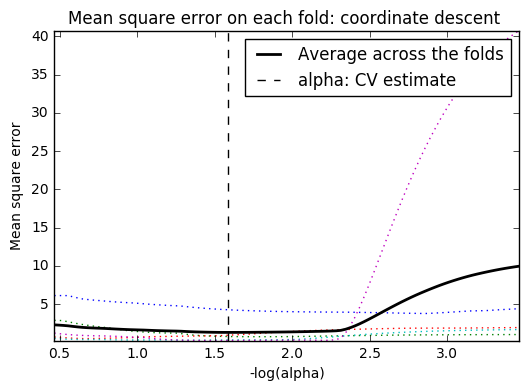

In [2628]:
optm_log_alphas = -np.log10(opt_model_lassoCV.alphas_)

plt.figure()
#ymin, ymax = 2300, 3800
plt.plot(optm_log_alphas, opt_model_lassoCV.mse_path_, ':')
plt.plot(optm_log_alphas, opt_model_lassoCV.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(opt_model_lassoCV.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
#plt.ylim(ymin, ymax)

In [2686]:
opt_model_lassoCV.alpha_

0.010618261304254152

### VBM
___

In [2680]:
opt_model_VBM_lassoCV = LassoCV(cv=5).fit(phase_two_feature_full,phase_two_target['HSE-VBM Absolute (eV)'])

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [2681]:
opt_model_VBM_lassoCV.alpha_

0.0095103398268663684

In [2682]:
lr_lasso_vbm_1 = Lasso(alpha=0.014912344917360361)
lr_lasso_vbm_2 = Lasso(alpha=0.0095103398268663684)
lasso_predicted_vbm_1=cross_val_predict(lr_lasso_vbm_1,phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'],cv=5)
lasso_predicted_vbm_2=cross_val_predict(lr_lasso_vbm_2,phase_two_feature_full,phase_two_target['HSE-VBM Absolute (eV)'],cv=5)

/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/zhenzhu/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [2683]:
print(mean_squared_error(lasso_predicted_vbm_1,phase_one_target['HSE-VBM Absolute (eV)']),mean_squared_error(lasso_predicted_vbm_2,phase_two_target['HSE-VBM Absolute (eV)']))

0.822797859604 0.228909468797


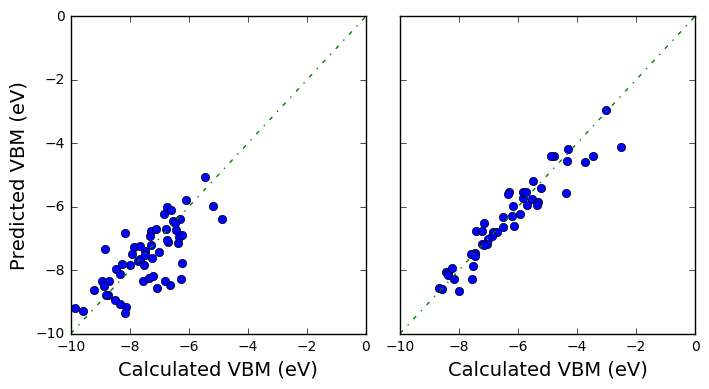

In [2684]:
fig, axes = plt.subplots(1,2,figsize=(8,4),sharey=True)
axes[0].plot(phase_one_target['HSE-VBM Absolute (eV)'],lasso_predicted_vbm_1,'o')
axes[1].plot(phase_two_target['HSE-VBM Absolute (eV)'],lasso_predicted_vbm_2,'o')
for i in range(2):
    axes[i].set_xlim(-10,0)
    axes[i].set_ylim(-10,0)
    axes[i].plot([-10,0],[-10,0],'-.')
    axes[i].set_xlabel('Calculated VBM (eV)',fontsize=14)
axes[0].set_ylabel('Predicted VBM (eV)',fontsize=14)
fig.tight_layout(rect=[0,0,0.9,1])

### CBM
___

In [2671]:
opt_model_CBM_lassoCV = LassoCV(cv=5).fit(phase_two_feature_full,phase_two_target['HSE-CBM Absolute (eV)'])

In [2672]:
opt_model_CBM_lassoCV.alpha_

0.033284663975784064

In [2677]:
lr_lasso_cbm_1 = Lasso(alpha=0.058057553983896046)
lr_lasso_cbm_2 = Lasso(alpha=0.033284663975784064)
lasso_predicted_cbm_1=cross_val_predict(lr_lasso_cbm_1,phase_one_feature_full,phase_one_target['HSE-CBM Absolute (eV)'],cv=5)
lasso_predicted_cbm_2=cross_val_predict(lr_lasso_cbm_2,phase_two_feature_full,phase_two_target['HSE-CBM Absolute (eV)'],cv=5)

In [2678]:
print(mean_squared_error(lasso_predicted_cbm_1,phase_one_target['HSE-CBM Absolute (eV)']),mean_squared_error(lasso_predicted_cbm_2,phase_two_target['HSE-CBM Absolute (eV)']))

0.471530697846 0.251179273333


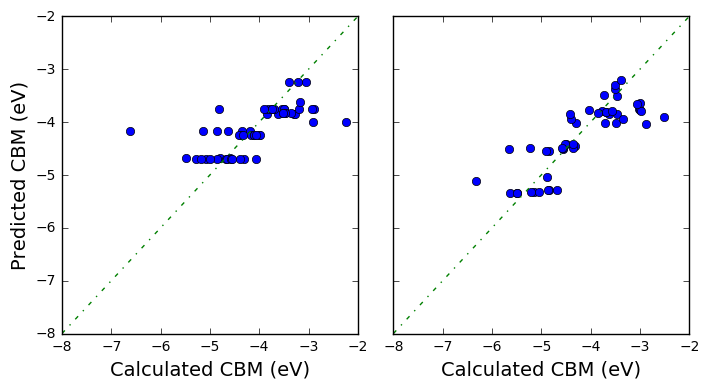

In [2679]:
fig, axes = plt.subplots(1,2,figsize=(8,4),sharey=True)
axes[0].plot(phase_one_target['HSE-CBM Absolute (eV)'],lasso_predicted_cbm_1,'o')
axes[1].plot(phase_two_target['HSE-CBM Absolute (eV)'],lasso_predicted_cbm_2,'o')
for i in range(2):
    axes[i].set_xlim(-8,-2)
    axes[i].set_ylim(-8,-2)
    axes[i].plot([-8,-2],[-8,-2],'-.')
    axes[i].set_xlabel('Calculated CBM (eV)',fontsize=14)
axes[0].set_ylabel('Predicted CBM (eV)',fontsize=14)
fig.tight_layout(rect=[0,0,0.9,1])

In [2696]:
#list(lasso_predicted_cbm_1)

In [2703]:
#plt.plot(phase_one_target['HSE-gap (eV)'],[list(lasso_predicted_gap_1)[i]-list(phase_one_target['HSE-gap (eV)'])[i] for i in range(len(lasso_predicted_cbm_1))],'o')

___
### Section 4.2: Support vector machine
___

In [1112]:
#list(phase_one_feature)

In [884]:
from sklearn.svm import SVR

In [1775]:
svr_rbf = SVR(kernel='rbf', C=40, gamma=0.1)

In [1041]:
X_train, X_test, Y_train, Y_test = train_test_split(phase_one_feature,phase_one_target['HSE-gap (eV)'],test_size=0.3,random_state=71)

In [1042]:
svr_rbf.fit(X_train, Y_train)
predict_gap=svr_rbf.predict(X_test)
predict_gap_train = svr_rbf.predict(X_train)

(1.0, 9.0)

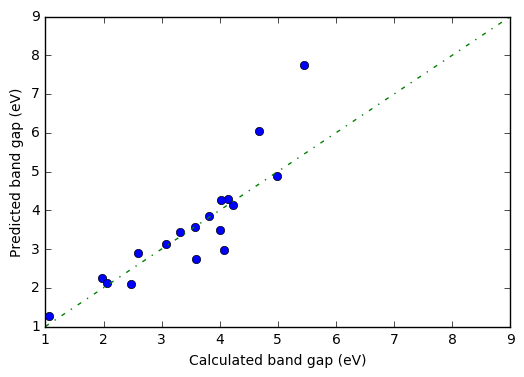

In [1043]:
plt.plot(Y_test,predict_gap,'o')
#plt.plot(Y_train,predict_gap_train,'o')
plt.xlabel('Calculated band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.plot([1,9],[1,9],'-.')
plt.ylim(1.0,9.0)
plt.xlim(1.0,9.0)

In [1047]:
#ternary_info[(ternary_info['Band gap (eV)']>5) & (ternary_info['Band gap (eV)']<6)]
# AlSF and AlOF the two outliers

In [2344]:
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.13)
#0.22562304629706351
svr_rbf = SVR(kernel='rbf', C=3.257, gamma=0.1)

In [2387]:
predicted_svr_cv_vbm_1 = cross_val_predict(svr_rbf, phase_one_feature_full, phase_one_target['HSE-VBM Absolute (eV)'], cv=5)

(1.0, 9.0)

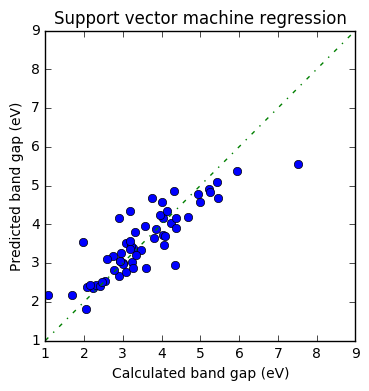

In [2377]:
plt.plot(phase_one_target['HSE-gap (eV)'],predicted_svr_cv,'o')
#plt.plot(Y_train,predicted_gap_train,'o')
plt.xlabel('Calculated band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.title('Support vector machine regression')
plt.axes().set_aspect('equal')
plt.plot([1,9],[1,9],'-.')
plt.ylim(1.0,9.0)
plt.xlim(1.0,9.0)

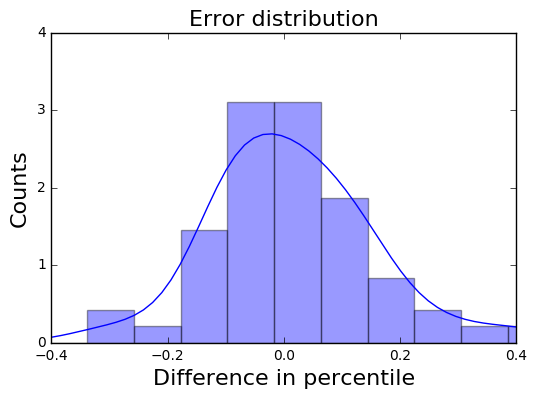

In [2379]:
#sns.distplot(phase_one_target['HSE-gap (eV)']-predicted_svr_cv)
#plt.xlim(-2,2)
diff = []
hse_gap=list(phase_one_target['HSE-gap (eV)'])
predicted = list(predicted_svr_cv)
for i in range(len(predicted_svr_cv)):
    diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
sns.distplot(diff,bins=20)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,4)
plt.yticks([0,1,2,3,4])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)

In [ ]:
# 55% within +-10%
# 82% within +-20%

In [2359]:
count = 0
for elem in diff:
    if abs(elem)<0.2:
        count += 1
print(count*1.0/len(diff))

0.8166666666666667


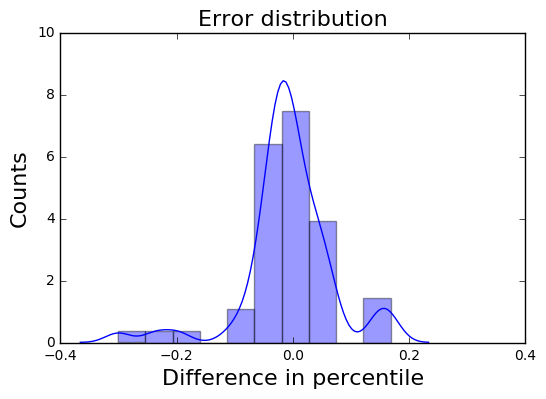

In [2394]:
diff = []
hse_gap=list(phase_one_target['HSE-VBM Absolute (eV)'])
predicted = list(predicted_svr_cv_vbm_1)
for i in range(len(predicted_svr_cv_vbm_1)):
    diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
sns.distplot(diff,bins=10)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,10)
plt.yticks([0,2,4,6,8,10])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)
count = 0
for elem in diff:
    if abs(elem)<0.1:
        count += 1
print(count*1.0/len(diff))

In [2396]:
# 20% 0.9666666666666667
# 10% 0.8666666666666667
count = 0
for elem in diff:
    if abs(elem)<0.1:
        count += 1
print(count*1.0/len(diff))

0.8666666666666667


0.9166666666666666


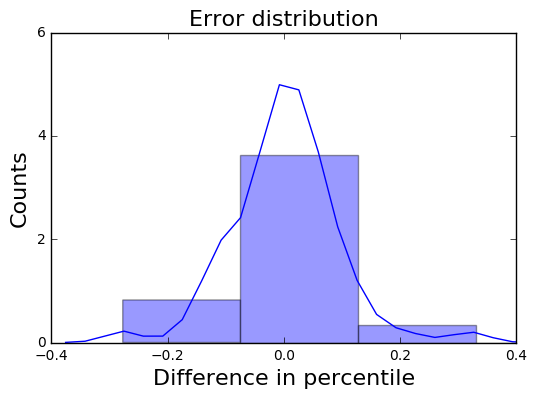

In [2402]:
predicted_svr_cv_cbm_1 = cross_val_predict(svr_rbf, phase_one_feature_full, phase_one_target['HSE-CBM Absolute (eV)'], cv=5)
diff = []
hse_gap=list(phase_one_target['HSE-CBM Absolute (eV)'])
predicted = list(predicted_svr_cv_cbm_1)
for i in range(len(predicted_svr_cv_cbm_1)):
    diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
sns.distplot(diff,bins=20)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,6)
plt.yticks([0,2,4,6])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)
count = 0
for elem in diff:
    if abs(elem)<0.2:
        count += 1
print(count*1.0/len(diff))

In [2368]:
#list(phase_two_target['HSE-gap (eV)'])

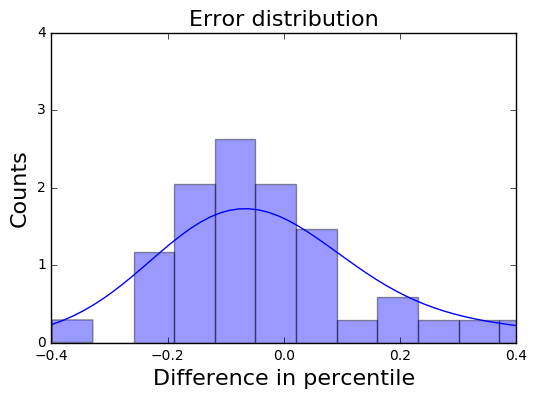

In [2382]:
#sns.distplot(phase_one_target['HSE-gap (eV)']-predicted_svr_cv)
#plt.xlim(-2,2)
diff = []
hse_gap=list(phase_two_target['HSE-gap (eV)'])
predicted = list(predicted_svr_cv)
for i in range(len(predicted_svr_cv)):
    if hse_gap[i]==0:
        diff.append(((predicted[i]-hse_gap[i]))/predicted[i])
    else:
        diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
#diff = list(phase_two_target['HSE-gap (eV)']- predicted_svr_cv)
sns.distplot(diff,bins=20)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,4)
plt.yticks([0,1,2,3,4])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)

In [2386]:
# 41% within +-10%
# 61% within +-20%

In [2385]:
count = 0
for elem in diff:
    if abs(elem)<0.1:
        count += 1
print(count*1.0/len(diff))

0.40816326530612246


0.8979591836734694


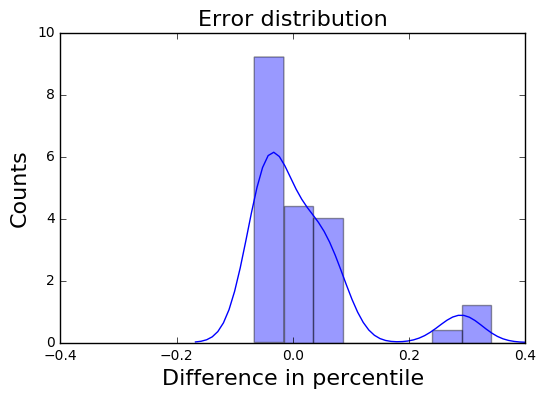

In [2410]:
predicted_svr_cv_vbm_2 = cross_val_predict(svr_rbf, phase_two_feature_full, phase_two_target['HSE-VBM Absolute (eV)'], cv=5)
diff = []
hse_gap=list(phase_two_target['HSE-VBM Absolute (eV)'])
predicted = list(predicted_svr_cv_vbm_2)
for i in range(len(predicted_svr_cv_vbm_2)):
    diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
sns.distplot(diff,bins=20)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,10)
plt.yticks([0,2,4,6,8,10])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)
count = 0
for elem in diff:
    if abs(elem)<0.1:
        count += 1
print(count*1.0/len(diff))
#predicted_svr_cv
# 20% 0.8979591836734694
# 10% 0.8979591836734694

0.7551020408163265


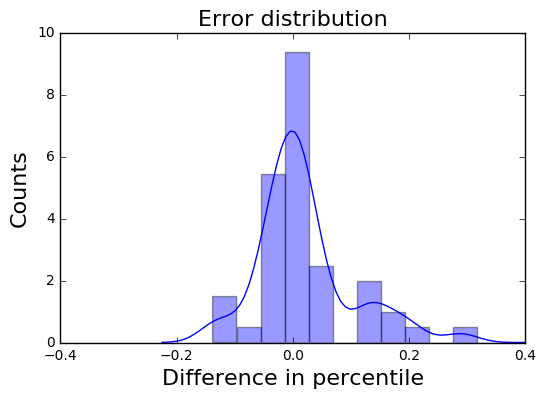

In [2406]:
predicted_svr_cv_cbm_2 = cross_val_predict(svr_rbf, phase_two_feature_full, phase_two_target['HSE-CBM Absolute (eV)'], cv=5)
diff = []
hse_gap=list(phase_two_target['HSE-CBM Absolute (eV)'])
predicted = list(predicted_svr_cv_cbm_2)
for i in range(len(predicted_svr_cv_cbm_2)):
    diff.append(((predicted[i]-hse_gap[i]))/hse_gap[i])
sns.distplot(diff,bins=20)
plt.xlim(-0.4,0.4)
plt.xticks([-0.4,-0.2,0,0.2,0.4])
plt.ylim(0,10)
plt.yticks([0,2,4,6,8,10])
plt.title('Error distribution',fontsize=16)
plt.xlabel('Difference in percentile',fontsize=16)
plt.ylabel('Counts',fontsize=16)
count = 0
for elem in diff:
    if abs(elem)<0.1:
        count += 1
print(count*1.0/len(diff))
#predicted_svr_cv
# 20% 0.9183673469387755
# 10% 0.7551020408163265

In [965]:
scores.mean()

0.66727489298565512

___
### Section 4.3: Random forest regression
___

In [1009]:
from sklearn.ensemble import RandomForestRegressor

In [1730]:
X_train, X_test, Y_train, Y_test = train_test_split(phase_one_feature,phase_one_target['HSE-CBM Absolute (eV)'],test_size=0.2,random_state=62)

In [1733]:
gap_RFR = RandomForestRegressor()
gap_RFR.fit(X_train, Y_train)
predicted_gap = gap_RFR.predict(X_test)
predicted_gap_train = gap_RFR.predict(X_train)

In [2577]:
#list(phase_one_feature)

In [2411]:
#for i,label in list(phase_one_feature):
#list(gap_RFR.feature_importances_)
#gap_RFR.oob_score_
#phase_one_feature

(1.0, 9.0)

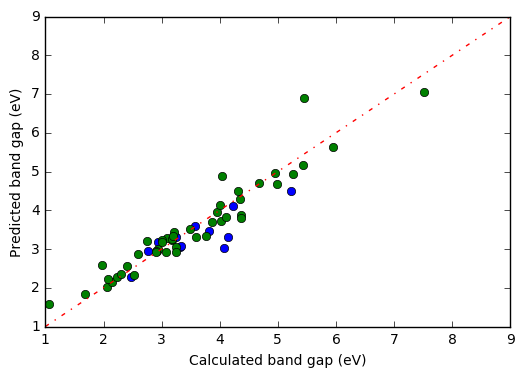

In [1712]:
plt.plot(Y_test,predicted_gap,'o')
plt.plot(Y_train,predicted_gap_train,'o')
plt.xlabel('Calculated band gap (eV)')
plt.ylabel('Predicted band gap (eV)')
plt.plot([1,9],[1,9],'-.')
plt.ylim(1.0,9.0)
plt.xlim(1.0,9.0)

___
### Grid searching for optimum parameters in Random Forest Regression
___

### Phase 1:

In [2501]:
from sklearn.metrics import mean_squared_error

In [2071]:
param_grid={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=5)
rfr_grid.fit(phase_one_feature_full,phase_one_target['HSE-gap (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2490]:
print(rfr_grid.best_params_,rfr_grid.best_score_)

{'max_features': 17, 'min_samples_leaf': 2} 0.452083574156


In [2502]:
predicted_gap_1 = cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=17),phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv=5)

In [2503]:
mean_squared_error(phase_one_target['HSE-gap (eV)'],predicted_gap_1)

0.9036841500417141

### Feature importance of band gap
___

In [2541]:
rfr_gap_1 = RandomForestRegressor(min_samples_leaf=2,max_features=17)
rfr_gap_1.fit(phase_one_feature_full,phase_one_target['HSE-gap (eV)'])
feature_importance_gap = rfr_gap_1.feature_importances_

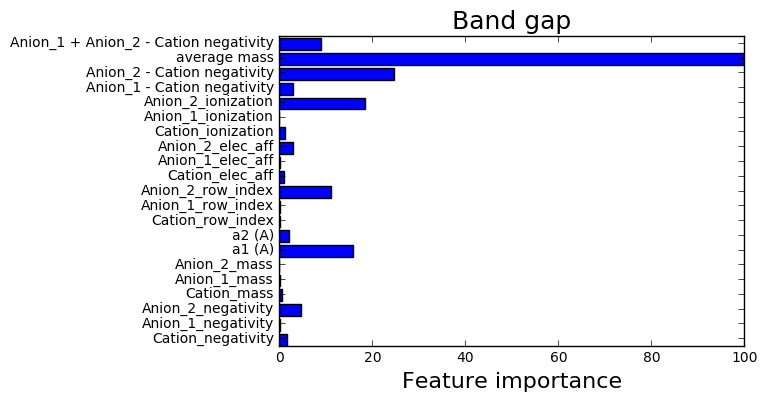

In [2567]:
plt.barh(np.arange(21),[(elem/feature_importance_gap.max()*100) for elem in feature_importance_gap])
plt.yticks(np.arange(21)+0.5,list(phase_one_feature_full))
plt.title('Band gap',fontsize=18)
plt.ylim(0,21)
plt.xlabel('Feature importance',fontsize=16)

In [2558]:
#predicted_gap_1 = rfr_gap_1.predict(phase_one_feature_full)

In [2559]:
#plt.plot(phase_one_target['HSE-gap (eV)'],predicted_gap_1,'o')
#plt.xlim(0,8)
#plt.ylim(0,8)

___

In [2491]:
param_grid_vbm={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid_vbm = GridSearchCV(RandomForestRegressor(),param_grid=param_grid_vbm,cv=5)
rfr_grid_vbm.fit(phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2492]:
print(rfr_grid_vbm.best_params_,rfr_grid_vbm.best_score_)

{'max_features': 17, 'min_samples_leaf': 3} 0.750895469173


In [2504]:
predicted_vbm_1 = cross_val_predict(RandomForestRegressor(min_samples_leaf=3,max_features=17),phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'],cv=5)
mean_squared_error(phase_one_target['HSE-VBM Absolute (eV)'],predicted_vbm_1)

0.77515355790544782

### Feature importance of VBM
___

In [2562]:
rfr_vbm_1 = RandomForestRegressor(min_samples_leaf=3,max_features=17)
rfr_vbm_1.fit(phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'])
feature_importance_vbm = rfr_vbm_1.feature_importances_

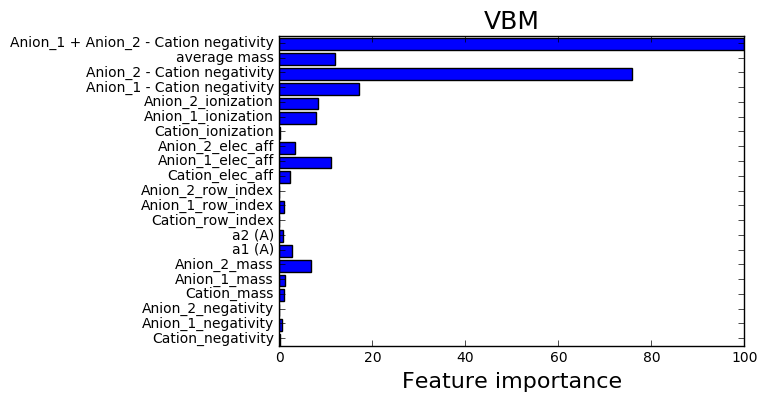

In [2566]:
plt.barh(np.arange(21),[(elem/feature_importance_vbm.max()*100) for elem in list(feature_importance_vbm)])
plt.yticks(np.arange(21)+0.5,list(phase_one_feature_full))
plt.title('VBM',fontsize=18)
plt.ylim(0,21)
plt.xlabel('Feature importance',fontsize=16)

___

In [2493]:
param_grid_cbm={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid_cbm = GridSearchCV(RandomForestRegressor(),param_grid=param_grid_cbm,cv=5)
rfr_grid_cbm.fit(phase_one_feature_full,phase_one_target['HSE-CBM Absolute (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2494]:
print(rfr_grid_cbm.best_params_,rfr_grid_cbm.best_score_)

{'max_features': 8, 'min_samples_leaf': 10} -0.285893640328


In [2508]:
predicted_cbm_1 = cross_val_predict(RandomForestRegressor(min_samples_leaf=10,max_features=8),phase_one_feature_full,phase_one_target['HSE-CBM Absolute (eV)'],cv=5)
mean_squared_error(phase_one_target['HSE-CBM Absolute (eV)'],predicted_cbm_1)

0.66944830235347308

In [2576]:
#list(phase_one_feature_full)

In [2568]:
rfr_cbm_1 = RandomForestRegressor(min_samples_leaf=10,max_features=8)
rfr_cbm_1.fit(phase_one_feature_full,phase_one_target['HSE-CBM Absolute (eV)'])
feature_importance_cbm = rfr_cbm_1.feature_importances_

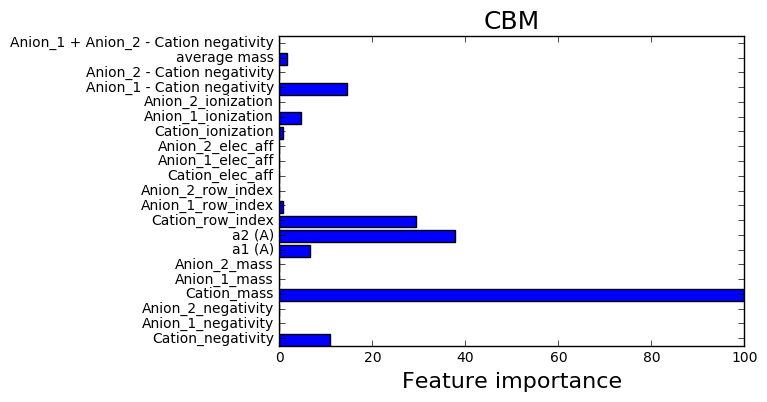

In [2569]:
plt.barh(np.arange(21),[(elem/feature_importance_cbm.max()*100) for elem in list(feature_importance_cbm)])
plt.yticks(np.arange(21)+0.5,list(phase_one_feature_full))
plt.title('CBM',fontsize=18)
plt.ylim(0,21)
plt.xlabel('Feature importance',fontsize=16)

### Compare plots of feature importance
___

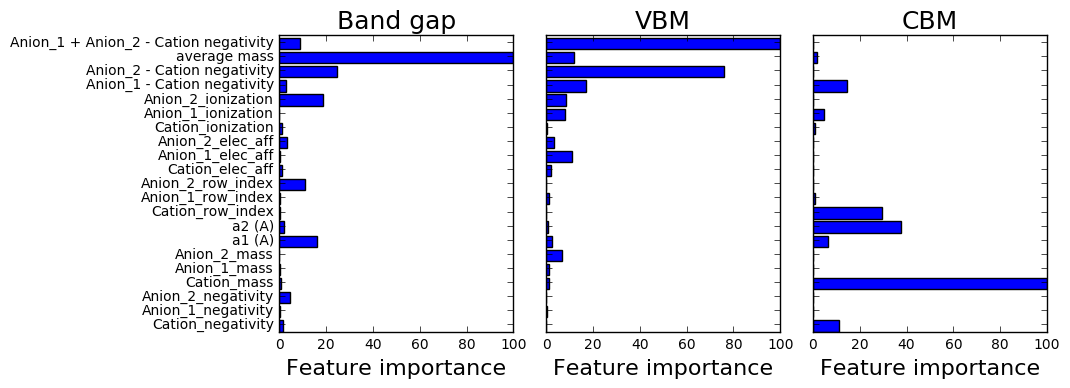

In [2575]:
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
axes[0].barh(np.arange(21),[(elem/feature_importance_gap.max()*100) for elem in list(feature_importance_gap)])
axes[1].barh(np.arange(21),[(elem/feature_importance_vbm.max()*100) for elem in list(feature_importance_vbm)])
axes[2].barh(np.arange(21),[(elem/feature_importance_cbm.max()*100) for elem in list(feature_importance_cbm)])
axes[0].set_yticks(np.arange(21)+0.5)
axes[0].set_yticklabels(list(phase_one_feature_full))
axes[0].set_title('Band gap',fontsize=18)
axes[1].set_title('VBM',fontsize=18)
axes[2].set_title('CBM',fontsize=18)
for i in [0,1,2]:
    axes[i].set_ylim(0,21)
    axes[i].set_xlabel('Feature importance',fontsize=16)
fig.tight_layout(rect=[0,0,0.9,1])

___

### Phase 2:

In [2495]:
param_grid_2={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid_2 = GridSearchCV(RandomForestRegressor(),param_grid=param_grid_2,cv=5)
rfr_grid_2.fit(phase_two_feature_full,phase_two_target['HSE-gap (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2496]:
print(rfr_grid_2.best_params_,rfr_grid_2.best_score_)

{'max_features': 8, 'min_samples_leaf': 3} 0.755727246636


In [2511]:
predicted_gap_2 = cross_val_predict(RandomForestRegressor(min_samples_leaf=3,max_features=8),phase_two_feature_full,phase_two_target['HSE-gap (eV)'],cv=5)
mean_squared_error(phase_two_target['HSE-gap (eV)'],predicted_gap_2)

0.62187523884635387

In [2497]:
param_grid_vbm_2={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid_vbm_2 = GridSearchCV(RandomForestRegressor(),param_grid=param_grid_vbm_2,cv=5)
rfr_grid_vbm_2.fit(phase_two_feature_full,phase_two_target['HSE-VBM Absolute (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2498]:
print(rfr_grid_vbm_2.best_params_,rfr_grid_vbm_2.best_score_)

{'max_features': 10, 'min_samples_leaf': 2} 0.64204658504


In [2518]:
predicted_vbm_2 = cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=10),phase_two_feature_full,phase_two_target['HSE-VBM Absolute (eV)'],cv=5)
mean_squared_error(phase_two_target['HSE-VBM Absolute (eV)'],predicted_vbm_2)

0.67743899490304083

In [2519]:
param_grid_cbm_2={'min_samples_leaf':np.arange(2,15,1),'max_features':np.arange(5,20,1)}
rfr_grid_cbm_2 = GridSearchCV(RandomForestRegressor(),param_grid=param_grid_cbm_2,cv=5)
rfr_grid_cbm_2.fit(phase_two_feature_full,phase_two_target['HSE-CBM Absolute (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2520]:
print(rfr_grid_cbm_2.best_params_,rfr_grid_cbm_2.best_score_)

{'max_features': 19, 'min_samples_leaf': 8} -0.429808479362


In [2530]:
predicted_cbm_2 = cross_val_predict(RandomForestRegressor(min_samples_leaf=2,max_features=9),phase_two_feature_full,phase_two_target['HSE-CBM Absolute (eV)'],cv=5)
mean_squared_error(phase_two_target['HSE-CBM Absolute (eV)'],predicted_cbm_2)

0.28101811232362695

### Best score:
**Phase 1:**
- band gap: {'max_features': 17, 'min_samples_leaf': 2} 0.452083574156, MSE: 0.904
- VBM: {'max_features': 17, 'min_samples_leaf': 3} 0.750895469173, MSE: 0.775
- CBM: {'max_features': 8, 'min_samples_leaf': 10} -0.285893640328, MSE: 0.569

**Phase 2:**
- band gap: {'max_features': 8, 'min_samples_leaf': 3} 0.755727246636, MSE: 0.622
- VBM: {'max_features': 10, 'min_samples_leaf': 2} 0.64204658504, MSE: 0.844
- CBM: {'max_features': 9, 'min_samples_leaf': 2} -0.51573592606, MSE: 0.255

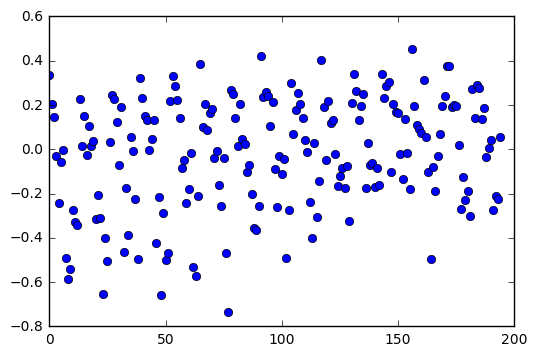

In [2073]:
plt.plot(np.arange(len(rfr_grid.cv_results_['mean_test_score'])),rfr_grid.cv_results_['mean_test_score'],'o')

___
### Section 4.4: Compare LR, SVR, and RFR
___

In [1170]:
def compare_plot(methods,method_labels,features,target,cv_id=10,target_max=9,target_min=1,xlabel='Calculated band gap (eV)',ylabel='Predicted band gap (eV)'):
    num_of_figs = len(method_labels)
    predicted = []
    for i in range(len(method_labels)):
        predicted.append(cross_val_predict(methods[i], features, target, cv=cv_id))
    fig, axes = plt.subplots(1,num_of_figs,sharex=False,sharey=False,figsize=(5*num_of_figs,5))
    for i in range(num_of_figs):
        axes[i].plot(target,predicted[i],'o')
        axes[i].set_xlim(target_min,target_max)
        axes[i].set_ylim(target_min,target_max)
        axes[i].plot([target_min,target_max],[target_min,target_max],'-.')
        axes[i].set_aspect('equal')
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(method_labels[i])

In [2204]:
lm_lr = lm.LinearRegression()
#'gamma': 0.44062364277735727, 'C': 100.0} 0.35047230252
svr_rbf = SVR(kernel='rbf', C=3.257, gamma=0.1)
#svr_rbf = SVR(kernel='rbf', C=14.384498882876629, gamma=0.27585316176291841) Good for VBM
#{'C': 14.384498882876629, 'gamma': 0.27585316176291841}
RFR_gs = RandomForestRegressor(max_features=17,min_samples_leaf=2)
methods = [lm_lr,svr_rbf,RFR_gs]
method_labels=['Linear regression','Support vector machine regression','Random forest regression']

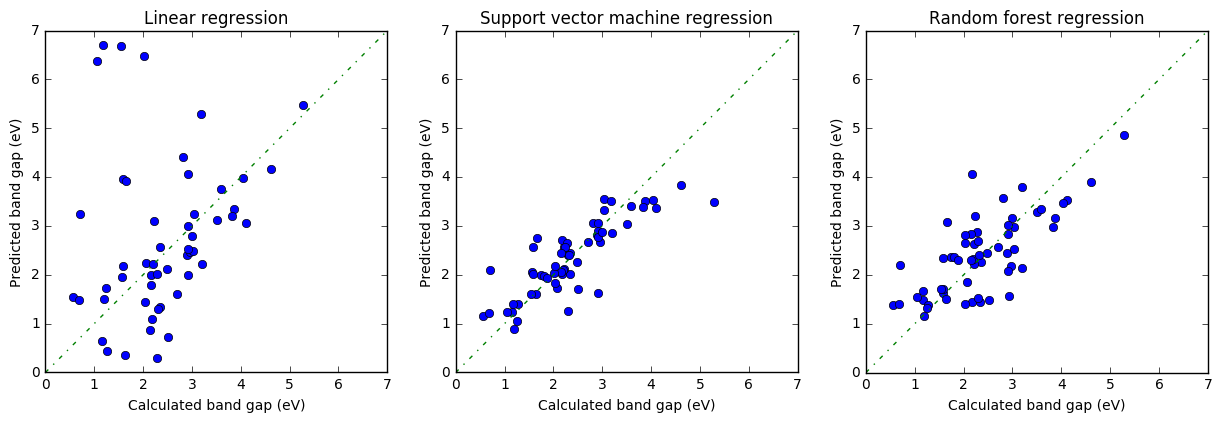

In [2205]:
compare_plot(methods,method_labels,phase_one_feature_full,phase_one_target['Band gap (eV)'],cv_id=5,target_min=0,target_max=7)

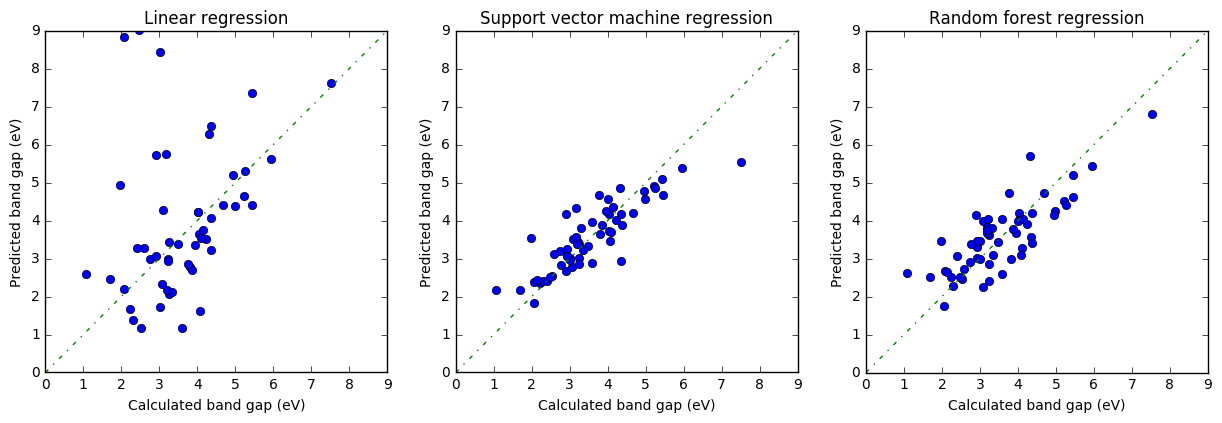

In [2206]:
## HSE-gap for phase-0 compounds
compare_plot(methods,method_labels,phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv_id=5,target_min=0)

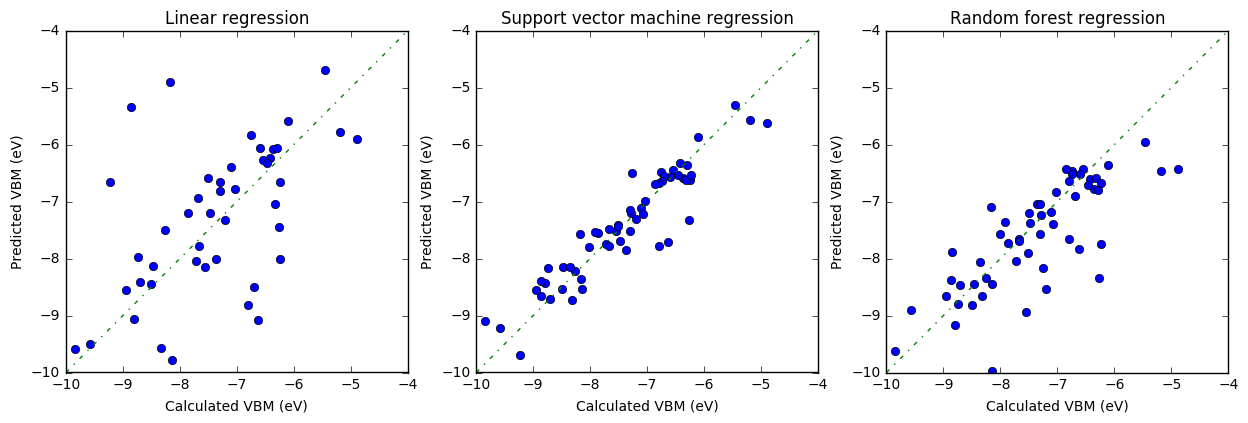

In [2207]:
# HSE-gap for phase 0 compounds
compare_plot(methods,method_labels,phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'],cv_id=5,target_min=-10,target_max=-4,xlabel='Calculated VBM (eV)',ylabel='Predicted VBM (eV)')

In [2318]:
# HSE-VBM for phase 0 compounds
#compare_plot(methods,method_labels,phase_one_feature_full,phase_one_target['HSE-VBM Absolute (eV)'],cv_id=5,target_min=-10,target_max=-4,xlabel='Calculated VBM (eV)',ylabel='Predicted VBM (eV)')

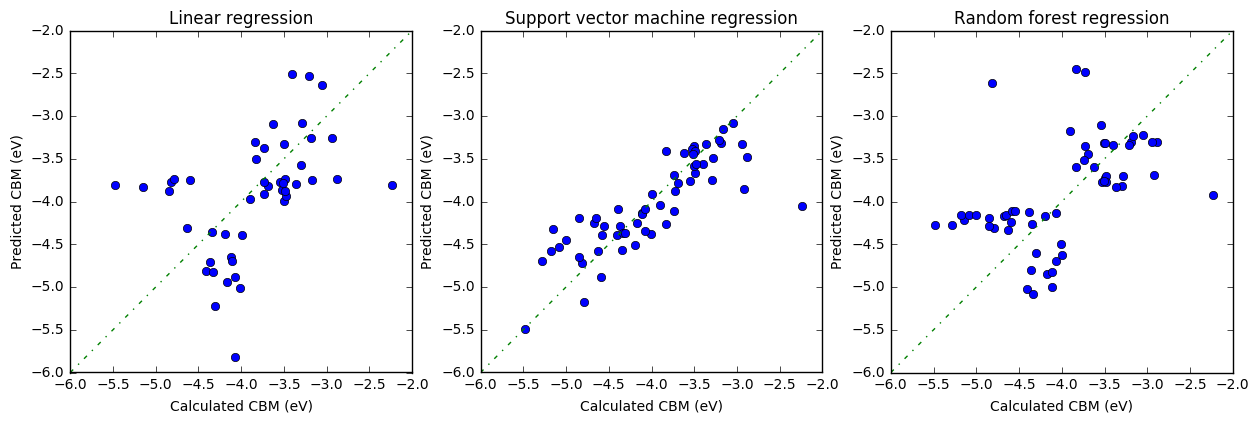

In [2209]:
# HSE-CBM for phase 0 compounds
compare_plot(methods,method_labels,phase_one_feature_full,phase_one_target['HSE-CBM Absolute (eV)'],cv_id=5,target_min=-6,target_max=-2,xlabel='Calculated CBM (eV)',ylabel='Predicted CBM (eV)')

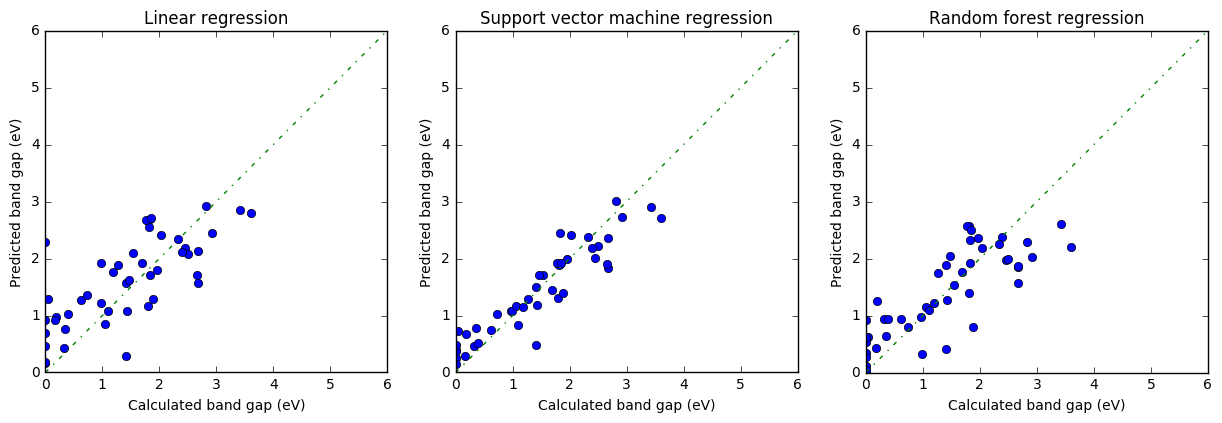

In [2319]:
#phase_two_target
compare_plot(methods,method_labels,phase_two_feature_full,phase_two_target['Band gap (eV)'],cv_id=5,target_min=0,target_max=6)

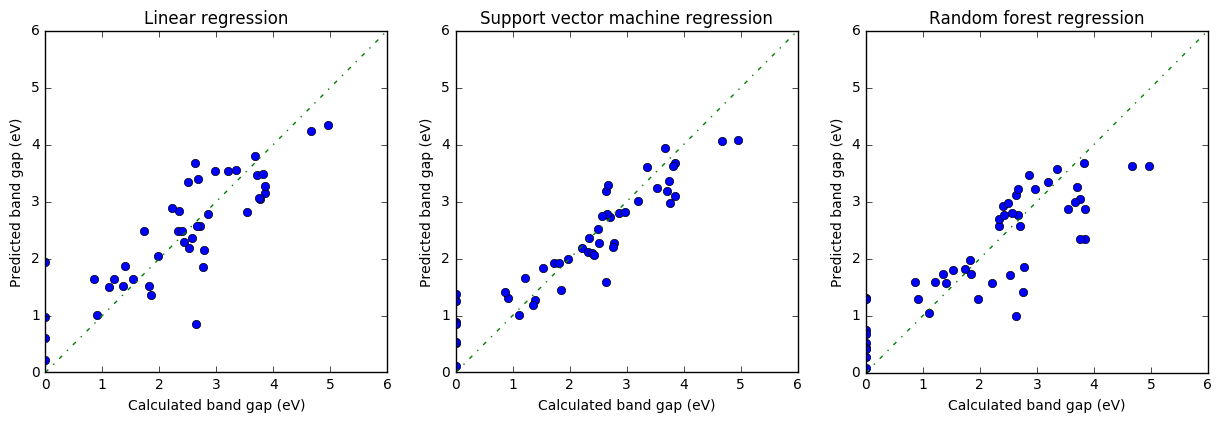

In [2210]:
compare_plot(methods,method_labels,phase_two_feature_full,phase_two_target['HSE-gap (eV)'],cv_id=5,target_min=0,target_max=6)

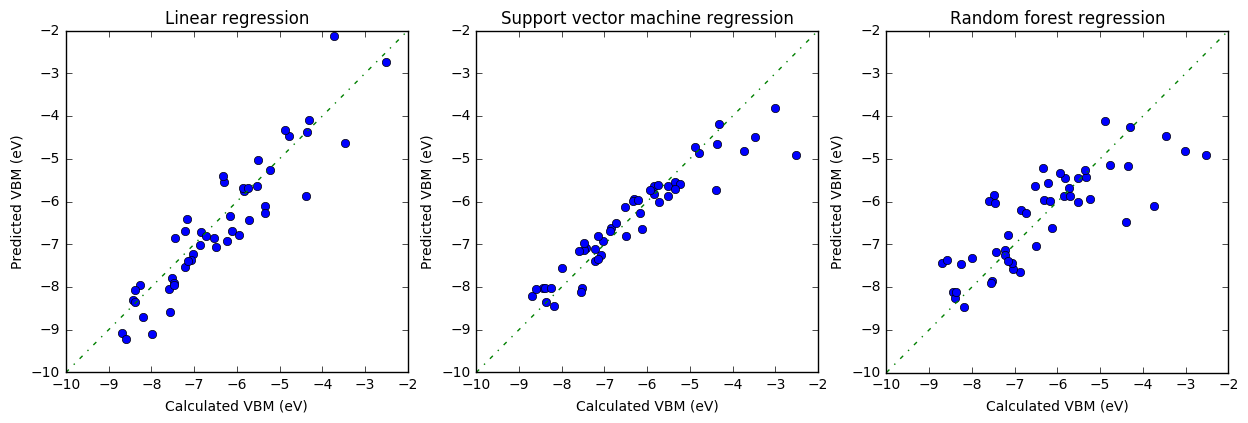

In [2211]:
# HSE-VBM for phase 1 compounds
compare_plot(methods,method_labels,phase_two_feature_full,phase_two_target['HSE-VBM Absolute (eV)'],cv_id=5,target_min=-10,target_max=-2,xlabel='Calculated VBM (eV)',ylabel='Predicted VBM (eV)')

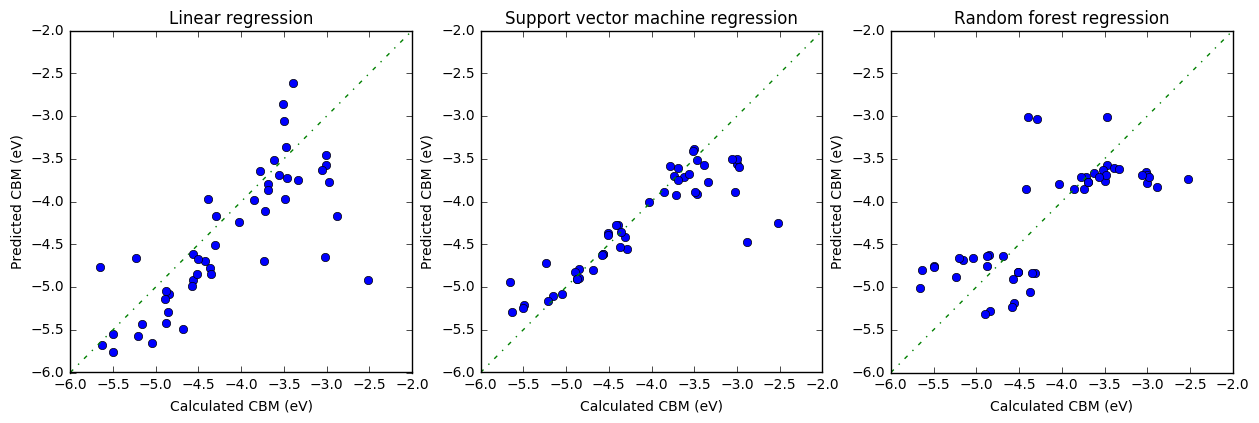

In [2212]:
# HSE-CBM for phase 0 compounds
compare_plot(methods,method_labels,phase_two_feature_full,phase_two_target['HSE-CBM Absolute (eV)'],cv_id=5,target_min=-6,target_max=-2,xlabel='Calculated CBM (eV)',ylabel='Predicted CBM (eV)')

In [1990]:
#phase_one_target

___
### Section 4.5: Grid search for LR, SVR, RFR, and GBT
___

In [1585]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import time

In [2239]:
#ternary_phase_one
#ternary_phase_one[ternary_phase_one['HSE-gap (eV)']<2]

In [2170]:
feature_drop_outlier = phase_one_feature_full.drop([0,6,10,15,32])
target_drop_outlier = phase_one_target['HSE-gap (eV)'].drop([0,6,10,15,32])
# phase_one_feature
# phase_one_target
#phase_one_target['HSE-gap (eV)']
#train_size = 100
C_range = np.logspace(2, 5, 40)
#C_range = [0.1,2,201]
gamma_range = np.logspace(-3, 3, 60)
param_grid=dict(gamma=gamma_range, C=C_range)
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=5,
                   param_grid=param_grid)
svr_rbf_gcv.fit(feature_drop_outlier,target_drop_outlier)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-03,   1.26385e-03,   1.59731e-03,   2.01876e-03,
         2.55141e-03,   3.22459e-03,   4.07539e-03,   5.15068e-03,
         6.50968e-03,   8.22724e-03,   1.03980e-02,   1.31415e-02,
         1.66088e-02,   2.09910e-02,   2.65295e-02,   3.35292e-02,
         4....,   41246.26383,   49238.82632,
         58780.16072,   70170.38287,   83767.76401,  100000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2224]:
scores_phase_one_gap = []
for C_val in C_range:
    scores_phase_one_gap.append([])
    for gamma_val in gamma_range:
        scores_phase_one_gap[-1].append((C_val,gamma_val,cross_val_score(SVR(gamma=gamma_val,C=C_val),phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv=5).mean()))

In [2223]:
def gridSearch(estimator,param_grid,feature,target):
    estimator_cv=GridSearchCV(estimator,param_grid=param_grid)
    estimator_cv.fit(feature,target)
    return (estimator_cv.best_score_,estimator_cv.best_params_)

In [2428]:
# 
# SVR
#
C_range = np.logspace(-3,3,40)
gamma_range = np.logspace(-3,3,40)
param_grid=dict(gamma=gamma_range, C=C_range)
features = [phase_one_feature_full,phase_two_feature_full]
targets = [phase_one_target['HSE-gap (eV)'],phase_one_target['HSE-VBM Absolute (eV)'],phase_one_target['HSE-CBM Absolute (eV)'],phase_two_target['HSE-gap (eV)'],phase_two_target['HSE-VBM Absolute (eV)'],phase_two_target['HSE-CBM Absolute (eV)']]
estimator = SVR(kernel='rbf')
fitting_para = []
for i,feature in enumerate(features):
    for j in range(i*3,i*3+3):
        target = targets[j]
        fitting_para.append(gridSearch(estimator,param_grid,feature,target))

In [2429]:
# first-set of parameters tuning
#tenary_phase_one['HSE-gap (eV)']
#C_range = np.logspace(-1,4,20)
#gamma_range = np.logspace(-3,3,20)
#fitting_para=[
#(0.39364629576172799,{'C': 263.66508987303581, 'gamma': 0.078475997035146114}),
#(0.78001322195296274,{'C': 12.742749857031335, 'gamma': 0.33598182862837811}),
#(0.21000529517921007,{'C': 5455.5947811685146, 'gamma': 0.0020691380811147901}),
#(0.91654036281617168,{'C': 263.66508987303581, 'gamma': 0.078475997035146114}),
#(0.85983892092644632,{'C': 1623.776739188721, 'gamma': 0.0088586679041008226}),
#(0.44220321103301152, {'C': 10000.0, 'gamma': 0.018329807108324356})]
#
#
#fitting_para set 2
#Phase 1: band gap[(0.42157032543640638, {'C': 1000.0, 'gamma': 0.049238826317067413}),
#Phase 1: VBM (0.79080483549628156, {'C': 20.30917620904739, 'gamma': 0.28942661247167517}),
#Phase 1: CBM (0.067310145022700912, {'C': 1000.0, 'gamma': 0.0041246263829013523}),
#(0.21000529517921007,{'C': 5455.5947811685146, 'gamma': 0.0020691380811147901}),
#Phase 2: band gap(0.92093149863995949,{'C': 119.37766417144383, 'gamma': 0.10000000000000001}),
#Phase 2: VBM (0.8620714833736457, {'C': 701.7038286703837, 'gamma': 0.01193776641714437}),
#Phase 2: CBM (0.44803180749486277,{'C': 701.7038286703837, 'gamma': 0.024244620170823284})]

[(0.42157032543640638, {'C': 1000.0, 'gamma': 0.049238826317067413}),
 (0.79080483549628156, {'C': 20.30917620904739, 'gamma': 0.28942661247167517}),
 (0.067310145022700912, {'C': 1000.0, 'gamma': 0.0041246263829013523}),
 (0.92093149863995949,
  {'C': 119.37766417144383, 'gamma': 0.10000000000000001}),
 (0.8620714833736457, {'C': 701.7038286703837, 'gamma': 0.01193776641714437}),
 (0.44803180749486277,
  {'C': 701.7038286703837, 'gamma': 0.024244620170823284})]

___
### Gradient boosted trees
___

In [2307]:
#
# gradient boost trees 
#
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

param_grid=dict(max_depth=[7,8,9,10,11,12,13], min_samples_split=[4,5,6,7,8],learning_rate=[0.06,0.062,0.065,0.068,0.07])
gbt_grid = GridSearchCV(ensemble.GradientBoostingRegressor(), cv=5,
                   param_grid=param_grid)
#svr_rbf_gcv.fit(feature_drop_outlier,target_drop_outlier)
#params = {'max_depth': 5, 'min_samples_split': 5,'learning_rate': 0.1, 'loss': 'ls'}
#clf = ensemble.GradientBoostingRegressor(**params)
#cross_val_score(clf,phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv=10)
#mse = mean_squared_error(y_test, clf.predict())
#print("MSE: %.4f" % mse)
gbt_phase_two_gap=gbt_grid.fit(phase_two_feature_full,phase_two_target['HSE-gap (eV)'])

In [2268]:
plt.plot(np.arange(len(gbt_phase_two_gap.)))
#list(map(int,np.linspace(5,10,1)))

[5]

In [2287]:
#gbt_phase_one_gap.best_params_: for phase_one_hse_gap : {'learning_rate': 0.062, 'max_depth': 12, 'min_samples_split': 7}

{'learning_rate': 0.062, 'max_depth': 12, 'min_samples_split': 7}

In [2304]:
#gbt_phase_one_vbm.best_params_: {'learning_rate': 0.07, 'max_depth': 10, 'min_samples_split': 6}

{'learning_rate': 0.07, 'max_depth': 10, 'min_samples_split': 6}

In [2316]:
gbt_phase_two_gap.best_score_

0.7922484452868378

In [2313]:
predicted_gap_two_gbr=cross_val_predict(ensemble.GradientBoostingRegressor(learning_rate=0.07, max_depth= 8, min_samples_split= 8),phase_two_feature_full,phase_two_target['HSE-gap (eV)'])

In [2317]:
#predicted_gap_two_gbr=

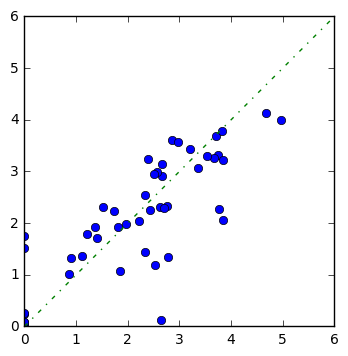

In [2315]:
plt.plot(phase_two_target['HSE-gap (eV)'],predicted_vbm_two_gbr,'o')
plt.axes().set_aspect('equal')
plt.xlim(0,6)
plt.ylim(0,6)
plt.plot([0,6],[0,6],'-.')

In [2312]:
clf.fit(phase_one_feature_full,phase_one_target['HSE-gap (eV)'])
#feature_importance = clf.feature_importances_
#feature_importance = 100.0 * (feature_importance / feature_importance.max())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [2257]:
sorted(list(zip(list(phase_one_feature_full),feature_importance)),key=lambda x:x[1])

[('Anion_1_mass', 0.037686258808176373),
 ('Anion_1_negativity', 0.039499428934081732),
 ('Anion_1_ionization', 0.043981953077679777),
 ('Anion_1_elec_aff', 0.044431401810034243),
 ('Anion_1_row_index', 0.054405052144447602),
 ('Cation_row_index', 0.43188632481972405),
 ('Anion_2_negativity', 0.69521751549197863),
 ('Anion_2_mass', 0.96611401882149839),
 ('Cation_ionization', 1.0147693791560557),
 ('Cation_mass', 1.2496703662490376),
 ('Cation_elec_aff', 1.3390605300318077),
 ('Cation_negativity', 1.3775015019392343),
 ('Anion_2_ionization', 1.3951019010552923),
 ('Anion_2_elec_aff', 1.4929557408579814),
 ('Anion_2_row_index', 1.500483791606358),
 ('Anion_1 - Cation negativity', 2.4584828221058208),
 ('Anion_1 + Anion_2 - Cation negativity', 3.1353664727392547),
 ('a2 (A)', 3.250296162001288),
 ('a1 (A)', 3.3333548060118323),
 ('Anion_2 - Cation negativity', 14.798253162614166),
 ('average mass', 100.0)]

In [2202]:
max_val = (0,0,0)
for array in scores:
    for val in array:
        if val[-1] > max_val[-1]:
            max_val = val
#scores.append([])

In [2221]:
cross_val_score(SVR(gamma=0.09,C=10),phase_one_feature_full,phase_one_target['HSE-gap (eV)'],cv=10).mean()

0.45456267428364833

In [2203]:
# (3.2570206556597832, 0.10000000000000001, 0.55934988730405144)
#scores

(3.2570206556597832, 0.10000000000000001, 0.55934988730405144)

{'gamma': 0.44062364277735727, 'C': 100.0} 0.350472302521


(0, 1000)

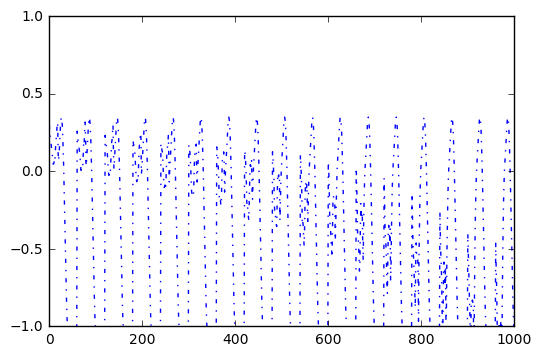

In [2171]:
print(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)
plt.plot(np.arange(len(svr_rbf_gcv.cv_results_['mean_test_score'])),svr_rbf_gcv.cv_results_['mean_test_score'],'-.')
plt.ylim(-1,1)
plt.xlim(0,1000)

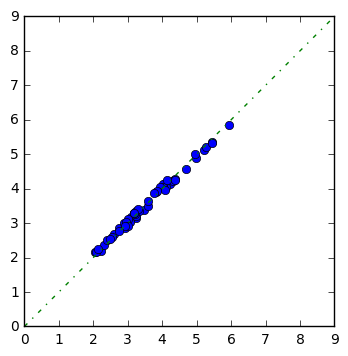

In [2172]:
predicted_gap_svr_rbf_gcv=svr_rbf_gcv.predict(phase_one_feature_full.drop([0,6,10,15,32]))
plt.plot(phase_one_target['HSE-gap (eV)'].drop([0,6,10,15,32]),predicted_gap_svr_rbf_gcv,'o')
plt.xlim(0,9)
plt.ylim(0,9)
plt.plot([0,9],[0,9],'-.')
plt.axes().set_aspect('equal')

{'gamma': 0.053556669177068993, 'C': 701.70382867038222} 0.923461281192


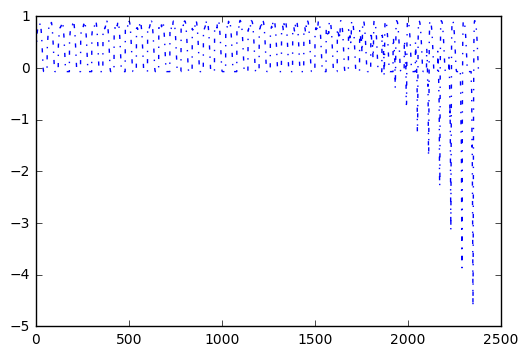

In [2140]:
# really good for phase-2 hse-gap
#print(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)
#plt.plot(np.arange(len(svr_rbf_gcv.cv_results_['mean_test_score'])),svr_rbf_gcv.cv_results_['mean_test_score'],'-.')

In [2142]:
#print(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)
#np.logspace(-2, 4, 7)

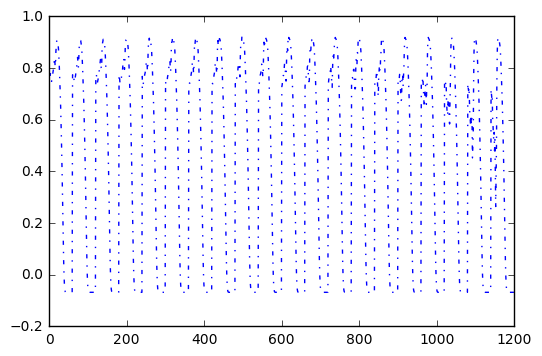

In [2137]:
#plt.plot(np.arange(len(svr_rbf_gcv.cv_results_['mean_test_score'])),svr_rbf_gcv.cv_results_['mean_test_score'],'-.')

In [2122]:
#print(svr_rbf_gcv.best_params_,svr_rbf_gcv.best_score_)
# {'C': 10.0, 'gamma': 0.05647805074067546} for CBM
#{'C': 10.0, 'gamma': 0.39263134017068396} for VBM
#{'C': 10.0, 'gamma': 0.22562304629706351} for band gap

{'gamma': 0.053556669177068993, 'C': 545.55947811685144} 0.918650178422


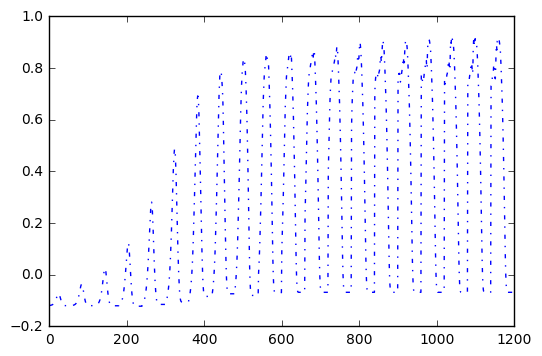

In [2134]:
#plt.plot(np.arange(len(svr_rbf_gcv.cv_results_['mean_test_score'])),svr_rbf_gcv.cv_results_['mean_test_score'],'-.')

In [2127]:
predicted_gap_svr_rbf_gcv=svr_rbf_gcv.predict(phase_two_feature_full)

In [2128]:
#[0,1,200]

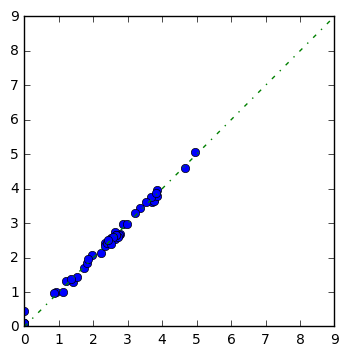

In [2129]:
plt.plot(phase_two_target['HSE-gap (eV)'],predicted_gap_svr_rbf_gcv,'o')
plt.xlim(0,9)
plt.ylim(0,9)
plt.plot([0,9],[0,9],'-.')
plt.axes().set_aspect('equal')

In [1854]:
#plt.plot(phase_one_target['HSE-VBM Absolute (eV)'],predicted_gap_svr_rbf_gcv,'o')

In [1856]:
#plt.plot(phase_one_target['HSE-gap (eV)'],predicted_gap_svr_rbf_gcv,'o')
#plt.xlim(-10,0)
#plt.ylim(-10,0)
#plt.axes().set_aspect('equal')

___
## Section 5: Machine learning models to predict structural properties
___

In [1813]:
#phase_one_structure_feature = phase_one_feature
#phase_two_structure_feature = phase_two_feature

In [1815]:
#phase_two_structure_feature.drop('a2 (A)',axis=1,inplace=True)

In [2713]:
#phase_one_structure_target1 = ternary_phase_one['a1 (A)']
#phase_one_structure_target2 = ternary_phase_one['a2 (A)']
#phase_two_structure_target = ternary_phase_two['a1 (A)']
#phase_one_structure_feature_full = phase_one_feature_full.drop(['a1 (A)','a2 (A)'],axis=1)
#phase_two_structure_feature_full = phase_two_feature_full.drop(['a1 (A)','a2 (A)'],axis=1)

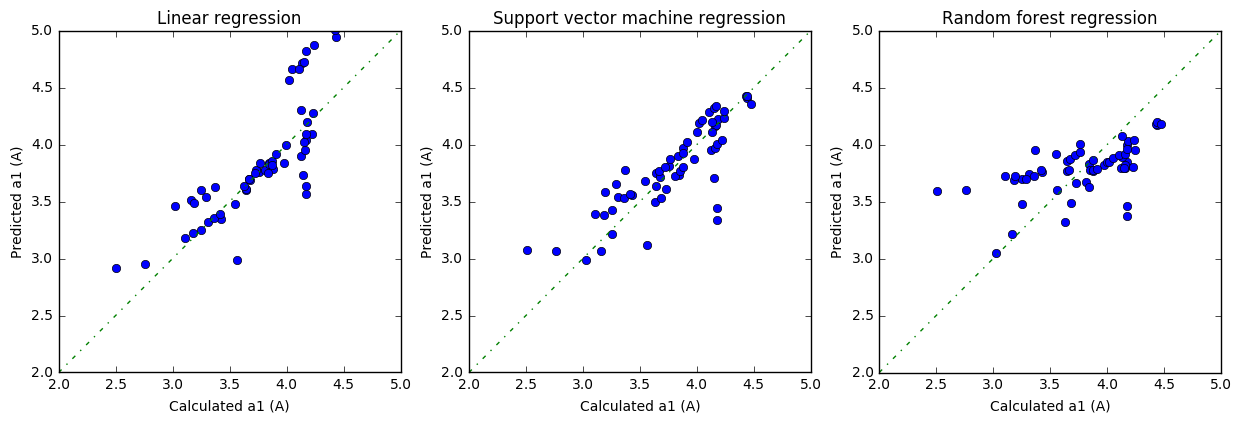

In [2720]:
## HSE-gap for phase-0 compounds
compare_plot(methods,method_labels,phase_one_structure_feature_full,phase_one_structure_target1,cv_id=5,target_min=2,target_max=5,xlabel='Calculated a1 (A)',ylabel='Predicted a1 (A)')

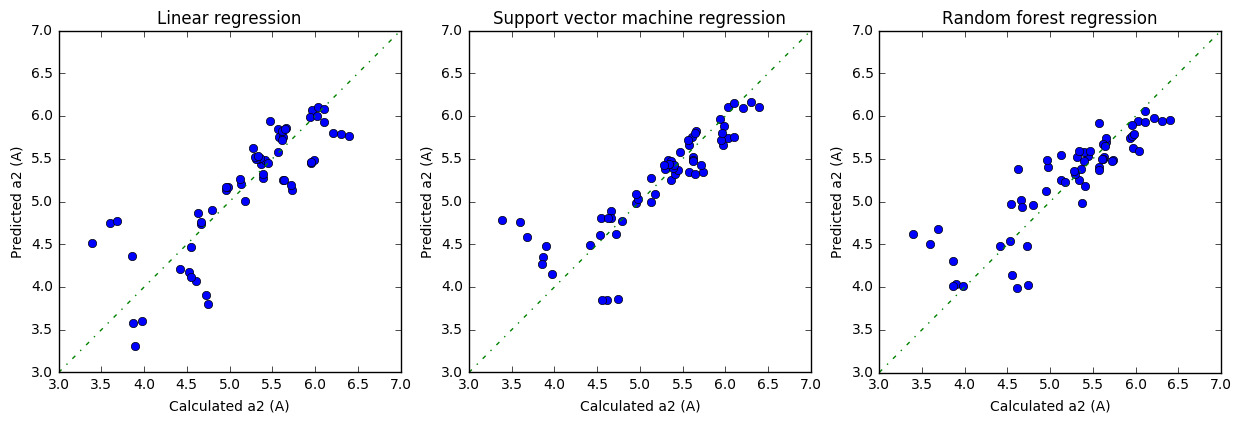

In [2721]:
compare_plot(methods,method_labels,phase_one_structure_feature_full,phase_one_structure_target2,cv_id=10,target_min=3,target_max=7,xlabel='Calculated a2 (A)',ylabel='Predicted a2 (A)')

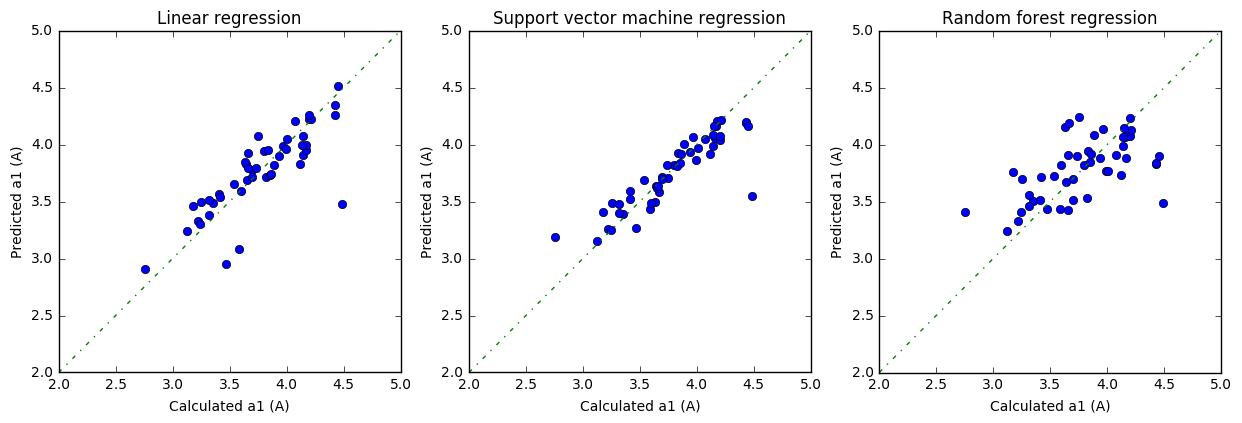

In [2715]:
compare_plot(methods,method_labels,phase_two_structure_feature_full,phase_two_structure_target,cv_id=10,target_min=2,target_max=5,xlabel='Calculated a1 (A)',ylabel='Predicted a1 (A)')

___
## Section 6: Cohesive energy difference between Phase-I and Phase-II structures
___

In [1399]:
dict_phase_one_coh = {}
dict_phase_two_coh = {}
phase_info = list(ternary_info['Phase'])
cohesive_info = list(ternary_info['Cohesive energy (eV/atom)'])
compound_compare = []
for i,phase in enumerate(list(ternary_info['Phase'])):
    if phase.split('_')[-1]=='0':
        dict_phase_one_coh[phase.split('_')[0]]=list(ternary_info['Cohesive energy (eV/atom)'])[i]
    elif phase.split('_')[-1]=='1':
        dict_phase_two_coh[phase.split('_')[0]]=list(ternary_info['Cohesive energy (eV/atom)'])[i]

In [1558]:
#set(dict_phase_two_coh.keys())-set(dict_phase_one_coh.keys())

In [1444]:
compound_compare=[]
for compound in dict_phase_two_coh:
    if compound in dict_phase_one_coh:
        if dict_phase_one_coh[compound]<dict_phase_two_coh[compound]:
            compound_compare.append((compound,1,dict_phase_two_coh[compound]-dict_phase_one_coh[compound]))
        else:
            compound_compare.append((compound,2,dict_phase_one_coh[compound]-dict_phase_two_coh[compound]))

In [1454]:
#compound_compare

In [1446]:
#atomic_info.count_elem('AlOBr')
III_elem={'B':1,'Al':2,'Ga':3,'In':4}
VI_elem={'O':1,'S':2,'Se':3,'Te':4}
VII_elem ={'F':1,'Cl':2,'Br':3,'I':4}
compound_compare.sort(key=lambda x:III_elem[atomic_info.count_elem(x[0])[0]]*100+VI_elem[atomic_info.count_elem(x[0])[1]]*10+VII_elem[atomic_info.count_elem(x[0])[2]])

In [1447]:
len(compound_compare)
#VI_elem[atomic_info.count_elem(('AlSBr',1)[0])[1]]

46

(0, 0.8)

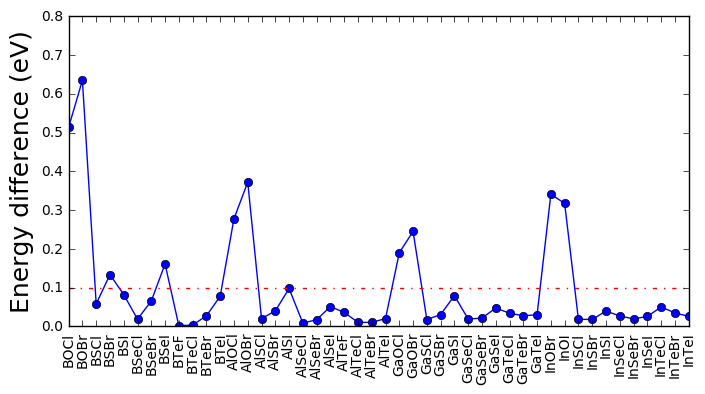

In [1476]:
fig_coh, ax_coh = plt.subplots(figsize=(8,4))
ax_coh.plot(np.arange(46),[compound_compare[i][2] for i in range(46)],'o-')
ax_coh.plot([0,45],[0.1,0.1],'-.r')
ax_coh.set_xticks(np.arange(46))
ax_coh.set_xticklabels([compound_compare[i][0] for i in range(46)],rotation=90)
#ax_coh.set_title('Cohesive energy of Phase I and Phase II')
#plt.text(0.1, 1,'Cohesive energy of Phase I and Phase II', transform=ax.transAxes,fontsize=16)
ax_coh.set_ylabel('Energy difference (eV)',fontsize=18)
ax_coh.set_ylim(0,0.8)
#plt.figure(figsize=(10,5))
#plt.xticklabels([compound_compare[i][0] for i in range(46)])

In [1495]:
#phase_two_feature

In [1497]:
#phase_diff_feature.drop([2,15,28],inplace=True)

In [1505]:
#compound_compare

In [1504]:
#phase_diff_target=[compound_compare[i][2] for i in range(len(compound_compare))]

In [2732]:
#phase_diff_feature_full

In [1513]:
phase_diff=phase_diff_feature

In [1515]:
#phase_diff.reset_index(inplace=True)

In [1519]:
#phase_diff.drop('index',axis=1,inplace=True)

In [1522]:
#phase_diff.reset_index(inplace=True)

In [1524]:
#phase_diff['Energy difference (eV)']=phase_diff['index'].map(lambda x:phase_diff_target[x])

In [1527]:
phase_diff_new_full=phase_diff.drop(phase_diff['Energy difference (eV)']>0.2)

In [1837]:
#phase_diff_feature.drop('index',axis=1,inplace=True)

In [1535]:
#phase_diff_new

In [1536]:
#phase_diff_new.drop(['level_0','index'],inplace=True,axis=1)

In [1537]:
#phase_diff_feature_new=phase_diff_new.drop('Energy difference (eV)',axis=1)

In [1552]:
#phase_diff_feature=phase_diff_feature.drop('Energy difference (eV)',axis=1)

In [1847]:
#C_range = [1,200,201]
gamma_range = np.logspace(-3, 3, 30)
C_range = np.logspace(-3,3,20)
#gamma_range
param_grid = dict(gamma=gamma_range, C=C_range)
#param_grid=dict(gamma=gamma_range, C=C_range)
#param_grid={"C": [0.5e0,1e0, 0.5e1,1e1, 0.5e2,1e2, 0.5e3,1e3,0.5e4,1e4],"gamma": np.logspace(-6,6,100)}
svr_rbf_gcv = GridSearchCV(SVR(kernel='rbf', gamma=0.01), cv=5,
                   param_grid=param_grid)
#param_grid={"C": [0.5e0,1e0, 0.5e1,1e1, 1e2, 1e3],"gamma": np.logspace(-6,6,100)}
#kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
#                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
#                              "gamma": np.logspace(-2, 2, 5)})

#t0 = time.time()
svr_rbf_gcv.fit(phase_diff_feature_new, phase_diff_new['Energy difference (eV)'])

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-03,   1.61026e-03,   2.59294e-03,   4.17532e-03,
         6.72336e-03,   1.08264e-02,   1.74333e-02,   2.80722e-02,
         4.52035e-02,   7.27895e-02,   1.17210e-01,   1.88739e-01,
         3.03920e-01,   4.89390e-01,   7.88046e-01,   1.26896e+00,
         2....,   2.63665e+01,   5.45559e+01,
         1.12884e+02,   2.33572e+02,   4.83293e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1848]:
svr_rbf_gcv.best_params_

{'C': 26.366508987303554, 'gamma': 0.0025929437974046669}

In [2019]:
#C_range = np.logspace(-2, 2, 20)
C_range = np.arange(3,4,0.01)
#gamma_range = np.logspace(-2, 2, 20)
gamma_range = np.arange(0.05,0.2,0.01)
param_grid = dict(gamma=gamma_range, C=C_range)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVR(), param_grid=param_grid, cv=5)
grid.fit(phase_one_feature_full, phase_one_target['HSE-gap (eV)'])

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

The best parameters are {'gamma': 0.10000000000000001, 'C': 3.0099999999999998} with a score of 0.56


In [2020]:
#grid.cv_results_

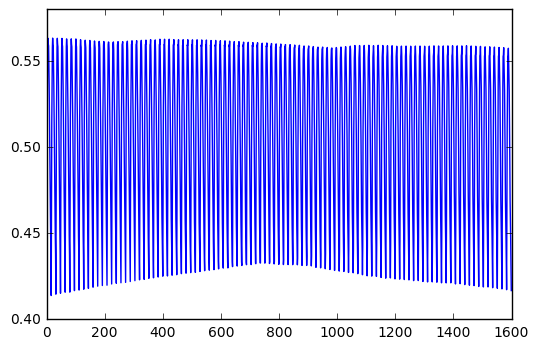

In [2021]:
plt.plot(np.arange(len(list(grid.cv_results_['mean_test_score']))),list(grid.cv_results_['mean_test_score']),'-')

In [2724]:
grid.best_params_

{'C': 3.0099999999999998, 'gamma': 0.10000000000000001}

In [1994]:
#phase_one_target

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
regressors = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        regressors.append((C, gamma, clf))

In [1997]:
#[1e-2:1:1e2]
#np.arange()

In [1841]:
#len(phase_diff_target)
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [2423]:
svr_rbf_struc = SVR(kernel='rbf', C=26.3665, gamma=0.00259)
RFR_struc = RandomForestRegressor()
methods_struc = [lm_lr,svr_rbf_struc,RFR_struc]

In [2723]:
#phase_diff_feature_new

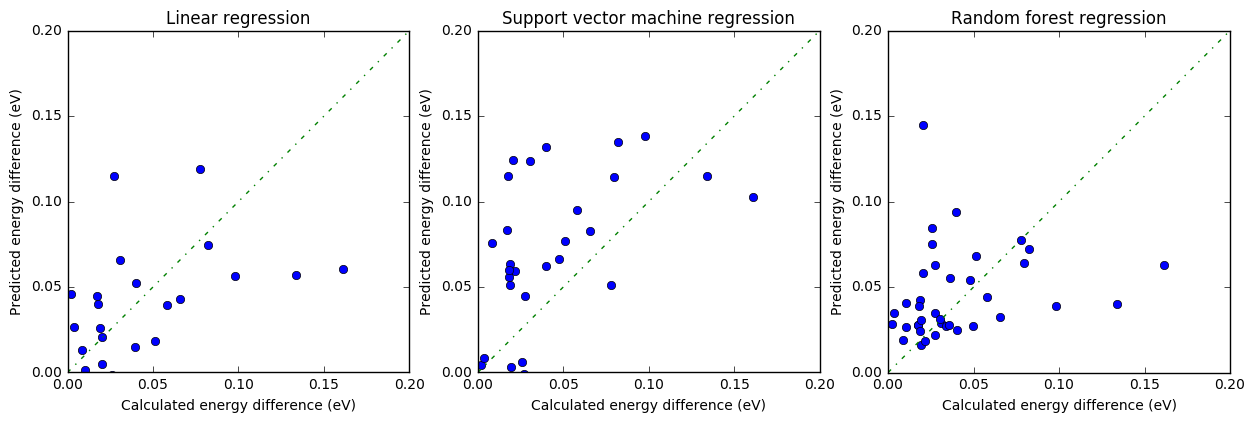

In [2728]:
compare_plot(methods_struc,method_labels,phase_diff_feature,phase_diff['Energy difference (eV)'],cv_id=5,target_min=0,target_max=0.2,xlabel='Calculated energy difference (eV)',ylabel='Predicted energy difference (eV)')

In [2729]:
# only consider e_diff < 0.2 eV
compare_plot(methods,method_labels,phase_diff_feature_new,phase_diff_new['Energy difference (eV)'],cv_id=5,target_min=0,target_max=0.2,xlabel='Calculated energy difference (eV)',ylabel='Predicted energy difference (eV)')

ValueError: max_features must be in (0, n_features]

In [1564]:
#methods[0].coef_

In [ ]:
# do gridsearchCV
# 
#